In [1]:
import os
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import Adam
from torch.utils.data import DataLoader
from torch.nn import init
from tabulate import tabulate
import csv
from focal_Loss import *
from utility import *
from torch.utils.tensorboard import SummaryWriter  


# Read dataset

In [2]:
# data_name = "SC1500"
data_name = "CFL30"

data_path = "DataSet"+data_name+"/"
split = [0.80,0.10,0.10]

dataSet = load_data(data_path)

data_train,data_validation,data_test = torch.utils.data.random_split(dataSet,[int(len(dataSet) * s) for s in split])
# print(dataSet[0]['A'])
# for l in dataSet[0]['A']:
#     for i in l:
#         print(int(i!=0),end = '\t')
#     print()

# data_train_X,data_train_Y,data_validation_X,data_validation_Y,data_test_X,data_test_Y,A = load_data()
# print(data_train_X.shape)
# print(data_train_Y.shape)
# print(A.shape)
def setup_seed(seed):
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    torch.backends.cudnn.deterministic = True

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
print(device)
if device == torch.device("cuda"):
#     torch.cuda.empty_cache()
    data_train_gpu = []
    for i in range(len(data_train)):
        inputs, labels = torch.from_numpy(data_train[i]['X']).float(),torch.from_numpy(data_train[i]['Y']).type(torch.FloatTensor).float()
        A = torch.from_numpy(data_train[i]['A']).float()
        inputs = inputs.to(device)
        labels = labels.to(device)
        A = A.to(device)
        data_train_gpu.append([inputs,labels,A])
    data_valide_gpu = []
    for i in range(len(data_validation)):
        inputs, labels = torch.from_numpy(data_validation[i]['X']).float(),torch.from_numpy(data_validation[i]['Y']).type(torch.FloatTensor).float()
        A = torch.from_numpy(data_validation[i]['A']).float()
        inputs = inputs.to(device)
        labels = labels.to(device)
        A = A.to(device)
        data_valide_gpu.append([inputs,labels,A])
        
    data_test_gpu = []
    for i in range(len(data_test)):
        inputs, labels = torch.from_numpy(data_test[i]['X']).float(),torch.from_numpy(data_test[i]['Y']).type(torch.FloatTensor).float()
        A = torch.from_numpy(data_test[i]['A']).float()
        inputs = inputs.to(device)
        labels = labels.to(device)
        A = A.to(device)
        data_test_gpu.append([inputs,labels,A])

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:07<00:00, 14.24it/s]


cuda


In [11]:
def valide(model,criterion,data_validation,with_diving = False,proportion = 0.7):
        vloss = []
        accuracy_value = []
        accuracy_instance = []
        
        accuracy_one = []
        accuracy_one_predict = []
        nb_predict_one = []
        nb_one = []
        
        accuracy_zero = []
        accuracy_zero_predict = []
        nb_zero = []
        nb_predict_zero = []
        
        accuracy_fixe_one = []
        accuracy_fixe_zero = []  
        accuracy_fixe = []
        
        data_size = len(data_validation)
        for i in range(data_size):
            if device == torch.device("cuda"):
                inputs, labels = data_validation[i][0],data_validation[i][1]#torch.from_numpy(data_train[i]['X']).float(),torch.from_numpy(data_train[i]['Y']).type(torch.FloatTensor).float()
                A =data_validation[i][2]# torch.from_numpy(data_train[i]['A']).float()
            else:
                inputs, labels =torch.from_numpy(data_train[i]['X']).float(),torch.from_numpy(data_train[i]['Y']).type(torch.FloatTensor).float()
                A =torch.from_numpy(data_train[i]['A']).float()
            
            if with_diving:
                x,y = model(inputs,A)
                predictions = x[:len(labels)].squeeze(dim=-1)
                pred_y = y[:len(labels)].squeeze(dim=-1)
#                 print(pred_y)
                loss =criterion([predictions,pred_y],labels)
            else:
                predictions = net(inputs,A)[:len(labels)].squeeze(dim=-1)
                loss =criterion(predictions,labels)
            
            A = A.cpu()
            labels = labels.cpu()

            predictions = predictions.cpu()
            nb_one_total = torch.sum(torch.where(labels == 1,1,0))
            nb_zero_total = (len(labels) - nb_one_total)
            aux= torch.Tensor([0.5])
            y_hat = (predictions > aux).float() * 1
            is_equal = torch.where(y_hat == labels,1,0)
            vloss.append(loss.cpu().detach().numpy())
            accuracy_value.append(is_equal.cpu().sum().detach().numpy()/
                           len(labels))
            accuracy_instance.append(int(accuracy_value[-1]==1))
            #accuracy proportion
            predictions_abs =  np.abs(0.5 - predictions.detach().numpy())
            thresholds = abs(np.sort(-predictions_abs))[int(proportion * len(predictions.cpu().detach().numpy()))- 1]
#             thresholds_low = np.sort(predictions_abs)[int(proportion_low * nb_zero_total]
#             thresholds_up = abs(np.sort(-predictions_abs))[int(proportion_up * nb_one_total)]
            
            #accuracy for differents labels(0 or 1)
            nb_one_fixe = 0
            nb_zero_fixe = 0
            nb_correct_one = 0
            nb_correct_zero = 0
            nb_correct_fixe_one = 0
            nb_correct_fixe_zero = 0
            nb_correct_fixe = 0
            nb_fixe = 0 
            for j,v in enumerate(is_equal):
                if labels[j] == 1:
                    nb_correct_one += v
                else:
                    nb_correct_zero += v

                if predictions_abs[j] >= thresholds:             
                    if labels[j]:
                        nb_correct_fixe_one += v
                    else:
                        nb_correct_fixe_zero += v
                        
                    if y_hat[j]:
                        nb_one_fixe += 1
                    else:
                        nb_zero_fixe += 1

#                 if predictions_abs[j] <= thresholds_low:
#                     if labels[j] == 0:
#                         nb_correct_fixe_zero += v
#                     nb_zero_to_fixe += 1
#                 if predictions_abs[j] >= thresholds_up:
#                     if labels[j] == 1:
#                         nb_correct_fixe_one += v
#                     nb_one_to_fixe += 1
                    
            nb_one_total = torch.sum(torch.where(labels == 1,1,0))
            nb_one_predict = torch.sum(torch.where(y_hat == 1,1,0))
            accuracy_one.append((nb_correct_one/nb_one_total))
            accuracy_one_predict.append((nb_correct_one/nb_one_predict) if nb_one_predict > 0 else 0)
            nb_predict_one.append(nb_one_predict)
            nb_one.append(nb_one_total)
            
            nb_zero_predict = (len(labels) - nb_one_predict)
            accuracy_zero.append((nb_correct_zero/nb_zero_total))
            accuracy_zero_predict.append((nb_correct_zero/nb_zero_predict) if nb_zero_predict > 0 else 0)
            nb_predict_zero.append(nb_zero_predict)
            nb_zero.append(nb_zero_total)
            
#             print(inputs,A,nb_one_fixe,nb_zero_fixe)
            accuracy_fixe.append((nb_correct_fixe_one+nb_correct_fixe_zero)/(nb_one_fixe+nb_zero_fixe)if (nb_one_fixe+nb_zero_fixe)>0 else 0)
            accuracy_fixe_one.append(nb_correct_fixe_one/nb_one_fixe if nb_one_fixe>0 else 0)
            accuracy_fixe_zero.append(nb_correct_fixe_zero/nb_zero_fixe if nb_zero_fixe>0 else 0)
            
        #     print(nb_correct_fixe.cpu(),nb_var_fixe)
        #         print(labels,"\n",predictions)
        #         print(labels[0:10],y_hat[0:10])
        msg = ("Loss = %f,Accuracy_value = %f,Accuracy_instance = %f\n"\
              %(np.mean(vloss),np.mean(accuracy_value),np.sum(accuracy_instance)/len(accuracy_instance)))
        msg +=("Label_One_Predict_One = %f,Predict_One_Label_One = %f,Nombre_Predict_One = %f,Nombre_One_Mean = %f\n"\
              %(np.mean(accuracy_one),np.mean(accuracy_one_predict),np.mean(nb_predict_one),np.mean(nb_one)))
        msg +=("Label_Zero_Predict_Zero = %f,Label_Zero_Predict_Zero = %f,Nombre_Predict_Zero = %f,Nombre_Zero_Mean = %f\n"\
              %(np.mean(accuracy_zero),np.mean(accuracy_zero_predict),np.mean(nb_predict_zero),np.mean(nb_zero)))
        msg +=("Accuracy_fixe_mean = %f,Accuracy_fixe_one = %f,Accuracy_fixe_zero = %f\n"\
              %(np.mean(accuracy_fixe),np.mean(accuracy_fixe_one),np.mean(accuracy_fixe_zero)))
        print(msg)
        return msg,np.mean(accuracy_value),np.sum(accuracy_instance)/len(accuracy_instance),np.mean(accuracy_fixe_one),np.mean(accuracy_fixe_zero),np.mean(accuracy_one_predict),np.mean(accuracy_zero_predict)

# GCN

In [4]:
class simpleMLP(nn.Module):
    def __init__(self, input_size, out_size,activate = nn.ReLU()):
        super(simpleMLP, self).__init__()
        self.linear = nn.Linear(input_size, out_size)
        self.activate = activate
        
    def forward(self, x):
        x = self.linear(x)
        x = self.activate(x)
        return x
    
class GNN(nn.Module):
    def __init__(self, input_size,hidden_size,nb_MLP,layerNorm = False):
        super(GNN,self).__init__()
        self.size_mlp = nb_MLP
        self.mlp = nn.ModuleList(
            [simpleMLP(input_size, hidden_size)]+[simpleMLP(hidden_size, hidden_size)]+[simpleMLP(hidden_size*2, hidden_size) for i in range(self.size_mlp - 2)]   
        )
        self.layerNorm = nn.ModuleList(
            [nn.LayerNorm(hidden_size) for i in range(self.size_mlp)]
        )
    
    def forward(self, x, A):
        for i in range(self.size_mlp):
            x = self.mlp[i](x)
            y = A @ x
            y = self.layerNorm[i](y)
            if i != 0:
                x = torch.cat([y,x],1)#sum plutot que con
            else:
                x = y
        return x
    
class VariablePredictor(nn.Module):
    def __init__(self, input_size,hidden_size,nb_MLP):
        super(VariablePredictor,self).__init__()
        self.GNN = GNN(input_size,hidden_size,nb_MLP)
        self.outlayer_x = simpleMLP(hidden_size*2,1,nn.Sigmoid())    
    
    def forward(self,x,A):
        x = self.GNN(x,A)
        return self.outlayer(x)
    
class VariablePredictorDiving(nn.Module):
    def __init__(self, input_size,hidden_size,nb_MLP):
        super(VariablePredictorDiving,self).__init__()
        self.GNN = GNN(input_size,hidden_size,nb_MLP)
        self.outlayer_x = simpleMLP(hidden_size*2,1,nn.Sigmoid())    
        self.outlayer_y = simpleMLP(hidden_size*2,1,nn.Sigmoid())    
        
    def forward(self,x,A):
        x = self.GNN(x,A)
        return self.outlayer_x(x),self.outlayer_y(x)
     

## Train


In [5]:
def train(net,criterion,optm,data_valide,proportion,writer,
              batch_size = 1,EPOCHS=500,do_valide = True,do_log = True,epochs_continue = 0,with_diving = False):
    aux= torch.Tensor([0.5]).to(device)
    for epoch in tqdm(range(epochs_continue,epochs_continue+EPOCHS)):
        #validation
        if do_valide and epoch % 50 == 0:
            v = valide(net,criterion,data_valide,with_diving,proportion)
            if do_log:
                writer.add_scalar('Accuracy_fixe_one ', v[3], epoch)
                writer.add_scalar('Accuracy_fixe_zero ', v[4], epoch)
                writer.add_scalar('Accuracy_one ', v[5], epoch)
                writer.add_scalar('Accuracy_zero ', v[6], epoch)
        #train
        data_size = len(data_train)
        log = []
        for i in range(data_size):
            if device == torch.device("cuda"):
                train_inputs, train_labels = data_train_gpu[i][0],data_train_gpu[i][1]#torch.from_numpy(data_train[i]['X']).float(),torch.from_numpy(data_train[i]['Y']).type(torch.FloatTensor).float()
                A =data_train_gpu[i][2]# torch.from_numpy(data_train[i]['A']).float()
            else:
                train_inputs, train_labels = torch.from_numpy(data_train[i]['X']).float(),torch.from_numpy(data_train[i]['Y']).type(torch.FloatTensor).float()
                A = torch.from_numpy(data_train[i]['A']).float()    
            
            if with_diving:
                x,y = net(train_inputs,A)
                predictions = x[:len(train_labels)].squeeze(dim=-1)
                pred_y = y[:len(train_labels)].squeeze(dim=-1)
                loss =criterion([predictions,pred_y],train_labels)
            else:
                predictions = net(train_inputs,A)[:len(train_labels)].squeeze(dim=-1)
                loss =criterion(predictions,train_labels)
            
            loss.backward()
            if epoch % batch_size == 0:
                optm.step()
                optm.zero_grad()
            if do_log:
                writer.add_scalar('LearningRate',optm.param_groups[0]['lr'], epoch)
            scheduler.step()
            gradient_norm = 0
            for p in net.parameters():
                param_norm = p.grad.detach().data.norm(2)
                gradient_norm += param_norm.item() ** 2
            gradient_norm = gradient_norm ** 0.5
            y_hat = (predictions > aux).float() * 1
            is_equal = torch.where(y_hat == train_labels,1,0)
            acc = is_equal.cpu().sum().detach().numpy()/len(train_labels)
            log.append([loss.cpu().detach().numpy(),acc,gradient_norm])
        
        log = np.array(log).T
        if do_log:
            writer.add_scalar('Loss', np.mean(log[0]), epoch)
            writer.add_scalar('Accuracy', np.mean(log[1]), epoch)
            writer.add_scalar('Gradient_norm', np.mean(log[2]), epoch)


In [6]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
class SelectiveLoss(nn.Module):  
    def __init__(self, C=0.75,lam = 0.5):
        super(SelectiveLoss, self).__init__() 
        self.C = C  
        self.lam = lam
            
    def forward(self, predictions, labels):
        pred_x,pred_y = predictions
        bce = nn.BCELoss()
        
        frequency = self.lam * torch.square(self.C - torch.mean(pred_y))
        loss = nn.BCELoss(weight=pred_y.detach(), reduction='sum')(pred_x, labels) / torch.sum(pred_y)  + frequency
        return loss+bce(pred_x,labels)
#         loss =  -torch.sum(torch.log(torch.where(labels > 0, torch.maximum(torch.minimum(pred_x,torch.tensor(1-10e-6)),torch.tensor(10e-6)), \
#                             torch.maximum(torch.minimum(1-pred_x,torch.tensor(1-10e-6)),torch.tensor(10e-6)))*pred_y))\
#                            /torch.sum(pred_y) + frequency

In [ ]:
nb_mlp = 6
proportion = 0.8
feature_size = 24
H = 50
info_valide = []
gamma = 0.5
alpha = 0.25
batch_size = 1
EPOCHS = 1000
learning_rate = 0.001

C = 0.75
lam = 0.5
for C in [0.5,0.75]:
    for lam in [0.5,0.75]:
#     criterion = nn.BCELoss()
        criterion = SelectiveLoss(C,lam)
    #     criterion = FocalLoss(gamma=gamma,alpha = alpha)
        if criterion.__str__()=="BCELoss()":
            train_name = data_name+"_BCE_"+\
                nb_mlp.__str__()+"MLP_"+H.__str__()+"TailleH_"+batch_size.__str__()+"batch_size_"+"layernorm+cat"
        elif criterion.__str__()=="FocalLoss()":
            train_name = data_name+"_FL_"+gamma.__str__()+"Gamma_"+alpha.__str__()+"Alpha_"+\
                nb_mlp.__str__()+"MLP_"+H.__str__()+"TailleH_"+batch_size.__str__()+"batch_size_"+"layernorm+cat"
        elif criterion.__str__()=="SelectiveLoss()":
            train_name = data_name+"_SL_"+C.__str__()+"C_"+lam.__str__()+"Lambda_"+\
                nb_mlp.__str__()+"MLP_2"
        writer = SummaryWriter('./logs/'+data_name+"/"+train_name+"/")

        net = VariablePredictorDiving(feature_size,H,nb_mlp)
        net.to(device)
        optm = Adam(net.parameters(), lr = learning_rate)

        scheduler = torch.optim.lr_scheduler.ExponentialLR(optm, gamma=1-10e-6)
        train(net,criterion,optm,data_valide_gpu,proportion,writer,batch_size = batch_size,EPOCHS=EPOCHS,
                  do_valide = True,do_log = True,with_diving=True)

        model_path = "model/"+train_name
        torch.save(net.state_dict(),model_path)
        msg=valide(net,criterion,data_test_gpu,with_diving = True,proportion = proportion)
        info_valide.append(msg[1:])
        with open('./logs/'+data_name+"/"+train_name+"/valide_log.txt", "w") as txtfile:
            print("{}".format(msg), file=txtfile)

  0%|                                                                                         | 0/1000 [00:00<?, ?it/s]

Loss = 1.270530,Accuracy_value = 0.893011,Accuracy_instance = 0.000000
Label_One_Predict_One = 0.064538,Predict_One_Label_One = 0.028800,Nombre_Predict_One = 69.600000,Nombre_One_Mean = 34.300000
Label_Zero_Predict_Zero = 0.924753,Label_Zero_Predict_Zero = 0.962703,Nombre_Predict_Zero = 860.400000,Nombre_Zero_Mean = 895.700000
Accuracy_fixe_mean = 0.959005,Accuracy_fixe_one = 0.100000,Accuracy_fixe_zero = 0.959771



  5%|████                                                                            | 50/1000 [00:43<13:39,  1.16it/s]

Loss = 0.160584,Accuracy_value = 0.972688,Accuracy_instance = 0.000000
Label_One_Predict_One = 0.557227,Predict_One_Label_One = 0.651180,Nombre_Predict_One = 29.300000,Nombre_One_Mean = 34.300000
Label_Zero_Predict_Zero = 0.988611,Label_Zero_Predict_Zero = 0.983135,Nombre_Predict_Zero = 900.700000,Nombre_Zero_Mean = 895.700000
Accuracy_fixe_mean = 0.993011,Accuracy_fixe_one = 0.000000,Accuracy_fixe_zero = 0.993011



 10%|███████▉                                                                       | 100/1000 [01:27<12:55,  1.16it/s]

Loss = 0.172812,Accuracy_value = 0.970860,Accuracy_instance = 0.000000
Label_One_Predict_One = 0.458235,Predict_One_Label_One = 0.652939,Nombre_Predict_One = 24.200000,Nombre_One_Mean = 34.300000
Label_Zero_Predict_Zero = 0.990508,Label_Zero_Predict_Zero = 0.979479,Nombre_Predict_Zero = 905.800000,Nombre_Zero_Mean = 895.700000
Accuracy_fixe_mean = 0.991936,Accuracy_fixe_one = 0.000000,Accuracy_fixe_zero = 0.991936



 15%|███████████▊                                                                   | 150/1000 [02:11<13:30,  1.05it/s]

Loss = 0.174373,Accuracy_value = 0.971398,Accuracy_instance = 0.000000
Label_One_Predict_One = 0.487395,Predict_One_Label_One = 0.645865,Nombre_Predict_One = 25.700000,Nombre_One_Mean = 34.300000
Label_Zero_Predict_Zero = 0.989951,Label_Zero_Predict_Zero = 0.980552,Nombre_Predict_Zero = 904.300000,Nombre_Zero_Mean = 895.700000
Accuracy_fixe_mean = 0.991264,Accuracy_fixe_one = 0.450000,Accuracy_fixe_zero = 0.991520



 20%|███████████████▊                                                               | 200/1000 [02:54<11:23,  1.17it/s]

Loss = 0.203638,Accuracy_value = 0.967957,Accuracy_instance = 0.000000
Label_One_Predict_One = 0.403193,Predict_One_Label_One = 0.595838,Nombre_Predict_One = 23.100000,Nombre_One_Mean = 34.300000
Label_Zero_Predict_Zero = 0.989616,Label_Zero_Predict_Zero = 0.977407,Nombre_Predict_Zero = 906.900000,Nombre_Zero_Mean = 895.700000
Accuracy_fixe_mean = 0.989382,Accuracy_fixe_one = 0.066667,Accuracy_fixe_zero = 0.989643



 25%|███████████████████▊                                                           | 250/1000 [03:37<10:42,  1.17it/s]

Loss = 0.233405,Accuracy_value = 0.969247,Accuracy_instance = 0.000000
Label_One_Predict_One = 0.487227,Predict_One_Label_One = 0.610620,Nombre_Predict_One = 27.700000,Nombre_One_Mean = 34.300000
Label_Zero_Predict_Zero = 0.987718,Label_Zero_Predict_Zero = 0.980492,Nombre_Predict_Zero = 902.300000,Nombre_Zero_Mean = 895.700000
Accuracy_fixe_mean = 0.988306,Accuracy_fixe_one = 0.616667,Accuracy_fixe_zero = 0.989209



 30%|███████████████████████▋                                                       | 300/1000 [04:21<10:08,  1.15it/s]

Loss = 0.280893,Accuracy_value = 0.967097,Accuracy_instance = 0.000000
Label_One_Predict_One = 0.428908,Predict_One_Label_One = 0.577832,Nombre_Predict_One = 25.700000,Nombre_One_Mean = 34.300000
Label_Zero_Predict_Zero = 0.987718,Label_Zero_Predict_Zero = 0.978331,Nombre_Predict_Zero = 904.300000,Nombre_Zero_Mean = 895.700000
Accuracy_fixe_mean = 0.985753,Accuracy_fixe_one = 0.450714,Accuracy_fixe_zero = 0.988110



 35%|███████████████████████████▋                                                   | 350/1000 [05:05<09:20,  1.16it/s]

Loss = 0.334775,Accuracy_value = 0.966989,Accuracy_instance = 0.000000
Label_One_Predict_One = 0.464538,Predict_One_Label_One = 0.562160,Nombre_Predict_One = 28.200000,Nombre_One_Mean = 34.300000
Label_Zero_Predict_Zero = 0.986267,Label_Zero_Predict_Zero = 0.979619,Nombre_Predict_Zero = 901.800000,Nombre_Zero_Mean = 895.700000
Accuracy_fixe_mean = 0.985349,Accuracy_fixe_one = 0.616190,Accuracy_fixe_zero = 0.987837



 40%|███████████████████████████████▌                                               | 400/1000 [05:48<08:38,  1.16it/s]

Loss = 0.361918,Accuracy_value = 0.963978,Accuracy_instance = 0.000000
Label_One_Predict_One = 0.470252,Predict_One_Label_One = 0.523799,Nombre_Predict_One = 31.400000,Nombre_One_Mean = 34.300000
Label_Zero_Predict_Zero = 0.982917,Label_Zero_Predict_Zero = 0.979751,Nombre_Predict_Zero = 898.600000,Nombre_Zero_Mean = 895.700000
Accuracy_fixe_mean = 0.986290,Accuracy_fixe_one = 0.670000,Accuracy_fixe_zero = 0.988244



 45%|███████████████████████████████████▌                                           | 450/1000 [06:32<07:55,  1.16it/s]

Loss = 0.456796,Accuracy_value = 0.962796,Accuracy_instance = 0.000000
Label_One_Predict_One = 0.470420,Predict_One_Label_One = 0.499369,Nombre_Predict_One = 32.500000,Nombre_One_Mean = 34.300000
Label_Zero_Predict_Zero = 0.981688,Label_Zero_Predict_Zero = 0.979734,Nombre_Predict_Zero = 897.500000,Nombre_Zero_Mean = 895.700000
Accuracy_fixe_mean = 0.983333,Accuracy_fixe_one = 0.583589,Accuracy_fixe_zero = 0.987769



 50%|███████████████████████████████████████▌                                       | 500/1000 [07:15<07:09,  1.16it/s]

Loss = 0.593973,Accuracy_value = 0.961505,Accuracy_instance = 0.000000
Label_One_Predict_One = 0.429496,Predict_One_Label_One = 0.480168,Nombre_Predict_One = 30.900000,Nombre_One_Mean = 34.300000
Label_Zero_Predict_Zero = 0.981912,Label_Zero_Predict_Zero = 0.978222,Nombre_Predict_Zero = 899.100000,Nombre_Zero_Mean = 895.700000
Accuracy_fixe_mean = 0.984543,Accuracy_fixe_one = 0.574484,Accuracy_fixe_zero = 0.988465



 55%|███████████████████████████████████████████▍                                   | 550/1000 [07:58<06:24,  1.17it/s]

Loss = 0.681116,Accuracy_value = 0.961398,Accuracy_instance = 0.000000
Label_One_Predict_One = 0.417563,Predict_One_Label_One = 0.479722,Nombre_Predict_One = 30.200000,Nombre_One_Mean = 34.300000
Label_Zero_Predict_Zero = 0.982247,Label_Zero_Predict_Zero = 0.977795,Nombre_Predict_Zero = 899.800000,Nombre_Zero_Mean = 895.700000
Accuracy_fixe_mean = 0.984140,Accuracy_fixe_one = 0.522500,Accuracy_fixe_zero = 0.987408



 60%|███████████████████████████████████████████████▍                               | 600/1000 [08:42<05:46,  1.15it/s]

Loss = 0.704616,Accuracy_value = 0.963763,Accuracy_instance = 0.000000
Label_One_Predict_One = 0.432185,Predict_One_Label_One = 0.508832,Nombre_Predict_One = 29.000000,Nombre_One_Mean = 34.300000
Label_Zero_Predict_Zero = 0.984146,Label_Zero_Predict_Zero = 0.978367,Nombre_Predict_Zero = 901.000000,Nombre_Zero_Mean = 895.700000
Accuracy_fixe_mean = 0.985484,Accuracy_fixe_one = 0.592222,Accuracy_fixe_zero = 0.988493



 65%|███████████████████████████████████████████████████▎                           | 650/1000 [09:26<05:02,  1.16it/s]

Loss = 0.809149,Accuracy_value = 0.961720,Accuracy_instance = 0.000000
Label_One_Predict_One = 0.431933,Predict_One_Label_One = 0.484391,Nombre_Predict_One = 30.900000,Nombre_One_Mean = 34.300000
Label_Zero_Predict_Zero = 0.982024,Label_Zero_Predict_Zero = 0.978320,Nombre_Predict_Zero = 899.100000,Nombre_Zero_Mean = 895.700000
Accuracy_fixe_mean = 0.984409,Accuracy_fixe_one = 0.569167,Accuracy_fixe_zero = 0.987540



 70%|███████████████████████████████████████████████████████▎                       | 700/1000 [10:09<04:18,  1.16it/s]

Loss = 0.829405,Accuracy_value = 0.961505,Accuracy_instance = 0.000000
Label_One_Predict_One = 0.426639,Predict_One_Label_One = 0.478918,Nombre_Predict_One = 30.700000,Nombre_One_Mean = 34.300000
Label_Zero_Predict_Zero = 0.982024,Label_Zero_Predict_Zero = 0.978101,Nombre_Predict_Zero = 899.300000,Nombre_Zero_Mean = 895.700000
Accuracy_fixe_mean = 0.984677,Accuracy_fixe_one = 0.694603,Accuracy_fixe_zero = 0.987261



 75%|███████████████████████████████████████████████████████████▎                   | 750/1000 [10:53<03:34,  1.17it/s]

Loss = 0.956656,Accuracy_value = 0.960538,Accuracy_instance = 0.000000
Label_One_Predict_One = 0.449496,Predict_One_Label_One = 0.466349,Nombre_Predict_One = 33.200000,Nombre_One_Mean = 34.300000
Label_Zero_Predict_Zero = 0.980127,Label_Zero_Predict_Zero = 0.978930,Nombre_Predict_Zero = 896.800000,Nombre_Zero_Mean = 895.700000
Accuracy_fixe_mean = 0.984949,Accuracy_fixe_one = 0.556190,Accuracy_fixe_zero = 0.988219



 80%|███████████████████████████████████████████████████████████████▏               | 800/1000 [11:36<02:52,  1.16it/s]

Loss = 0.974763,Accuracy_value = 0.964301,Accuracy_instance = 0.000000
Label_One_Predict_One = 0.423361,Predict_One_Label_One = 0.516639,Nombre_Predict_One = 27.900000,Nombre_One_Mean = 34.300000
Label_Zero_Predict_Zero = 0.985039,Label_Zero_Predict_Zero = 0.978065,Nombre_Predict_Zero = 902.100000,Nombre_Zero_Mean = 895.700000
Accuracy_fixe_mean = 0.985215,Accuracy_fixe_one = 0.550747,Accuracy_fixe_zero = 0.988359



 85%|███████████████████████████████████████████████████████████████████▏           | 850/1000 [12:20<02:08,  1.17it/s]

Loss = 1.073768,Accuracy_value = 0.961290,Accuracy_instance = 0.000000
Label_One_Predict_One = 0.446134,Predict_One_Label_One = 0.482930,Nombre_Predict_One = 32.300000,Nombre_One_Mean = 34.300000
Label_Zero_Predict_Zero = 0.981020,Label_Zero_Predict_Zero = 0.978844,Nombre_Predict_Zero = 897.700000,Nombre_Zero_Mean = 895.700000
Accuracy_fixe_mean = 0.984155,Accuracy_fixe_one = 0.604127,Accuracy_fixe_zero = 0.987804



 90%|███████████████████████████████████████████████████████████████████████        | 900/1000 [13:03<01:25,  1.17it/s]

Loss = 1.080284,Accuracy_value = 0.964086,Accuracy_instance = 0.000000
Label_One_Predict_One = 0.466975,Predict_One_Label_One = 0.533684,Nombre_Predict_One = 31.100000,Nombre_One_Mean = 34.300000
Label_Zero_Predict_Zero = 0.983141,Label_Zero_Predict_Zero = 0.979660,Nombre_Predict_Zero = 898.900000,Nombre_Zero_Mean = 895.700000
Accuracy_fixe_mean = 0.984699,Accuracy_fixe_one = 0.621905,Accuracy_fixe_zero = 0.987823



 95%|███████████████████████████████████████████████████████████████████████████    | 950/1000 [13:46<00:42,  1.17it/s]

Loss = 1.166221,Accuracy_value = 0.964086,Accuracy_instance = 0.000000
Label_One_Predict_One = 0.452101,Predict_One_Label_One = 0.524270,Nombre_Predict_One = 30.100000,Nombre_One_Mean = 34.300000
Label_Zero_Predict_Zero = 0.983700,Label_Zero_Predict_Zero = 0.979118,Nombre_Predict_Zero = 899.900000,Nombre_Zero_Mean = 895.700000
Accuracy_fixe_mean = 0.984247,Accuracy_fixe_one = 0.602460,Accuracy_fixe_zero = 0.987879



  0%|                                                                                         | 0/1000 [00:00<?, ?it/s]

Loss = 1.054602,Accuracy_value = 0.962688,Accuracy_instance = 0.000000
Label_One_Predict_One = 0.417647,Predict_One_Label_One = 0.492821,Nombre_Predict_One = 29.100000,Nombre_One_Mean = 34.000000
Label_Zero_Predict_Zero = 0.983370,Label_Zero_Predict_Zero = 0.978026,Nombre_Predict_Zero = 900.900000,Nombre_Zero_Mean = 896.000000
Accuracy_fixe_mean = 0.985259,Accuracy_fixe_one = 0.572143,Accuracy_fixe_zero = 0.987993

Loss = 1.568401,Accuracy_value = 0.124839,Accuracy_instance = 0.000000
Label_One_Predict_One = 0.705798,Predict_One_Label_One = 0.029207,Nombre_Predict_One = 828.000000,Nombre_One_Mean = 34.300000
Label_Zero_Predict_Zero = 0.102608,Label_Zero_Predict_Zero = 0.897592,Nombre_Predict_Zero = 102.000000,Nombre_Zero_Mean = 895.700000
Accuracy_fixe_mean = 0.109005,Accuracy_fixe_one = 0.024649,Accuracy_fixe_zero = 0.877405



  5%|████                                                                            | 50/1000 [00:43<13:46,  1.15it/s]

Loss = 0.165033,Accuracy_value = 0.973118,Accuracy_instance = 0.000000
Label_One_Predict_One = 0.563193,Predict_One_Label_One = 0.659200,Nombre_Predict_One = 29.300000,Nombre_One_Mean = 34.300000
Label_Zero_Predict_Zero = 0.988835,Label_Zero_Predict_Zero = 0.983359,Nombre_Predict_Zero = 900.700000,Nombre_Zero_Mean = 895.700000
Accuracy_fixe_mean = 0.993145,Accuracy_fixe_one = 0.000000,Accuracy_fixe_zero = 0.993145



 10%|███████▉                                                                       | 100/1000 [01:27<12:51,  1.17it/s]

Loss = 0.161193,Accuracy_value = 0.973548,Accuracy_instance = 0.000000
Label_One_Predict_One = 0.513277,Predict_One_Label_One = 0.696142,Nombre_Predict_One = 25.500000,Nombre_One_Mean = 34.300000
Label_Zero_Predict_Zero = 0.991178,Label_Zero_Predict_Zero = 0.981548,Nombre_Predict_Zero = 904.500000,Nombre_Zero_Mean = 895.700000
Accuracy_fixe_mean = 0.992204,Accuracy_fixe_one = 0.000000,Accuracy_fixe_zero = 0.992204



 15%|███████████▊                                                                   | 150/1000 [02:10<12:20,  1.15it/s]

Loss = 0.186174,Accuracy_value = 0.971828,Accuracy_instance = 0.000000
Label_One_Predict_One = 0.464118,Predict_One_Label_One = 0.669772,Nombre_Predict_One = 23.700000,Nombre_One_Mean = 34.300000
Label_Zero_Predict_Zero = 0.991290,Label_Zero_Predict_Zero = 0.979721,Nombre_Predict_Zero = 906.300000,Nombre_Zero_Mean = 895.700000
Accuracy_fixe_mean = 0.990995,Accuracy_fixe_one = 0.350000,Accuracy_fixe_zero = 0.991254



 20%|███████████████▊                                                               | 200/1000 [02:54<11:21,  1.17it/s]

Loss = 0.205055,Accuracy_value = 0.971075,Accuracy_instance = 0.000000
Label_One_Predict_One = 0.478992,Predict_One_Label_One = 0.646148,Nombre_Predict_One = 25.400000,Nombre_One_Mean = 34.300000
Label_Zero_Predict_Zero = 0.989951,Label_Zero_Predict_Zero = 0.980216,Nombre_Predict_Zero = 904.600000,Nombre_Zero_Mean = 895.700000
Accuracy_fixe_mean = 0.989516,Accuracy_fixe_one = 0.553333,Accuracy_fixe_zero = 0.990556



 25%|███████████████████▊                                                           | 250/1000 [03:37<10:44,  1.16it/s]

Loss = 0.260541,Accuracy_value = 0.968280,Accuracy_instance = 0.000000
Label_One_Predict_One = 0.440420,Predict_One_Label_One = 0.609190,Nombre_Predict_One = 25.400000,Nombre_One_Mean = 34.300000
Label_Zero_Predict_Zero = 0.988499,Label_Zero_Predict_Zero = 0.978775,Nombre_Predict_Zero = 904.600000,Nombre_Zero_Mean = 895.700000
Accuracy_fixe_mean = 0.986425,Accuracy_fixe_one = 0.598809,Accuracy_fixe_zero = 0.988910



 30%|███████████████████████▋                                                       | 300/1000 [04:21<10:05,  1.16it/s]

Loss = 0.329438,Accuracy_value = 0.965484,Accuracy_instance = 0.000000
Label_One_Predict_One = 0.455378,Predict_One_Label_One = 0.547244,Nombre_Predict_One = 29.000000,Nombre_One_Mean = 34.300000
Label_Zero_Predict_Zero = 0.985038,Label_Zero_Predict_Zero = 0.979249,Nombre_Predict_Zero = 901.000000,Nombre_Zero_Mean = 895.700000
Accuracy_fixe_mean = 0.983065,Accuracy_fixe_one = 0.639260,Accuracy_fixe_zero = 0.987615



 35%|███████████████████████████▋                                                   | 350/1000 [05:05<09:25,  1.15it/s]

Loss = 0.400288,Accuracy_value = 0.960860,Accuracy_instance = 0.000000
Label_One_Predict_One = 0.458487,Predict_One_Label_One = 0.478642,Nombre_Predict_One = 33.500000,Nombre_One_Mean = 34.300000
Label_Zero_Predict_Zero = 0.980127,Label_Zero_Predict_Zero = 0.979279,Nombre_Predict_Zero = 896.500000,Nombre_Zero_Mean = 895.700000
Accuracy_fixe_mean = 0.982527,Accuracy_fixe_one = 0.590358,Accuracy_fixe_zero = 0.988283



 40%|███████████████████████████████▌                                               | 400/1000 [05:48<08:27,  1.18it/s]

Loss = 0.426690,Accuracy_value = 0.966344,Accuracy_instance = 0.000000
Label_One_Predict_One = 0.405798,Predict_One_Label_One = 0.569818,Nombre_Predict_One = 24.800000,Nombre_One_Mean = 34.300000
Label_Zero_Predict_Zero = 0.987830,Label_Zero_Predict_Zero = 0.977480,Nombre_Predict_Zero = 905.200000,Nombre_Zero_Mean = 895.700000
Accuracy_fixe_mean = 0.984140,Accuracy_fixe_one = 0.629351,Accuracy_fixe_zero = 0.987258



 45%|███████████████████████████████████▌                                           | 450/1000 [06:32<08:03,  1.14it/s]

Loss = 0.585733,Accuracy_value = 0.964086,Accuracy_instance = 0.000000
Label_One_Predict_One = 0.391513,Predict_One_Label_One = 0.533584,Nombre_Predict_One = 25.900000,Nombre_One_Mean = 34.300000
Label_Zero_Predict_Zero = 0.986043,Label_Zero_Predict_Zero = 0.976886,Nombre_Predict_Zero = 904.100000,Nombre_Zero_Mean = 895.700000
Accuracy_fixe_mean = 0.982796,Accuracy_fixe_one = 0.650390,Accuracy_fixe_zero = 0.986415



 50%|███████████████████████████████████████▌                                       | 500/1000 [07:15<07:08,  1.17it/s]

Loss = 0.644391,Accuracy_value = 0.963548,Accuracy_instance = 0.000000
Label_One_Predict_One = 0.412185,Predict_One_Label_One = 0.530454,Nombre_Predict_One = 27.800000,Nombre_One_Mean = 34.300000
Label_Zero_Predict_Zero = 0.984704,Label_Zero_Predict_Zero = 0.977615,Nombre_Predict_Zero = 902.200000,Nombre_Zero_Mean = 895.700000
Accuracy_fixe_mean = 0.982258,Accuracy_fixe_one = 0.556147,Accuracy_fixe_zero = 0.987213



 55%|███████████████████████████████████████████▍                                   | 550/1000 [07:59<06:31,  1.15it/s]

Loss = 0.730779,Accuracy_value = 0.960645,Accuracy_instance = 0.000000
Label_One_Predict_One = 0.397059,Predict_One_Label_One = 0.466145,Nombre_Predict_One = 29.500000,Nombre_One_Mean = 34.300000
Label_Zero_Predict_Zero = 0.982248,Label_Zero_Predict_Zero = 0.977017,Nombre_Predict_Zero = 900.500000,Nombre_Zero_Mean = 895.700000
Accuracy_fixe_mean = 0.982661,Accuracy_fixe_one = 0.556667,Accuracy_fixe_zero = 0.986963



 60%|███████████████████████████████████████████████▍                               | 600/1000 [08:42<05:42,  1.17it/s]

Loss = 0.917592,Accuracy_value = 0.960645,Accuracy_instance = 0.000000
Label_One_Predict_One = 0.417731,Predict_One_Label_One = 0.475154,Nombre_Predict_One = 30.900000,Nombre_One_Mean = 34.300000
Label_Zero_Predict_Zero = 0.981466,Label_Zero_Predict_Zero = 0.977754,Nombre_Predict_Zero = 899.100000,Nombre_Zero_Mean = 895.700000
Accuracy_fixe_mean = 0.981317,Accuracy_fixe_one = 0.536838,Accuracy_fixe_zero = 0.986405



 65%|███████████████████████████████████████████████████▎                           | 650/1000 [09:26<05:02,  1.16it/s]

Loss = 0.934052,Accuracy_value = 0.961828,Accuracy_instance = 0.000000
Label_One_Predict_One = 0.452857,Predict_One_Label_One = 0.496601,Nombre_Predict_One = 32.200000,Nombre_One_Mean = 34.300000
Label_Zero_Predict_Zero = 0.981355,Label_Zero_Predict_Zero = 0.979071,Nombre_Predict_Zero = 897.800000,Nombre_Zero_Mean = 895.700000
Accuracy_fixe_mean = 0.982661,Accuracy_fixe_one = 0.576596,Accuracy_fixe_zero = 0.987351



 70%|███████████████████████████████████████████████████████▎                       | 700/1000 [10:10<04:23,  1.14it/s]

Loss = 0.981822,Accuracy_value = 0.962151,Accuracy_instance = 0.000000
Label_One_Predict_One = 0.470252,Predict_One_Label_One = 0.498855,Nombre_Predict_One = 33.100000,Nombre_One_Mean = 34.300000
Label_Zero_Predict_Zero = 0.981019,Label_Zero_Predict_Zero = 0.979707,Nombre_Predict_Zero = 896.900000,Nombre_Zero_Mean = 895.700000
Accuracy_fixe_mean = 0.982258,Accuracy_fixe_one = 0.575971,Accuracy_fixe_zero = 0.987474



 75%|███████████████████████████████████████████████████████████▎                   | 750/1000 [10:53<03:32,  1.17it/s]

Loss = 0.911781,Accuracy_value = 0.961075,Accuracy_instance = 0.000000
Label_One_Predict_One = 0.441008,Predict_One_Label_One = 0.474803,Nombre_Predict_One = 32.100000,Nombre_One_Mean = 34.300000
Label_Zero_Predict_Zero = 0.981020,Label_Zero_Predict_Zero = 0.978625,Nombre_Predict_Zero = 897.900000,Nombre_Zero_Mean = 895.700000
Accuracy_fixe_mean = 0.983335,Accuracy_fixe_one = 0.563571,Accuracy_fixe_zero = 0.987368



 80%|███████████████████████████████████████████████████████████████▏               | 800/1000 [11:37<02:53,  1.15it/s]

Loss = 1.061602,Accuracy_value = 0.963011,Accuracy_instance = 0.000000
Label_One_Predict_One = 0.438235,Predict_One_Label_One = 0.509106,Nombre_Predict_One = 30.100000,Nombre_One_Mean = 34.300000
Label_Zero_Predict_Zero = 0.983141,Label_Zero_Predict_Zero = 0.978557,Nombre_Predict_Zero = 899.900000,Nombre_Zero_Mean = 895.700000
Accuracy_fixe_mean = 0.982936,Accuracy_fixe_one = 0.575613,Accuracy_fixe_zero = 0.987499



 85%|███████████████████████████████████████████████████████████████████▏           | 850/1000 [12:20<02:10,  1.15it/s]

Loss = 1.057061,Accuracy_value = 0.961505,Accuracy_instance = 0.000000
Label_One_Predict_One = 0.443866,Predict_One_Label_One = 0.488554,Nombre_Predict_One = 31.900000,Nombre_One_Mean = 34.300000
Label_Zero_Predict_Zero = 0.981355,Label_Zero_Predict_Zero = 0.978740,Nombre_Predict_Zero = 898.100000,Nombre_Zero_Mean = 895.700000
Accuracy_fixe_mean = 0.982930,Accuracy_fixe_one = 0.492381,Accuracy_fixe_zero = 0.987905



 90%|███████████████████████████████████████████████████████████████████████        | 900/1000 [13:04<01:27,  1.14it/s]

Loss = 1.142183,Accuracy_value = 0.963871,Accuracy_instance = 0.000000
Label_One_Predict_One = 0.414706,Predict_One_Label_One = 0.522433,Nombre_Predict_One = 27.700000,Nombre_One_Mean = 34.300000
Label_Zero_Predict_Zero = 0.984926,Label_Zero_Predict_Zero = 0.977724,Nombre_Predict_Zero = 902.300000,Nombre_Zero_Mean = 895.700000
Accuracy_fixe_mean = 0.984826,Accuracy_fixe_one = 0.566613,Accuracy_fixe_zero = 0.988878



 95%|███████████████████████████████████████████████████████████████████████████    | 950/1000 [13:47<00:42,  1.17it/s]

Loss = 0.998798,Accuracy_value = 0.963011,Accuracy_instance = 0.000000
Label_One_Predict_One = 0.423361,Predict_One_Label_One = 0.511274,Nombre_Predict_One = 29.100000,Nombre_One_Mean = 34.300000
Label_Zero_Predict_Zero = 0.983698,Label_Zero_Predict_Zero = 0.978017,Nombre_Predict_Zero = 900.900000,Nombre_Zero_Mean = 895.700000
Accuracy_fixe_mean = 0.982663,Accuracy_fixe_one = 0.556515,Accuracy_fixe_zero = 0.986437



  0%|                                                                                         | 0/1000 [00:00<?, ?it/s]

Loss = 1.228986,Accuracy_value = 0.962151,Accuracy_instance = 0.000000
Label_One_Predict_One = 0.417647,Predict_One_Label_One = 0.489361,Nombre_Predict_One = 29.600000,Nombre_One_Mean = 34.000000
Label_Zero_Predict_Zero = 0.982813,Label_Zero_Predict_Zero = 0.978009,Nombre_Predict_Zero = 900.400000,Nombre_Zero_Mean = 896.000000
Accuracy_fixe_mean = 0.983336,Accuracy_fixe_one = 0.531349,Accuracy_fixe_zero = 0.987526

Loss = 1.002265,Accuracy_value = 0.934731,Accuracy_instance = 0.000000
Label_One_Predict_One = 0.052353,Predict_One_Label_One = 0.060000,Nombre_Predict_One = 30.000000,Nombre_One_Mean = 34.300000
Label_Zero_Predict_Zero = 0.968516,Label_Zero_Predict_Zero = 0.963889,Nombre_Predict_Zero = 900.000000,Nombre_Zero_Mean = 895.700000
Accuracy_fixe_mean = 0.956989,Accuracy_fixe_one = 0.076111,Accuracy_fixe_zero = 0.963830



  5%|████                                                                            | 50/1000 [00:43<13:45,  1.15it/s]

Loss = 0.149121,Accuracy_value = 0.973011,Accuracy_instance = 0.000000
Label_One_Predict_One = 0.510504,Predict_One_Label_One = 0.675008,Nombre_Predict_One = 25.800000,Nombre_One_Mean = 34.300000
Label_Zero_Predict_Zero = 0.990732,Label_Zero_Predict_Zero = 0.981442,Nombre_Predict_Zero = 904.200000,Nombre_Zero_Mean = 895.700000
Accuracy_fixe_mean = 0.993414,Accuracy_fixe_one = 0.000000,Accuracy_fixe_zero = 0.993414



 10%|███████▋                                                                        | 96/1000 [01:23<13:01,  1.16it/s]

In [10]:
valide(net,criterion,data_test_gpu,True,proportion)

tensor([8.4482e-01, 7.0993e-01, 4.5861e-01, 7.3144e-01, 9.1304e-01, 9.3933e-01,
        9.3731e-01, 5.0099e-01, 6.7006e-01, 7.3515e-01, 8.7651e-01, 8.9266e-01,
        8.2967e-01, 5.0032e-01, 8.4754e-01, 7.6282e-01, 4.2172e-01, 7.6467e-01,
        5.6806e-01, 8.5224e-01, 6.9187e-01, 7.0456e-01, 7.5390e-01, 9.1449e-01,
        6.6185e-01, 4.5202e-01, 8.2106e-01, 7.7814e-01, 8.9049e-01, 7.7285e-01,
        7.1034e-01, 6.5150e-01, 6.5394e-01, 6.1719e-01, 9.8551e-01, 6.3281e-01,
        4.8430e-01, 7.7013e-01, 6.4941e-01, 6.6755e-01, 1.3980e-02, 7.9107e-01,
        5.1831e-01, 3.8291e-01, 6.5877e-01, 7.6392e-01, 7.8583e-01, 7.5604e-01,
        7.1796e-01, 8.0867e-01, 5.1998e-01, 6.1760e-01, 7.6646e-01, 6.9464e-01,
        5.2390e-01, 6.0149e-01, 7.0100e-01, 4.7394e-01, 9.3410e-02, 7.0056e-01,
        6.5585e-01, 7.2066e-01, 9.0987e-01, 5.6609e-01, 6.2559e-01, 8.4878e-01,
        9.4827e-01, 7.4763e-01, 7.5930e-01, 7.8882e-01, 8.0549e-01, 8.2390e-01,
        6.7117e-01, 1.6658e-01, 6.9162e-

tensor([0.8222, 0.8661, 0.8843, 0.6234, 0.7691, 0.8396, 0.8599, 0.6071, 0.5295,
        0.6109, 0.9042, 0.6358, 0.8465, 0.9461, 0.9183, 0.0946, 0.9209, 0.8797,
        0.9381, 0.9553, 0.8015, 0.3719, 0.8441, 0.9092, 0.7438, 0.1673, 0.7324,
        0.8805, 0.8301, 0.8158, 0.7039, 0.7687, 0.9281, 0.5703, 0.8330, 0.8603,
        0.0617, 0.6613, 0.6523, 0.6623, 0.8001, 0.7239, 0.7440, 0.7320, 0.8378,
        0.8584, 0.7997, 0.8573, 0.6872, 0.9165, 0.6538, 0.3602, 0.7632, 0.5807,
        0.6445, 0.7190, 0.5778, 0.8672, 0.7534, 0.7806, 0.8748, 0.7079, 0.9025,
        0.9401, 0.6727, 0.5856, 0.9853, 0.6154, 0.8946, 0.9388, 0.8243, 0.6889,
        0.9810, 0.8696, 0.5739, 0.0697, 0.8977, 0.8652, 0.8072, 0.8408, 0.6999,
        0.9890, 0.8236, 0.9007, 0.7048, 0.9882, 0.6774, 0.8232, 0.8649, 0.8245,
        0.6373, 0.8635, 0.7442, 0.7541, 0.7170, 0.5928, 0.7597, 0.7552, 0.9762,
        0.5660, 0.4846, 0.7276, 0.8477, 0.6692, 0.9937, 0.7276, 0.8698, 0.9953,
        0.9675, 0.6306, 0.4419, 0.4990, 

tensor([0.5943, 0.8795, 0.6170, 0.7550, 0.9299, 0.7145, 0.4282, 0.9377, 0.9662,
        0.7275, 0.8356, 0.8981, 0.6719, 0.7558, 0.7028, 0.7731, 0.7035, 0.9357,
        0.7533, 0.8774, 0.8020, 0.8967, 0.8966, 0.6077, 0.8723, 0.8006, 0.4385,
        0.8332, 0.7041, 0.7311, 0.6393, 0.6677, 0.7462, 0.8532, 0.6459, 0.6641,
        0.8883, 0.6064, 0.6978, 0.0564, 0.7672, 0.9905, 0.7251, 0.4737, 0.8428,
        0.6984, 0.7267, 0.8218, 0.7502, 0.9166, 0.8051, 0.6991, 0.7661, 0.8596,
        0.7125, 0.8116, 0.1799, 0.8550, 0.8274, 0.7543, 0.7818, 0.6783, 0.4304,
        0.9832, 0.8516, 0.7411, 0.9265, 0.8300, 0.8100, 0.0411, 0.9301, 0.7480,
        0.9503, 0.6981, 0.9318, 0.9307, 0.7215, 0.8828, 0.9575, 0.9869, 0.8288,
        0.3229, 0.5982, 0.9411, 0.6738, 0.9723, 0.7373, 0.7506, 0.9908, 0.7698,
        0.9761, 0.7836, 0.8230, 0.7257, 0.7879, 0.9198, 0.8619, 0.8733, 0.9084,
        0.6370, 0.6900, 0.9588, 0.6882, 0.7549, 0.7193, 0.5837, 0.7688, 0.8453,
        0.5175, 0.6446, 0.9511, 0.8736, 

tensor([0.7835, 0.7694, 0.6752, 0.7916, 0.9391, 0.8493, 0.9355, 0.8375, 0.7020,
        0.8039, 0.8234, 0.7294, 0.8990, 0.8150, 0.7787, 0.7379, 0.6939, 0.7884,
        0.5822, 0.2811, 0.8777, 0.7395, 0.7603, 0.6848, 0.3622, 0.5850, 0.8054,
        0.8505, 0.5253, 0.6632, 0.6712, 0.9948, 0.6548, 0.6611, 0.4042, 0.6825,
        0.9657, 0.0111, 0.9484, 0.7243, 0.9689, 0.7897, 0.9508, 0.9368, 0.9041,
        0.8300, 0.9753, 0.6957, 0.9901, 0.9285, 0.9780, 0.9850, 0.8988, 0.8231,
        0.9610, 0.7584, 0.9521, 0.8956, 0.6249, 0.9865, 0.6763, 0.9902, 0.6812,
        0.6010, 0.4834, 0.7295, 0.9195, 0.9166, 0.7480, 0.7658, 0.8535, 0.9460,
        0.6984, 0.8023, 0.7646, 0.4597, 0.8587, 0.6971, 0.8335, 0.5049, 0.6752,
        0.7303, 0.7633, 0.4877, 0.5665, 0.8017, 0.9887, 0.8655, 0.8787, 0.6242,
        0.8235, 0.9839, 0.8965, 0.4336, 0.7083, 0.8354, 0.9362, 0.9324, 0.5418,
        0.8378, 0.9650, 0.9609, 0.7390, 0.6219, 0.9791, 0.5526, 0.9642, 0.7562,
        0.9278, 0.8470, 0.9802, 0.9096, 

tensor([0.8344, 0.6644, 0.7161, 0.8873, 0.8173, 0.6150, 0.5298, 0.9010, 0.8391,
        0.8547, 0.8280, 0.8676, 0.5221, 0.8724, 0.5483, 0.9820, 0.6276, 0.7247,
        0.9008, 0.9391, 0.0552, 0.5990, 0.9946, 0.7481, 0.7433, 0.8123, 0.9465,
        0.5084, 0.7186, 0.7147, 0.2327, 0.9765, 0.9513, 0.7373, 0.9335, 0.9877,
        0.9922, 0.8945, 0.9763, 0.5674, 0.9775, 0.7218, 0.9504, 0.9761, 0.7588,
        0.9488, 0.0620, 0.8901, 0.8199, 0.8118, 0.7529, 0.9635, 0.9792, 0.9867,
        0.8983, 0.7749, 0.9850, 0.8617, 0.0919, 0.7155, 0.8867, 0.5532, 0.8223,
        0.9973, 0.9983, 0.6707, 0.6245, 0.9888, 0.7418, 0.7832, 0.8807, 0.9823,
        0.6451, 0.7593, 0.9202, 0.6650, 0.9653, 0.6398, 0.7984, 0.9973, 0.6836,
        0.7043, 0.7414, 0.6156, 0.7546, 0.7506, 0.5815, 0.8521, 0.8784, 0.4778,
        0.9322, 0.6052, 0.9200, 0.9508, 0.9647, 0.7001, 0.7109, 0.8462, 0.8662,
        0.9840, 0.9588, 0.8121, 0.9592, 0.9598, 0.9863, 0.7908, 0.9295, 0.7415,
        0.8172, 0.9070, 0.9355, 0.8053, 

('Loss = 1.062557,Accuracy_value = 0.964731,Accuracy_instance = 0.000000\nLabel_One_Predict_One = 0.435294,Predict_One_Label_One = 0.528221,Nombre_Predict_One = 28.400000,Nombre_One_Mean = 34.000000\nLabel_Zero_Predict_Zero = 0.984821,Label_Zero_Predict_Zero = 0.978704,Nombre_Predict_Zero = 901.600000,Nombre_Zero_Mean = 896.000000\nAccuracy_fixe_mean = 0.986914,Accuracy_fixe_one = 0.658810,Accuracy_fixe_zero = 0.988958\n',
 0.9647311827956988,
 0.0,
 0.65880954,
 0.9889577,
 0.52822095,
 0.978704)

In [13]:
nb_mlp = 6
proportion = 0.8
feature_size = 24
H = 50
info_valide = []
gamma = 0.5
alpha = 0.25
batch_size = 1
EPOCHS = 1000
learning_rate = 0.001

C = 0.75
lam = 0.5
for C in [0.25,0.5,0.75]:
    for lam in [0.25,0.5,0.75]:
#     criterion = nn.BCELoss()
        criterion = SelectiveLoss(C,lam)
    #     criterion = FocalLoss(gamma=gamma,alpha = alpha)
        if criterion.__str__()=="BCELoss()":
            train_name = data_name+"_BCE_"+\
                nb_mlp.__str__()+"MLP_"+H.__str__()+"TailleH_"+batch_size.__str__()+"batch_size_"+"layernorm+cat"
        elif criterion.__str__()=="FocalLoss()":
            train_name = data_name+"_FL_"+gamma.__str__()+"Gamma_"+alpha.__str__()+"Alpha_"+\
                nb_mlp.__str__()+"MLP_"+H.__str__()+"TailleH_"+batch_size.__str__()+"batch_size_"+"layernorm+cat"
        elif criterion.__str__()=="SelectiveLoss()":
            train_name = data_name+"_SL_"+C.__str__()+"C_"+lam.__str__()+"Lambda_"+\
                nb_mlp.__str__()+"MLP_2"
        writer = SummaryWriter('./logs/'+data_name+"/"+train_name+"/")

        net = VariablePredictorDiving(feature_size,H,nb_mlp)
        net.to(device)
        optm = Adam(net.parameters(), lr = learning_rate)

        scheduler = torch.optim.lr_scheduler.ExponentialLR(optm, gamma=1-10e-6)
        train(net,criterion,optm,data_valide_gpu,proportion,writer,batch_size = batch_size,EPOCHS=EPOCHS,
                  do_valide = True,do_log = True,with_diving=True)

        model_path = "model/"+train_name
        torch.save(net.state_dict(),model_path)
        msg=valide(net,criterion,data_test_gpu,with_diving = True,proportion = proportion)
        info_valide.append(msg[1:])
        with open('./logs/'+data_name+"/"+train_name+"/valide_log.txt", "w") as txtfile:
            print("{}".format(msg), file=txtfile)

  0%|                                                                                         | 0/1000 [00:00<?, ?it/s]

Loss = 4.466147,Accuracy_value = 0.203065,Accuracy_instance = 0.000000
Label_One_Predict_One = 0.925455,Predict_One_Label_One = 0.036308,Nombre_Predict_One = 921.200000,Nombre_One_Mean = 34.650000
Label_Zero_Predict_Zero = 0.179032,Label_Zero_Predict_Zero = 0.986052,Nombre_Predict_Zero = 194.800000,Nombre_Zero_Mean = 1081.350000
Accuracy_fixe_mean = 0.051680,Accuracy_fixe_one = 0.029164,Accuracy_fixe_zero = 0.965887



  5%|████                                                                            | 50/1000 [01:24<26:17,  1.66s/it]

Loss = 0.149230,Accuracy_value = 0.976416,Accuracy_instance = 0.000000
Label_One_Predict_One = 0.418854,Predict_One_Label_One = 0.739114,Nombre_Predict_One = 19.900000,Nombre_One_Mean = 34.650000
Label_Zero_Predict_Zero = 0.994924,Label_Zero_Predict_Zero = 0.980975,Nombre_Predict_Zero = 1096.100000,Nombre_Zero_Mean = 1081.350000
Accuracy_fixe_mean = 0.994265,Accuracy_fixe_one = 0.000000,Accuracy_fixe_zero = 0.994265



 10%|███████▉                                                                       | 100/1000 [02:48<24:42,  1.65s/it]

Loss = 0.151874,Accuracy_value = 0.975753,Accuracy_instance = 0.000000
Label_One_Predict_One = 0.498543,Predict_One_Label_One = 0.662722,Nombre_Predict_One = 26.150000,Nombre_One_Mean = 34.650000
Label_Zero_Predict_Zero = 0.991512,Label_Zero_Predict_Zero = 0.983556,Nombre_Predict_Zero = 1089.850000,Nombre_Zero_Mean = 1081.350000
Accuracy_fixe_mean = 0.994019,Accuracy_fixe_one = 0.100000,Accuracy_fixe_zero = 0.994018



 15%|███████████▊                                                                   | 150/1000 [04:11<23:22,  1.65s/it]

Loss = 0.160801,Accuracy_value = 0.974928,Accuracy_instance = 0.000000
Label_One_Predict_One = 0.499809,Predict_One_Label_One = 0.642973,Nombre_Predict_One = 27.050000,Nombre_One_Mean = 34.650000
Label_Zero_Predict_Zero = 0.990659,Label_Zero_Predict_Zero = 0.983541,Nombre_Predict_Zero = 1088.950000,Nombre_Zero_Mean = 1081.350000
Accuracy_fixe_mean = 0.994153,Accuracy_fixe_one = 0.150000,Accuracy_fixe_zero = 0.994352



 20%|███████████████▊                                                               | 200/1000 [05:34<21:57,  1.65s/it]

Loss = 0.178476,Accuracy_value = 0.972419,Accuracy_instance = 0.000000
Label_One_Predict_One = 0.383765,Predict_One_Label_One = 0.618611,Nombre_Predict_One = 21.500000,Nombre_One_Mean = 34.650000
Label_Zero_Predict_Zero = 0.992065,Label_Zero_Predict_Zero = 0.979687,Nombre_Predict_Zero = 1094.500000,Nombre_Zero_Mean = 1081.350000
Accuracy_fixe_mean = 0.991107,Accuracy_fixe_one = 0.483333,Accuracy_fixe_zero = 0.991806



 25%|███████████████████▊                                                           | 250/1000 [06:58<20:40,  1.65s/it]

Loss = 0.198158,Accuracy_value = 0.971541,Accuracy_instance = 0.000000
Label_One_Predict_One = 0.433193,Predict_One_Label_One = 0.578071,Nombre_Predict_One = 26.000000,Nombre_One_Mean = 34.650000
Label_Zero_Predict_Zero = 0.989397,Label_Zero_Predict_Zero = 0.981332,Nombre_Predict_Zero = 1090.000000,Nombre_Zero_Mean = 1081.350000
Accuracy_fixe_mean = 0.990502,Accuracy_fixe_one = 0.352083,Accuracy_fixe_zero = 0.991643



 30%|███████████████████████▋                                                       | 300/1000 [08:21<19:24,  1.66s/it]

Loss = 0.201210,Accuracy_value = 0.972706,Accuracy_instance = 0.000000
Label_One_Predict_One = 0.492864,Predict_One_Label_One = 0.592406,Nombre_Predict_One = 29.050000,Nombre_One_Mean = 34.650000
Label_Zero_Predict_Zero = 0.988547,Label_Zero_Predict_Zero = 0.983321,Nombre_Predict_Zero = 1086.950000,Nombre_Zero_Mean = 1081.350000
Accuracy_fixe_mean = 0.991532,Accuracy_fixe_one = 0.477706,Accuracy_fixe_zero = 0.992740



 35%|███████████████████████████▋                                                   | 350/1000 [09:45<17:55,  1.66s/it]

Loss = 0.241723,Accuracy_value = 0.970502,Accuracy_instance = 0.000000
Label_One_Predict_One = 0.498826,Predict_One_Label_One = 0.547248,Nombre_Predict_One = 31.650000,Nombre_One_Mean = 34.650000
Label_Zero_Predict_Zero = 0.986040,Label_Zero_Predict_Zero = 0.983503,Nombre_Predict_Zero = 1084.350000,Nombre_Zero_Mean = 1081.350000
Accuracy_fixe_mean = 0.988911,Accuracy_fixe_one = 0.628155,Accuracy_fixe_zero = 0.990739



 40%|███████████████████████████████▌                                               | 400/1000 [11:08<16:28,  1.65s/it]

Loss = 0.263676,Accuracy_value = 0.970789,Accuracy_instance = 0.000000
Label_One_Predict_One = 0.464846,Predict_One_Label_One = 0.560687,Nombre_Predict_One = 28.900000,Nombre_One_Mean = 34.650000
Label_Zero_Predict_Zero = 0.987597,Label_Zero_Predict_Zero = 0.982295,Nombre_Predict_Zero = 1087.100000,Nombre_Zero_Mean = 1081.350000
Accuracy_fixe_mean = 0.988620,Accuracy_fixe_one = 0.538393,Accuracy_fixe_zero = 0.991004



 45%|███████████████████████████████████▌                                           | 450/1000 [12:32<15:07,  1.65s/it]

Loss = 0.301994,Accuracy_value = 0.968728,Accuracy_instance = 0.000000
Label_One_Predict_One = 0.424412,Predict_One_Label_One = 0.524006,Nombre_Predict_One = 28.350000,Nombre_One_Mean = 34.650000
Label_Zero_Predict_Zero = 0.986801,Label_Zero_Predict_Zero = 0.980977,Nombre_Predict_Zero = 1087.650000,Nombre_Zero_Mean = 1081.350000
Accuracy_fixe_mean = 0.987366,Accuracy_fixe_one = 0.561328,Accuracy_fixe_zero = 0.990118



 50%|███████████████████████████████████████▌                                       | 500/1000 [13:55<13:46,  1.65s/it]

Loss = 0.357194,Accuracy_value = 0.969391,Accuracy_instance = 0.000000
Label_One_Predict_One = 0.425759,Predict_One_Label_One = 0.540042,Nombre_Predict_One = 27.550000,Nombre_One_Mean = 34.650000
Label_Zero_Predict_Zero = 0.987464,Label_Zero_Predict_Zero = 0.981006,Nombre_Predict_Zero = 1088.450000,Nombre_Zero_Mean = 1081.350000
Accuracy_fixe_mean = 0.987007,Accuracy_fixe_one = 0.593344,Accuracy_fixe_zero = 0.989490



 55%|███████████████████████████████████████████▍                                   | 550/1000 [15:19<12:23,  1.65s/it]

Loss = 0.359321,Accuracy_value = 0.968656,Accuracy_instance = 0.000000
Label_One_Predict_One = 0.414241,Predict_One_Label_One = 0.526046,Nombre_Predict_One = 27.600000,Nombre_One_Mean = 34.650000
Label_Zero_Predict_Zero = 0.987076,Label_Zero_Predict_Zero = 0.980631,Nombre_Predict_Zero = 1088.400000,Nombre_Zero_Mean = 1081.350000
Accuracy_fixe_mean = 0.986604,Accuracy_fixe_one = 0.553829,Accuracy_fixe_zero = 0.989554



 60%|███████████████████████████████████████████████▍                               | 600/1000 [16:42<10:59,  1.65s/it]

Loss = 0.434215,Accuracy_value = 0.967043,Accuracy_instance = 0.000000
Label_One_Predict_One = 0.399655,Predict_One_Label_One = 0.491666,Nombre_Predict_One = 28.450000,Nombre_One_Mean = 34.650000
Label_Zero_Predict_Zero = 0.985969,Label_Zero_Predict_Zero = 0.980071,Nombre_Predict_Zero = 1087.550000,Nombre_Zero_Mean = 1081.350000
Accuracy_fixe_mean = 0.984117,Accuracy_fixe_one = 0.530052,Accuracy_fixe_zero = 0.988126



 65%|███████████████████████████████████████████████████▎                           | 650/1000 [18:06<09:38,  1.65s/it]

Loss = 0.451328,Accuracy_value = 0.966523,Accuracy_instance = 0.000000
Label_One_Predict_One = 0.440378,Predict_One_Label_One = 0.489010,Nombre_Predict_One = 31.800000,Nombre_One_Mean = 34.650000
Label_Zero_Predict_Zero = 0.984002,Label_Zero_Predict_Zero = 0.981430,Nombre_Predict_Zero = 1084.200000,Nombre_Zero_Mean = 1081.350000
Accuracy_fixe_mean = 0.984386,Accuracy_fixe_one = 0.561764,Accuracy_fixe_zero = 0.988311



 70%|███████████████████████████████████████████████████████▎                       | 700/1000 [19:31<08:15,  1.65s/it]

Loss = 0.506855,Accuracy_value = 0.965305,Accuracy_instance = 0.000000
Label_One_Predict_One = 0.392507,Predict_One_Label_One = 0.467565,Nombre_Predict_One = 29.800000,Nombre_One_Mean = 34.650000
Label_Zero_Predict_Zero = 0.984392,Label_Zero_Predict_Zero = 0.979823,Nombre_Predict_Zero = 1086.200000,Nombre_Zero_Mean = 1081.350000
Accuracy_fixe_mean = 0.983893,Accuracy_fixe_one = 0.524452,Accuracy_fixe_zero = 0.988069



 75%|███████████████████████████████████████████████████████████▎                   | 750/1000 [20:52<06:39,  1.60s/it]

Loss = 0.581109,Accuracy_value = 0.963513,Accuracy_instance = 0.000000
Label_One_Predict_One = 0.422899,Predict_One_Label_One = 0.444447,Nombre_Predict_One = 33.700000,Nombre_One_Mean = 34.650000
Label_Zero_Predict_Zero = 0.981478,Label_Zero_Predict_Zero = 0.980790,Nombre_Predict_Zero = 1082.300000,Nombre_Zero_Mean = 1081.350000
Accuracy_fixe_mean = 0.982280,Accuracy_fixe_one = 0.504443,Accuracy_fixe_zero = 0.987788



 80%|███████████████████████████████████████████████████████████████▏               | 800/1000 [22:14<05:22,  1.61s/it]

Loss = 0.604073,Accuracy_value = 0.963799,Accuracy_instance = 0.000000
Label_One_Predict_One = 0.442101,Predict_One_Label_One = 0.447790,Nombre_Predict_One = 35.050000,Nombre_One_Mean = 34.650000
Label_Zero_Predict_Zero = 0.981020,Label_Zero_Predict_Zero = 0.981529,Nombre_Predict_Zero = 1080.950000,Nombre_Zero_Mean = 1081.350000
Accuracy_fixe_mean = 0.983109,Accuracy_fixe_one = 0.506103,Accuracy_fixe_zero = 0.988225



 85%|███████████████████████████████████████████████████████████████████▏           | 850/1000 [23:35<04:00,  1.60s/it]

Loss = 0.669998,Accuracy_value = 0.963513,Accuracy_instance = 0.000000
Label_One_Predict_One = 0.435973,Predict_One_Label_One = 0.448224,Nombre_Predict_One = 34.850000,Nombre_One_Mean = 34.650000
Label_Zero_Predict_Zero = 0.981001,Label_Zero_Predict_Zero = 0.981257,Nombre_Predict_Zero = 1081.150000,Nombre_Zero_Mean = 1081.350000
Accuracy_fixe_mean = 0.982639,Accuracy_fixe_one = 0.529669,Accuracy_fixe_zero = 0.988343



 90%|███████████████████████████████████████████████████████████████████████        | 900/1000 [24:55<02:39,  1.60s/it]

Loss = 0.695699,Accuracy_value = 0.963746,Accuracy_instance = 0.000000
Label_One_Predict_One = 0.448880,Predict_One_Label_One = 0.445403,Nombre_Predict_One = 35.650000,Nombre_One_Mean = 34.650000
Label_Zero_Predict_Zero = 0.980839,Label_Zero_Predict_Zero = 0.981656,Nombre_Predict_Zero = 1080.350000,Nombre_Zero_Mean = 1081.350000
Accuracy_fixe_mean = 0.982348,Accuracy_fixe_one = 0.503130,Accuracy_fixe_zero = 0.987763



 95%|███████████████████████████████████████████████████████████████████████████    | 950/1000 [26:16<01:20,  1.61s/it]

Loss = 0.725682,Accuracy_value = 0.964552,Accuracy_instance = 0.000000
Label_One_Predict_One = 0.450311,Predict_One_Label_One = 0.453945,Nombre_Predict_One = 34.800000,Nombre_One_Mean = 34.650000
Label_Zero_Predict_Zero = 0.981615,Label_Zero_Predict_Zero = 0.981730,Nombre_Predict_Zero = 1081.200000,Nombre_Zero_Mean = 1081.350000
Accuracy_fixe_mean = 0.982753,Accuracy_fixe_one = 0.466385,Accuracy_fixe_zero = 0.987732



  0%|                                                                                         | 0/1000 [00:00<?, ?it/s]

Loss = 0.742299,Accuracy_value = 0.961004,Accuracy_instance = 0.000000
Label_One_Predict_One = 0.402855,Predict_One_Label_One = 0.392379,Nombre_Predict_One = 35.950000,Nombre_One_Mean = 34.800000
Label_Zero_Predict_Zero = 0.979021,Label_Zero_Predict_Zero = 0.980634,Nombre_Predict_Zero = 1103.300000,Nombre_Zero_Mean = 1104.450000
Accuracy_fixe_mean = 0.983782,Accuracy_fixe_one = 0.559972,Accuracy_fixe_zero = 0.988209

Loss = 2.322634,Accuracy_value = 0.819283,Accuracy_instance = 0.000000
Label_One_Predict_One = 0.080343,Predict_One_Label_One = 0.016468,Nombre_Predict_One = 169.900000,Nombre_One_Mean = 34.650000
Label_Zero_Predict_Zero = 0.843862,Label_Zero_Predict_Zero = 0.964910,Nombre_Predict_Zero = 946.100000,Nombre_Zero_Mean = 1081.350000
Accuracy_fixe_mean = 0.902778,Accuracy_fixe_one = 0.030038,Accuracy_fixe_zero = 0.964852



  5%|████                                                                            | 50/1000 [01:21<25:25,  1.61s/it]

Loss = 0.149137,Accuracy_value = 0.976272,Accuracy_instance = 0.000000
Label_One_Predict_One = 0.408971,Predict_One_Label_One = 0.734622,Nombre_Predict_One = 19.450000,Nombre_One_Mean = 34.650000
Label_Zero_Predict_Zero = 0.995055,Label_Zero_Predict_Zero = 0.980712,Nombre_Predict_Zero = 1096.550000,Nombre_Zero_Mean = 1081.350000
Accuracy_fixe_mean = 0.994579,Accuracy_fixe_one = 0.000000,Accuracy_fixe_zero = 0.994579



 10%|███████▉                                                                       | 100/1000 [02:42<24:08,  1.61s/it]

Loss = 0.153238,Accuracy_value = 0.976075,Accuracy_instance = 0.000000
Label_One_Predict_One = 0.500016,Predict_One_Label_One = 0.673554,Nombre_Predict_One = 25.900000,Nombre_One_Mean = 34.650000
Label_Zero_Predict_Zero = 0.991771,Label_Zero_Predict_Zero = 0.983634,Nombre_Predict_Zero = 1090.100000,Nombre_Zero_Mean = 1081.350000
Accuracy_fixe_mean = 0.993907,Accuracy_fixe_one = 0.100000,Accuracy_fixe_zero = 0.994084



 15%|███████████▊                                                                   | 150/1000 [04:03<22:46,  1.61s/it]

Loss = 0.158986,Accuracy_value = 0.975806,Accuracy_instance = 0.000000
Label_One_Predict_One = 0.501732,Predict_One_Label_One = 0.656620,Nombre_Predict_One = 26.400000,Nombre_One_Mean = 34.650000
Label_Zero_Predict_Zero = 0.991383,Label_Zero_Predict_Zero = 0.983737,Nombre_Predict_Zero = 1089.600000,Nombre_Zero_Mean = 1081.350000
Accuracy_fixe_mean = 0.993347,Accuracy_fixe_one = 0.233333,Accuracy_fixe_zero = 0.993656



 20%|███████████████▊                                                               | 200/1000 [05:24<21:29,  1.61s/it]

Loss = 0.175653,Accuracy_value = 0.973333,Accuracy_instance = 0.000000
Label_One_Predict_One = 0.517740,Predict_One_Label_One = 0.597638,Nombre_Predict_One = 30.200000,Nombre_One_Mean = 34.650000
Label_Zero_Predict_Zero = 0.988289,Label_Zero_Predict_Zero = 0.984216,Nombre_Predict_Zero = 1085.800000,Nombre_Zero_Mean = 1081.350000
Accuracy_fixe_mean = 0.992764,Accuracy_fixe_one = 0.580000,Accuracy_fixe_zero = 0.993552



 25%|███████████████████▊                                                           | 250/1000 [06:46<20:08,  1.61s/it]

Loss = 0.216536,Accuracy_value = 0.969928,Accuracy_instance = 0.000000
Label_One_Predict_One = 0.487519,Predict_One_Label_One = 0.538620,Nombre_Predict_One = 31.550000,Nombre_One_Mean = 34.650000
Label_Zero_Predict_Zero = 0.985724,Label_Zero_Predict_Zero = 0.983221,Nombre_Predict_Zero = 1084.450000,Nombre_Zero_Mean = 1081.350000
Accuracy_fixe_mean = 0.989807,Accuracy_fixe_one = 0.479167,Accuracy_fixe_zero = 0.991257



 30%|███████████████████████▋                                                       | 300/1000 [08:07<18:41,  1.60s/it]

Loss = 0.223859,Accuracy_value = 0.971810,Accuracy_instance = 0.000000
Label_One_Predict_One = 0.475142,Predict_One_Label_One = 0.581998,Nombre_Predict_One = 28.650000,Nombre_One_Mean = 34.650000
Label_Zero_Predict_Zero = 0.988248,Label_Zero_Predict_Zero = 0.982697,Nombre_Predict_Zero = 1087.350000,Nombre_Zero_Mean = 1081.350000
Accuracy_fixe_mean = 0.989538,Accuracy_fixe_one = 0.512063,Accuracy_fixe_zero = 0.991138



 35%|███████████████████████████▋                                                   | 350/1000 [09:28<17:29,  1.61s/it]

Loss = 0.268106,Accuracy_value = 0.970143,Accuracy_instance = 0.000000
Label_One_Predict_One = 0.469386,Predict_One_Label_One = 0.543603,Nombre_Predict_One = 30.050000,Nombre_One_Mean = 34.650000
Label_Zero_Predict_Zero = 0.986690,Label_Zero_Predict_Zero = 0.982510,Nombre_Predict_Zero = 1085.950000,Nombre_Zero_Mean = 1081.350000
Accuracy_fixe_mean = 0.987657,Accuracy_fixe_one = 0.528869,Accuracy_fixe_zero = 0.990444



 40%|███████████████████████████████▌                                               | 400/1000 [10:50<16:12,  1.62s/it]

Loss = 0.297720,Accuracy_value = 0.968369,Accuracy_instance = 0.000000
Label_One_Predict_One = 0.448270,Predict_One_Label_One = 0.517361,Nombre_Predict_One = 30.300000,Nombre_One_Mean = 34.650000
Label_Zero_Predict_Zero = 0.985441,Label_Zero_Predict_Zero = 0.981905,Nombre_Predict_Zero = 1085.700000,Nombre_Zero_Mean = 1081.350000
Accuracy_fixe_mean = 0.986828,Accuracy_fixe_one = 0.625139,Accuracy_fixe_zero = 0.989720



 45%|███████████████████████████████████▌                                           | 450/1000 [12:11<14:43,  1.61s/it]

Loss = 0.343434,Accuracy_value = 0.968495,Accuracy_instance = 0.000000
Label_One_Predict_One = 0.442143,Predict_One_Label_One = 0.527513,Nombre_Predict_One = 29.700000,Nombre_One_Mean = 34.650000
Label_Zero_Predict_Zero = 0.985849,Label_Zero_Predict_Zero = 0.981638,Nombre_Predict_Zero = 1086.300000,Nombre_Zero_Mean = 1081.350000
Accuracy_fixe_mean = 0.986223,Accuracy_fixe_one = 0.585754,Accuracy_fixe_zero = 0.989227



 50%|███████████████████████████████████████▌                                       | 500/1000 [13:32<13:18,  1.60s/it]

Loss = 0.381851,Accuracy_value = 0.967294,Accuracy_instance = 0.000000
Label_One_Predict_One = 0.484013,Predict_One_Label_One = 0.499819,Nombre_Predict_One = 33.900000,Nombre_One_Mean = 34.650000
Label_Zero_Predict_Zero = 0.983180,Label_Zero_Predict_Zero = 0.982993,Nombre_Predict_Zero = 1082.100000,Nombre_Zero_Mean = 1081.350000
Accuracy_fixe_mean = 0.985193,Accuracy_fixe_one = 0.541753,Accuracy_fixe_zero = 0.989290



 55%|███████████████████████████████████████████▍                                   | 550/1000 [14:53<12:03,  1.61s/it]

Loss = 0.422088,Accuracy_value = 0.967473,Accuracy_instance = 0.000000
Label_One_Predict_One = 0.503046,Predict_One_Label_One = 0.499946,Nombre_Predict_One = 35.100000,Nombre_One_Mean = 34.650000
Label_Zero_Predict_Zero = 0.982680,Label_Zero_Predict_Zero = 0.983663,Nombre_Predict_Zero = 1080.900000,Nombre_Zero_Mean = 1081.350000
Accuracy_fixe_mean = 0.985148,Accuracy_fixe_one = 0.580733,Accuracy_fixe_zero = 0.989366



 60%|███████████████████████████████████████████████▍                               | 600/1000 [16:17<10:49,  1.62s/it]

Loss = 0.490778,Accuracy_value = 0.965573,Accuracy_instance = 0.000000
Label_One_Predict_One = 0.484750,Predict_One_Label_One = 0.468653,Nombre_Predict_One = 36.000000,Nombre_One_Mean = 34.650000
Label_Zero_Predict_Zero = 0.981217,Label_Zero_Predict_Zero = 0.983148,Nombre_Predict_Zero = 1080.000000,Nombre_Zero_Mean = 1081.350000
Accuracy_fixe_mean = 0.984297,Accuracy_fixe_one = 0.586725,Accuracy_fixe_zero = 0.988556



 65%|███████████████████████████████████████████████████▎                           | 650/1000 [17:38<09:22,  1.61s/it]

Loss = 0.546768,Accuracy_value = 0.963746,Accuracy_instance = 0.000000
Label_One_Predict_One = 0.495773,Predict_One_Label_One = 0.454229,Nombre_Predict_One = 38.250000,Nombre_One_Mean = 34.650000
Label_Zero_Predict_Zero = 0.979095,Label_Zero_Predict_Zero = 0.983327,Nombre_Predict_Zero = 1077.750000,Nombre_Zero_Mean = 1081.350000
Accuracy_fixe_mean = 0.984252,Accuracy_fixe_one = 0.511222,Accuracy_fixe_zero = 0.989543



 70%|███████████████████████████████████████████████████████▎                       | 700/1000 [18:59<08:02,  1.61s/it]

Loss = 0.576880,Accuracy_value = 0.965394,Accuracy_instance = 0.000000
Label_One_Predict_One = 0.477717,Predict_One_Label_One = 0.473648,Nombre_Predict_One = 35.450000,Nombre_One_Mean = 34.650000
Label_Zero_Predict_Zero = 0.981569,Label_Zero_Predict_Zero = 0.982611,Nombre_Predict_Zero = 1080.550000,Nombre_Zero_Mean = 1081.350000
Accuracy_fixe_mean = 0.984633,Accuracy_fixe_one = 0.547485,Accuracy_fixe_zero = 0.989349



 75%|███████████████████████████████████████████████████████████▎                   | 750/1000 [20:21<06:42,  1.61s/it]

Loss = 0.607406,Accuracy_value = 0.964444,Accuracy_instance = 0.000000
Label_One_Predict_One = 0.469346,Predict_One_Label_One = 0.462437,Nombre_Predict_One = 35.800000,Nombre_One_Mean = 34.650000
Label_Zero_Predict_Zero = 0.980787,Label_Zero_Predict_Zero = 0.982399,Nombre_Predict_Zero = 1080.200000,Nombre_Zero_Mean = 1081.350000
Accuracy_fixe_mean = 0.983871,Accuracy_fixe_one = 0.542602,Accuracy_fixe_zero = 0.989136



 80%|███████████████████████████████████████████████████████████████▏               | 800/1000 [21:42<05:22,  1.61s/it]

Loss = 0.684194,Accuracy_value = 0.962760,Accuracy_instance = 0.000000
Label_One_Predict_One = 0.434543,Predict_One_Label_One = 0.436832,Nombre_Predict_One = 35.200000,Nombre_One_Mean = 34.650000
Label_Zero_Predict_Zero = 0.980269,Label_Zero_Predict_Zero = 0.981182,Nombre_Predict_Zero = 1080.800000,Nombre_Zero_Mean = 1081.350000
Accuracy_fixe_mean = 0.984185,Accuracy_fixe_one = 0.542870,Accuracy_fixe_zero = 0.989059



 85%|███████████████████████████████████████████████████████████████████▏           | 850/1000 [23:03<04:01,  1.61s/it]

Loss = 0.757916,Accuracy_value = 0.961720,Accuracy_instance = 0.000000
Label_One_Predict_One = 0.423189,Predict_One_Label_One = 0.414488,Nombre_Predict_One = 35.850000,Nombre_One_Mean = 34.650000
Label_Zero_Predict_Zero = 0.979535,Label_Zero_Predict_Zero = 0.980856,Nombre_Predict_Zero = 1080.150000,Nombre_Zero_Mean = 1081.350000
Accuracy_fixe_mean = 0.983311,Accuracy_fixe_one = 0.525312,Accuracy_fixe_zero = 0.988379



 90%|███████████████████████████████████████████████████████████████████████        | 900/1000 [24:24<02:44,  1.65s/it]

Loss = 0.826424,Accuracy_value = 0.961864,Accuracy_instance = 0.000000
Label_One_Predict_One = 0.416046,Predict_One_Label_One = 0.412856,Nombre_Predict_One = 35.300000,Nombre_One_Mean = 34.650000
Label_Zero_Predict_Zero = 0.979869,Label_Zero_Predict_Zero = 0.980683,Nombre_Predict_Zero = 1080.700000,Nombre_Zero_Mean = 1081.350000
Accuracy_fixe_mean = 0.984030,Accuracy_fixe_one = 0.525145,Accuracy_fixe_zero = 0.988756



 95%|███████████████████████████████████████████████████████████████████████████    | 950/1000 [25:46<01:22,  1.65s/it]

Loss = 0.864111,Accuracy_value = 0.963029,Accuracy_instance = 0.000000
Label_One_Predict_One = 0.434916,Predict_One_Label_One = 0.428966,Nombre_Predict_One = 35.500000,Nombre_One_Mean = 34.650000
Label_Zero_Predict_Zero = 0.980429,Label_Zero_Predict_Zero = 0.981335,Nombre_Predict_Zero = 1080.500000,Nombre_Zero_Mean = 1081.350000
Accuracy_fixe_mean = 0.983966,Accuracy_fixe_one = 0.535936,Accuracy_fixe_zero = 0.988532



  0%|                                                                                         | 0/1000 [00:00<?, ?it/s]

Loss = 0.876856,Accuracy_value = 0.961595,Accuracy_instance = 0.000000
Label_One_Predict_One = 0.430328,Predict_One_Label_One = 0.401372,Nombre_Predict_One = 37.450000,Nombre_One_Mean = 34.800000
Label_Zero_Predict_Zero = 0.978636,Label_Zero_Predict_Zero = 0.981611,Nombre_Predict_Zero = 1101.800000,Nombre_Zero_Mean = 1104.450000
Accuracy_fixe_mean = 0.983536,Accuracy_fixe_one = 0.532333,Accuracy_fixe_zero = 0.988092

Loss = 2.552254,Accuracy_value = 0.845090,Accuracy_instance = 0.000000
Label_One_Predict_One = 0.236200,Predict_One_Label_One = 0.054400,Nombre_Predict_One = 151.800000,Nombre_One_Mean = 34.650000
Label_Zero_Predict_Zero = 0.865392,Label_Zero_Predict_Zero = 0.971336,Nombre_Predict_Zero = 964.200000,Nombre_Zero_Mean = 1081.350000
Accuracy_fixe_mean = 0.876680,Accuracy_fixe_one = 0.042010,Accuracy_fixe_zero = 0.981320



  5%|████                                                                            | 50/1000 [01:20<25:22,  1.60s/it]

Loss = 0.149223,Accuracy_value = 0.976846,Accuracy_instance = 0.000000
Label_One_Predict_One = 0.449365,Predict_One_Label_One = 0.723334,Nombre_Predict_One = 21.600000,Nombre_One_Mean = 34.650000
Label_Zero_Predict_Zero = 0.994313,Label_Zero_Predict_Zero = 0.981987,Nombre_Predict_Zero = 1094.400000,Nombre_Zero_Mean = 1081.350000
Accuracy_fixe_mean = 0.994086,Accuracy_fixe_one = 0.000000,Accuracy_fixe_zero = 0.994086



 10%|███████▉                                                                       | 100/1000 [02:41<24:00,  1.60s/it]

Loss = 0.154544,Accuracy_value = 0.974928,Accuracy_instance = 0.000000
Label_One_Predict_One = 0.528646,Predict_One_Label_One = 0.629804,Nombre_Predict_One = 29.100000,Nombre_One_Mean = 34.650000
Label_Zero_Predict_Zero = 0.989696,Label_Zero_Predict_Zero = 0.984469,Nombre_Predict_Zero = 1086.900000,Nombre_Zero_Mean = 1081.350000
Accuracy_fixe_mean = 0.995161,Accuracy_fixe_one = 0.050000,Accuracy_fixe_zero = 0.995161



 15%|███████████▊                                                                   | 150/1000 [04:02<22:44,  1.60s/it]

Loss = 0.167118,Accuracy_value = 0.973710,Accuracy_instance = 0.000000
Label_One_Predict_One = 0.520154,Predict_One_Label_One = 0.605991,Nombre_Predict_One = 29.900000,Nombre_One_Mean = 34.650000
Label_Zero_Predict_Zero = 0.988659,Label_Zero_Predict_Zero = 0.984231,Nombre_Predict_Zero = 1086.100000,Nombre_Zero_Mean = 1081.350000
Accuracy_fixe_mean = 0.992787,Accuracy_fixe_one = 0.350000,Accuracy_fixe_zero = 0.993161



 20%|███████████████▊                                                               | 200/1000 [05:23<21:22,  1.60s/it]

Loss = 0.180264,Accuracy_value = 0.972330,Accuracy_instance = 0.000000
Label_One_Predict_One = 0.459045,Predict_One_Label_One = 0.597495,Nombre_Predict_One = 26.900000,Nombre_One_Mean = 34.650000
Label_Zero_Predict_Zero = 0.989397,Label_Zero_Predict_Zero = 0.982126,Nombre_Predict_Zero = 1089.100000,Nombre_Zero_Mean = 1081.350000
Accuracy_fixe_mean = 0.992070,Accuracy_fixe_one = 0.391667,Accuracy_fixe_zero = 0.992709



 25%|███████████████████▊                                                           | 250/1000 [06:43<19:54,  1.59s/it]

Loss = 0.194594,Accuracy_value = 0.971541,Accuracy_instance = 0.000000
Label_One_Predict_One = 0.451242,Predict_One_Label_One = 0.575948,Nombre_Predict_One = 27.500000,Nombre_One_Mean = 34.650000
Label_Zero_Predict_Zero = 0.988981,Label_Zero_Predict_Zero = 0.981746,Nombre_Predict_Zero = 1088.500000,Nombre_Zero_Mean = 1081.350000
Accuracy_fixe_mean = 0.990659,Accuracy_fixe_one = 0.479167,Accuracy_fixe_zero = 0.991465



 30%|███████████████████████▋                                                       | 300/1000 [08:04<18:35,  1.59s/it]

Loss = 0.222276,Accuracy_value = 0.970430,Accuracy_instance = 0.000000
Label_One_Predict_One = 0.446067,Predict_One_Label_One = 0.554108,Nombre_Predict_One = 28.150000,Nombre_One_Mean = 34.650000
Label_Zero_Predict_Zero = 0.987785,Label_Zero_Predict_Zero = 0.981750,Nombre_Predict_Zero = 1087.850000,Nombre_Zero_Mean = 1081.350000
Accuracy_fixe_mean = 0.988351,Accuracy_fixe_one = 0.453809,Accuracy_fixe_zero = 0.990282



 35%|███████████████████████████▋                                                   | 350/1000 [09:25<17:16,  1.59s/it]

Loss = 0.246311,Accuracy_value = 0.969516,Accuracy_instance = 0.000000
Label_One_Predict_One = 0.424746,Predict_One_Label_One = 0.538037,Nombre_Predict_One = 27.700000,Nombre_One_Mean = 34.650000
Label_Zero_Predict_Zero = 0.987488,Label_Zero_Predict_Zero = 0.981121,Nombre_Predict_Zero = 1088.300000,Nombre_Zero_Mean = 1081.350000
Accuracy_fixe_mean = 0.987948,Accuracy_fixe_one = 0.472202,Accuracy_fixe_zero = 0.990333



 40%|███████████████████████████████▌                                               | 400/1000 [10:45<15:55,  1.59s/it]

Loss = 0.269832,Accuracy_value = 0.970520,Accuracy_instance = 0.000000
Label_One_Predict_One = 0.433401,Predict_One_Label_One = 0.553925,Nombre_Predict_One = 27.350000,Nombre_One_Mean = 34.650000
Label_Zero_Predict_Zero = 0.988271,Label_Zero_Predict_Zero = 0.981384,Nombre_Predict_Zero = 1088.650000,Nombre_Zero_Mean = 1081.350000
Accuracy_fixe_mean = 0.987119,Accuracy_fixe_one = 0.550218,Accuracy_fixe_zero = 0.989984



 45%|███████████████████████████████████▌                                           | 450/1000 [12:06<14:36,  1.59s/it]

Loss = 0.314022,Accuracy_value = 0.970394,Accuracy_instance = 0.000000
Label_One_Predict_One = 0.411839,Predict_One_Label_One = 0.557905,Nombre_Predict_One = 25.750000,Nombre_One_Mean = 34.650000
Label_Zero_Predict_Zero = 0.988801,Label_Zero_Predict_Zero = 0.980743,Nombre_Predict_Zero = 1090.250000,Nombre_Zero_Mean = 1081.350000
Accuracy_fixe_mean = 0.986537,Accuracy_fixe_one = 0.583346,Accuracy_fixe_zero = 0.989871



 50%|███████████████████████████████████████▌                                       | 500/1000 [13:27<13:26,  1.61s/it]

Loss = 0.351746,Accuracy_value = 0.967778,Accuracy_instance = 0.000000
Label_One_Predict_One = 0.431555,Predict_One_Label_One = 0.509241,Nombre_Predict_One = 29.550000,Nombre_One_Mean = 34.650000
Label_Zero_Predict_Zero = 0.985626,Label_Zero_Predict_Zero = 0.981132,Nombre_Predict_Zero = 1086.450000,Nombre_Zero_Mean = 1081.350000
Accuracy_fixe_mean = 0.984812,Accuracy_fixe_one = 0.561841,Accuracy_fixe_zero = 0.989047



 55%|███████████████████████████████████████████▍                                   | 550/1000 [14:48<11:59,  1.60s/it]

Loss = 0.349868,Accuracy_value = 0.969140,Accuracy_instance = 0.000000
Label_One_Predict_One = 0.464928,Predict_One_Label_One = 0.527007,Nombre_Predict_One = 30.600000,Nombre_One_Mean = 34.650000
Label_Zero_Predict_Zero = 0.985871,Label_Zero_Predict_Zero = 0.982281,Nombre_Predict_Zero = 1085.400000,Nombre_Zero_Mean = 1081.350000
Accuracy_fixe_mean = 0.985103,Accuracy_fixe_one = 0.522829,Accuracy_fixe_zero = 0.989370



 60%|███████████████████████████████████████████████▍                               | 600/1000 [16:09<10:40,  1.60s/it]

Loss = 0.397549,Accuracy_value = 0.967401,Accuracy_instance = 0.000000
Label_One_Predict_One = 0.439360,Predict_One_Label_One = 0.491222,Nombre_Predict_One = 31.000000,Nombre_One_Mean = 34.650000
Label_Zero_Predict_Zero = 0.984839,Label_Zero_Predict_Zero = 0.981516,Nombre_Predict_Zero = 1085.000000,Nombre_Zero_Mean = 1081.350000
Accuracy_fixe_mean = 0.984610,Accuracy_fixe_one = 0.559487,Accuracy_fixe_zero = 0.988444



 65%|███████████████████████████████████████████████████▎                           | 650/1000 [17:29<09:20,  1.60s/it]

Loss = 0.487395,Accuracy_value = 0.967581,Accuracy_instance = 0.000000
Label_One_Predict_One = 0.445198,Predict_One_Label_One = 0.491222,Nombre_Predict_One = 31.200000,Nombre_One_Mean = 34.650000
Label_Zero_Predict_Zero = 0.984839,Label_Zero_Predict_Zero = 0.981702,Nombre_Predict_Zero = 1084.800000,Nombre_Zero_Mean = 1081.350000
Accuracy_fixe_mean = 0.984095,Accuracy_fixe_one = 0.565106,Accuracy_fixe_zero = 0.988449



 70%|███████████████████████████████████████████████████████▎                       | 700/1000 [18:50<08:00,  1.60s/it]

Loss = 0.533711,Accuracy_value = 0.965125,Accuracy_instance = 0.000000
Label_One_Predict_One = 0.433884,Predict_One_Label_One = 0.454900,Nombre_Predict_One = 32.750000,Nombre_One_Mean = 34.650000
Label_Zero_Predict_Zero = 0.982624,Label_Zero_Predict_Zero = 0.981337,Nombre_Predict_Zero = 1083.250000,Nombre_Zero_Mean = 1081.350000
Accuracy_fixe_mean = 0.983647,Accuracy_fixe_one = 0.538346,Accuracy_fixe_zero = 0.988841



 75%|███████████████████████████████████████████████████████████▎                   | 750/1000 [20:10<06:37,  1.59s/it]

Loss = 0.574500,Accuracy_value = 0.965233,Accuracy_instance = 0.000000
Label_One_Predict_One = 0.422372,Predict_One_Label_One = 0.454572,Nombre_Predict_One = 32.050000,Nombre_One_Mean = 34.650000
Label_Zero_Predict_Zero = 0.983073,Label_Zero_Predict_Zero = 0.981021,Nombre_Predict_Zero = 1083.950000,Nombre_Zero_Mean = 1081.350000
Accuracy_fixe_mean = 0.983714,Accuracy_fixe_one = 0.527931,Accuracy_fixe_zero = 0.988401



 80%|███████████████████████████████████████████████████████████████▏               | 800/1000 [21:33<05:22,  1.61s/it]

Loss = 0.616111,Accuracy_value = 0.964050,Accuracy_instance = 0.000000
Label_One_Predict_One = 0.403375,Predict_One_Label_One = 0.444703,Nombre_Predict_One = 31.950000,Nombre_One_Mean = 34.650000
Label_Zero_Predict_Zero = 0.982555,Label_Zero_Predict_Zero = 0.980311,Nombre_Predict_Zero = 1084.050000,Nombre_Zero_Mean = 1081.350000
Accuracy_fixe_mean = 0.983468,Accuracy_fixe_one = 0.551401,Accuracy_fixe_zero = 0.988335



 85%|███████████████████████████████████████████████████████████████████▏           | 850/1000 [22:53<03:59,  1.60s/it]

Loss = 0.700720,Accuracy_value = 0.963029,Accuracy_instance = 0.000000
Label_One_Predict_One = 0.410726,Predict_One_Label_One = 0.422364,Nombre_Predict_One = 33.800000,Nombre_One_Mean = 34.650000
Label_Zero_Predict_Zero = 0.981244,Label_Zero_Predict_Zero = 0.980555,Nombre_Predict_Zero = 1082.200000,Nombre_Zero_Mean = 1081.350000
Accuracy_fixe_mean = 0.981542,Accuracy_fixe_one = 0.536596,Accuracy_fixe_zero = 0.987446



 90%|███████████████████████████████████████████████████████████████████████        | 900/1000 [24:14<02:40,  1.60s/it]

Loss = 0.725707,Accuracy_value = 0.963333,Accuracy_instance = 0.000000
Label_One_Predict_One = 0.423471,Predict_One_Label_One = 0.427352,Nombre_Predict_One = 34.300000,Nombre_One_Mean = 34.650000
Label_Zero_Predict_Zero = 0.981169,Label_Zero_Predict_Zero = 0.980926,Nombre_Predict_Zero = 1081.700000,Nombre_Zero_Mean = 1081.350000
Accuracy_fixe_mean = 0.982706,Accuracy_fixe_one = 0.531928,Accuracy_fixe_zero = 0.988406



 95%|███████████████████████████████████████████████████████████████████████████    | 950/1000 [25:34<01:20,  1.61s/it]

Loss = 0.753138,Accuracy_value = 0.963978,Accuracy_instance = 0.000000
Label_One_Predict_One = 0.419388,Predict_One_Label_One = 0.436028,Nombre_Predict_One = 33.650000,Nombre_One_Mean = 34.650000
Label_Zero_Predict_Zero = 0.981918,Label_Zero_Predict_Zero = 0.980875,Nombre_Predict_Zero = 1082.350000,Nombre_Zero_Mean = 1081.350000
Accuracy_fixe_mean = 0.982056,Accuracy_fixe_one = 0.524394,Accuracy_fixe_zero = 0.987642



  0%|                                                                                         | 0/1000 [00:00<?, ?it/s]

Loss = 0.808608,Accuracy_value = 0.962294,Accuracy_instance = 0.000000
Label_One_Predict_One = 0.409520,Predict_One_Label_One = 0.401945,Nombre_Predict_One = 35.500000,Nombre_One_Mean = 34.800000
Label_Zero_Predict_Zero = 0.979993,Label_Zero_Predict_Zero = 0.981027,Nombre_Predict_Zero = 1103.750000,Nombre_Zero_Mean = 1104.450000
Accuracy_fixe_mean = 0.980758,Accuracy_fixe_one = 0.514148,Accuracy_fixe_zero = 0.987296

Loss = 3.883289,Accuracy_value = 0.707957,Accuracy_instance = 0.000000
Label_One_Predict_One = 0.793291,Predict_One_Label_One = 0.082919,Nombre_Predict_One = 338.400000,Nombre_One_Mean = 34.650000
Label_Zero_Predict_Zero = 0.704659,Label_Zero_Predict_Zero = 0.990726,Nombre_Predict_Zero = 777.600000,Nombre_Zero_Mean = 1081.350000
Accuracy_fixe_mean = 0.758849,Accuracy_fixe_one = 0.105108,Accuracy_fixe_zero = 0.992690



  5%|████                                                                            | 50/1000 [01:21<25:27,  1.61s/it]

Loss = 0.149462,Accuracy_value = 0.976487,Accuracy_instance = 0.000000
Label_One_Predict_One = 0.424902,Predict_One_Label_One = 0.726587,Nombre_Predict_One = 20.400000,Nombre_One_Mean = 34.650000
Label_Zero_Predict_Zero = 0.994722,Label_Zero_Predict_Zero = 0.981246,Nombre_Predict_Zero = 1095.600000,Nombre_Zero_Mean = 1081.350000
Accuracy_fixe_mean = 0.994355,Accuracy_fixe_one = 0.000000,Accuracy_fixe_zero = 0.994355



 10%|███████▉                                                                       | 100/1000 [02:42<23:56,  1.60s/it]

Loss = 0.154505,Accuracy_value = 0.976093,Accuracy_instance = 0.000000
Label_One_Predict_One = 0.488126,Predict_One_Label_One = 0.683610,Nombre_Predict_One = 25.050000,Nombre_One_Mean = 34.650000
Label_Zero_Predict_Zero = 0.992292,Label_Zero_Predict_Zero = 0.983156,Nombre_Predict_Zero = 1090.950000,Nombre_Zero_Mean = 1081.350000
Accuracy_fixe_mean = 0.994243,Accuracy_fixe_one = 0.000000,Accuracy_fixe_zero = 0.994243



 15%|███████████▊                                                                   | 150/1000 [04:02<22:36,  1.60s/it]

Loss = 0.163804,Accuracy_value = 0.975753,Accuracy_instance = 0.000000
Label_One_Predict_One = 0.461613,Predict_One_Label_One = 0.683668,Nombre_Predict_One = 23.550000,Nombre_One_Mean = 34.650000
Label_Zero_Predict_Zero = 0.992962,Label_Zero_Predict_Zero = 0.982180,Nombre_Predict_Zero = 1092.450000,Nombre_Zero_Mean = 1081.350000
Accuracy_fixe_mean = 0.992652,Accuracy_fixe_one = 0.250000,Accuracy_fixe_zero = 0.992960



 20%|███████████████▊                                                               | 200/1000 [05:23<21:16,  1.60s/it]

Loss = 0.166718,Accuracy_value = 0.973996,Accuracy_instance = 0.000000
Label_One_Predict_One = 0.470726,Predict_One_Label_One = 0.629070,Nombre_Predict_One = 26.050000,Nombre_One_Mean = 34.650000
Label_Zero_Predict_Zero = 0.990716,Label_Zero_Predict_Zero = 0.982549,Nombre_Predict_Zero = 1089.950000,Nombre_Zero_Mean = 1081.350000
Accuracy_fixe_mean = 0.993145,Accuracy_fixe_one = 0.413333,Accuracy_fixe_zero = 0.993451



 25%|███████████████████▊                                                           | 250/1000 [06:43<20:03,  1.61s/it]

Loss = 0.182783,Accuracy_value = 0.972348,Accuracy_instance = 0.000000
Label_One_Predict_One = 0.392070,Predict_One_Label_One = 0.601624,Nombre_Predict_One = 22.450000,Nombre_One_Mean = 34.650000
Label_Zero_Predict_Zero = 0.991398,Label_Zero_Predict_Zero = 0.980245,Nombre_Predict_Zero = 1093.550000,Nombre_Zero_Mean = 1081.350000
Accuracy_fixe_mean = 0.991622,Accuracy_fixe_one = 0.527500,Accuracy_fixe_zero = 0.992079



 30%|███████████████████████▋                                                       | 300/1000 [08:04<18:37,  1.60s/it]

Loss = 0.203154,Accuracy_value = 0.972222,Accuracy_instance = 0.000000
Label_One_Predict_One = 0.454594,Predict_One_Label_One = 0.596853,Nombre_Predict_One = 26.700000,Nombre_One_Mean = 34.650000
Label_Zero_Predict_Zero = 0.989453,Label_Zero_Predict_Zero = 0.981965,Nombre_Predict_Zero = 1089.300000,Nombre_Zero_Mean = 1081.350000
Accuracy_fixe_mean = 0.990368,Accuracy_fixe_one = 0.556667,Accuracy_fixe_zero = 0.991507



 35%|███████████████████████████▋                                                   | 350/1000 [09:24<17:19,  1.60s/it]

Loss = 0.224988,Accuracy_value = 0.971541,Accuracy_instance = 0.000000
Label_One_Predict_One = 0.453583,Predict_One_Label_One = 0.571562,Nombre_Predict_One = 27.500000,Nombre_One_Mean = 34.650000
Label_Zero_Predict_Zero = 0.988618,Label_Zero_Predict_Zero = 0.982077,Nombre_Predict_Zero = 1088.500000,Nombre_Zero_Mean = 1081.350000
Accuracy_fixe_mean = 0.990547,Accuracy_fixe_one = 0.581667,Accuracy_fixe_zero = 0.991574



 40%|███████████████████████████████▌                                               | 400/1000 [10:45<16:02,  1.60s/it]

Loss = 0.249943,Accuracy_value = 0.970197,Accuracy_instance = 0.000000
Label_One_Predict_One = 0.485023,Predict_One_Label_One = 0.538148,Nombre_Predict_One = 30.850000,Nombre_One_Mean = 34.650000
Label_Zero_Predict_Zero = 0.986316,Label_Zero_Predict_Zero = 0.982931,Nombre_Predict_Zero = 1085.150000,Nombre_Zero_Mean = 1081.350000
Accuracy_fixe_mean = 0.988911,Accuracy_fixe_one = 0.661548,Accuracy_fixe_zero = 0.989946



 45%|███████████████████████████████████▌                                           | 450/1000 [12:06<14:38,  1.60s/it]

Loss = 0.271778,Accuracy_value = 0.967867,Accuracy_instance = 0.000000
Label_One_Predict_One = 0.467173,Predict_One_Label_One = 0.504883,Nombre_Predict_One = 32.350000,Nombre_One_Mean = 34.650000
Label_Zero_Predict_Zero = 0.984620,Label_Zero_Predict_Zero = 0.982202,Nombre_Predict_Zero = 1083.650000,Nombre_Zero_Mean = 1081.350000
Accuracy_fixe_mean = 0.989628,Accuracy_fixe_one = 0.588512,Accuracy_fixe_zero = 0.991179



 50%|███████████████████████████████████████▌                                       | 500/1000 [13:26<13:22,  1.60s/it]

Loss = 0.333002,Accuracy_value = 0.967294,Accuracy_instance = 0.000000
Label_One_Predict_One = 0.453205,Predict_One_Label_One = 0.504672,Nombre_Predict_One = 31.550000,Nombre_One_Mean = 34.650000
Label_Zero_Predict_Zero = 0.984384,Label_Zero_Predict_Zero = 0.981825,Nombre_Predict_Zero = 1084.450000,Nombre_Zero_Mean = 1081.350000
Accuracy_fixe_mean = 0.987612,Accuracy_fixe_one = 0.576825,Accuracy_fixe_zero = 0.990172



 55%|███████████████████████████████████████████▍                                   | 550/1000 [14:48<12:03,  1.61s/it]

Loss = 0.392940,Accuracy_value = 0.966541,Accuracy_instance = 0.000000
Label_One_Predict_One = 0.441849,Predict_One_Label_One = 0.495170,Nombre_Predict_One = 31.650000,Nombre_One_Mean = 34.650000
Label_Zero_Predict_Zero = 0.983959,Label_Zero_Predict_Zero = 0.981478,Nombre_Predict_Zero = 1084.350000,Nombre_Zero_Mean = 1081.350000
Accuracy_fixe_mean = 0.987500,Accuracy_fixe_one = 0.649821,Accuracy_fixe_zero = 0.989758



 60%|███████████████████████████████████████████████▍                               | 600/1000 [16:09<10:43,  1.61s/it]

Loss = 0.469367,Accuracy_value = 0.965125,Accuracy_instance = 0.000000
Label_One_Predict_One = 0.447610,Predict_One_Label_One = 0.459774,Nombre_Predict_One = 33.700000,Nombre_One_Mean = 34.650000
Label_Zero_Predict_Zero = 0.982293,Label_Zero_Predict_Zero = 0.981655,Nombre_Predict_Zero = 1082.300000,Nombre_Zero_Mean = 1081.350000
Accuracy_fixe_mean = 0.985417,Accuracy_fixe_one = 0.564850,Accuracy_fixe_zero = 0.988949



 65%|███████████████████████████████████████████████████▎                           | 650/1000 [17:30<09:24,  1.61s/it]

Loss = 0.511952,Accuracy_value = 0.964032,Accuracy_instance = 0.000000
Label_One_Predict_One = 0.413308,Predict_One_Label_One = 0.433821,Nombre_Predict_One = 32.800000,Nombre_One_Mean = 34.650000
Label_Zero_Predict_Zero = 0.982187,Label_Zero_Predict_Zero = 0.980664,Nombre_Predict_Zero = 1083.200000,Nombre_Zero_Mean = 1081.350000
Accuracy_fixe_mean = 0.985193,Accuracy_fixe_one = 0.553723,Accuracy_fixe_zero = 0.988332



 70%|███████████████████████████████████████████████████████▎                       | 700/1000 [18:51<08:01,  1.60s/it]

Loss = 0.579487,Accuracy_value = 0.962419,Accuracy_instance = 0.000000
Label_One_Predict_One = 0.431769,Predict_One_Label_One = 0.418443,Nombre_Predict_One = 35.500000,Nombre_One_Mean = 34.650000
Label_Zero_Predict_Zero = 0.979956,Label_Zero_Predict_Zero = 0.981159,Nombre_Predict_Zero = 1080.500000,Nombre_Zero_Mean = 1081.350000
Accuracy_fixe_mean = 0.984117,Accuracy_fixe_one = 0.526777,Accuracy_fixe_zero = 0.988135



 75%|███████████████████████████████████████████████████████████▎                   | 750/1000 [20:12<06:39,  1.60s/it]

Loss = 0.611968,Accuracy_value = 0.963244,Accuracy_instance = 0.000000
Label_One_Predict_One = 0.442918,Predict_One_Label_One = 0.433757,Nombre_Predict_One = 35.400000,Nombre_One_Mean = 34.650000
Label_Zero_Predict_Zero = 0.980533,Label_Zero_Predict_Zero = 0.981433,Nombre_Predict_Zero = 1080.600000,Nombre_Zero_Mean = 1081.350000
Accuracy_fixe_mean = 0.984409,Accuracy_fixe_one = 0.553405,Accuracy_fixe_zero = 0.988313



 80%|███████████████████████████████████████████████████████████████▏               | 800/1000 [21:33<05:18,  1.59s/it]

Loss = 0.650006,Accuracy_value = 0.964032,Accuracy_instance = 0.000000
Label_One_Predict_One = 0.429888,Predict_One_Label_One = 0.439430,Nombre_Predict_One = 33.850000,Nombre_One_Mean = 34.650000
Label_Zero_Predict_Zero = 0.981799,Label_Zero_Predict_Zero = 0.981028,Nombre_Predict_Zero = 1082.150000,Nombre_Zero_Mean = 1081.350000
Accuracy_fixe_mean = 0.984969,Accuracy_fixe_one = 0.520994,Accuracy_fixe_zero = 0.988859



 85%|███████████████████████████████████████████████████████████████████▏           | 850/1000 [22:53<03:58,  1.59s/it]

Loss = 0.707965,Accuracy_value = 0.963333,Accuracy_instance = 0.000000
Label_One_Predict_One = 0.434545,Predict_One_Label_One = 0.436775,Nombre_Predict_One = 34.700000,Nombre_One_Mean = 34.650000
Label_Zero_Predict_Zero = 0.980846,Label_Zero_Predict_Zero = 0.981221,Nombre_Predict_Zero = 1081.300000,Nombre_Zero_Mean = 1081.350000
Accuracy_fixe_mean = 0.984703,Accuracy_fixe_one = 0.561344,Accuracy_fixe_zero = 0.988779



 90%|███████████████████████████████████████████████████████████████████████        | 900/1000 [24:13<02:38,  1.59s/it]

Loss = 0.745464,Accuracy_value = 0.961989,Accuracy_instance = 0.000000
Label_One_Predict_One = 0.433604,Predict_One_Label_One = 0.414897,Nombre_Predict_One = 36.400000,Nombre_One_Mean = 34.650000
Label_Zero_Predict_Zero = 0.979407,Label_Zero_Predict_Zero = 0.981251,Nombre_Predict_Zero = 1079.600000,Nombre_Zero_Mean = 1081.350000
Accuracy_fixe_mean = 0.984679,Accuracy_fixe_one = 0.582490,Accuracy_fixe_zero = 0.988996



 95%|███████████████████████████████████████████████████████████████████████████    | 950/1000 [25:34<01:19,  1.60s/it]

Loss = 0.753194,Accuracy_value = 0.960842,Accuracy_instance = 0.000000
Label_One_Predict_One = 0.428824,Predict_One_Label_One = 0.400900,Nombre_Predict_One = 37.200000,Nombre_One_Mean = 34.650000
Label_Zero_Predict_Zero = 0.978480,Label_Zero_Predict_Zero = 0.980980,Nombre_Predict_Zero = 1078.800000,Nombre_Zero_Mean = 1081.350000
Accuracy_fixe_mean = 0.984432,Accuracy_fixe_one = 0.584186,Accuracy_fixe_zero = 0.988723



  0%|                                                                                         | 0/1000 [00:00<?, ?it/s]

Loss = 0.818137,Accuracy_value = 0.962581,Accuracy_instance = 0.000000
Label_One_Predict_One = 0.434872,Predict_One_Label_One = 0.411231,Nombre_Predict_One = 37.000000,Nombre_One_Mean = 34.800000
Label_Zero_Predict_Zero = 0.979553,Label_Zero_Predict_Zero = 0.981757,Nombre_Predict_Zero = 1102.250000,Nombre_Zero_Mean = 1104.450000
Accuracy_fixe_mean = 0.984680,Accuracy_fixe_one = 0.555107,Accuracy_fixe_zero = 0.988776

Loss = 4.755724,Accuracy_value = 0.131075,Accuracy_instance = 0.000000
Label_One_Predict_One = 0.929585,Predict_One_Label_One = 0.033400,Nombre_Predict_One = 1000.400000,Nombre_One_Mean = 34.650000
Label_Zero_Predict_Zero = 0.104486,Label_Zero_Predict_Zero = 0.978471,Nombre_Predict_Zero = 115.600000,Nombre_Zero_Mean = 1081.350000
Accuracy_fixe_mean = 0.114091,Accuracy_fixe_one = 0.039347,Accuracy_fixe_zero = 0.976647



  5%|████                                                                            | 50/1000 [01:21<25:32,  1.61s/it]

Loss = 0.150446,Accuracy_value = 0.974588,Accuracy_instance = 0.000000
Label_One_Predict_One = 0.343784,Predict_One_Label_One = 0.718431,Nombre_Predict_One = 16.700000,Nombre_One_Mean = 34.650000
Label_Zero_Predict_Zero = 0.995518,Label_Zero_Predict_Zero = 0.978598,Nombre_Predict_Zero = 1099.300000,Nombre_Zero_Mean = 1081.350000
Accuracy_fixe_mean = 0.994108,Accuracy_fixe_one = 0.000000,Accuracy_fixe_zero = 0.994108



 10%|███████▉                                                                       | 100/1000 [02:42<24:13,  1.62s/it]

Loss = 0.149978,Accuracy_value = 0.975358,Accuracy_instance = 0.000000
Label_One_Predict_One = 0.509001,Predict_One_Label_One = 0.650253,Nombre_Predict_One = 27.450000,Nombre_One_Mean = 34.650000
Label_Zero_Predict_Zero = 0.990680,Label_Zero_Predict_Zero = 0.983959,Nombre_Predict_Zero = 1088.550000,Nombre_Zero_Mean = 1081.350000
Accuracy_fixe_mean = 0.994804,Accuracy_fixe_one = 0.000000,Accuracy_fixe_zero = 0.994804



 15%|███████████▊                                                                   | 150/1000 [04:04<23:04,  1.63s/it]

Loss = 0.165781,Accuracy_value = 0.975108,Accuracy_instance = 0.000000
Label_One_Predict_One = 0.506713,Predict_One_Label_One = 0.646361,Nombre_Predict_One = 27.500000,Nombre_One_Mean = 34.650000
Label_Zero_Predict_Zero = 0.990664,Label_Zero_Predict_Zero = 0.983724,Nombre_Predict_Zero = 1088.500000,Nombre_Zero_Mean = 1081.350000
Accuracy_fixe_mean = 0.993324,Accuracy_fixe_one = 0.441667,Accuracy_fixe_zero = 0.993563



 20%|███████████████▊                                                               | 200/1000 [05:26<21:29,  1.61s/it]

Loss = 0.191439,Accuracy_value = 0.970520,Accuracy_instance = 0.000000
Label_One_Predict_One = 0.376914,Predict_One_Label_One = 0.571037,Nombre_Predict_One = 23.100000,Nombre_One_Mean = 34.650000
Label_Zero_Predict_Zero = 0.990172,Label_Zero_Predict_Zero = 0.979565,Nombre_Predict_Zero = 1092.900000,Nombre_Zero_Mean = 1081.350000
Accuracy_fixe_mean = 0.991443,Accuracy_fixe_one = 0.431667,Accuracy_fixe_zero = 0.992165



 25%|███████████████████▊                                                           | 250/1000 [06:47<20:02,  1.60s/it]

Loss = 0.214238,Accuracy_value = 0.969588,Accuracy_instance = 0.000000
Label_One_Predict_One = 0.414407,Predict_One_Label_One = 0.545904,Nombre_Predict_One = 26.550000,Nombre_One_Mean = 34.650000
Label_Zero_Predict_Zero = 0.987982,Label_Zero_Predict_Zero = 0.980713,Nombre_Predict_Zero = 1089.450000,Nombre_Zero_Mean = 1081.350000
Accuracy_fixe_mean = 0.990614,Accuracy_fixe_one = 0.601190,Accuracy_fixe_zero = 0.991994



 30%|███████████████████████▋                                                       | 300/1000 [08:08<18:45,  1.61s/it]

Loss = 0.235222,Accuracy_value = 0.969247,Accuracy_instance = 0.000000
Label_One_Predict_One = 0.390682,Predict_One_Label_One = 0.525398,Nombre_Predict_One = 25.550000,Nombre_One_Mean = 34.650000
Label_Zero_Predict_Zero = 0.988225,Label_Zero_Predict_Zero = 0.980156,Nombre_Predict_Zero = 1090.450000,Nombre_Zero_Mean = 1081.350000
Accuracy_fixe_mean = 0.988150,Accuracy_fixe_one = 0.484821,Accuracy_fixe_zero = 0.990407



 35%|███████████████████████████▋                                                   | 350/1000 [09:29<17:22,  1.60s/it]

Loss = 0.243847,Accuracy_value = 0.969946,Accuracy_instance = 0.000000
Label_One_Predict_One = 0.445399,Predict_One_Label_One = 0.543725,Nombre_Predict_One = 28.350000,Nombre_One_Mean = 34.650000
Label_Zero_Predict_Zero = 0.987543,Label_Zero_Predict_Zero = 0.981496,Nombre_Predict_Zero = 1087.650000,Nombre_Zero_Mean = 1081.350000
Accuracy_fixe_mean = 0.988598,Accuracy_fixe_one = 0.634325,Accuracy_fixe_zero = 0.990852



 40%|███████████████████████████████▌                                               | 400/1000 [10:51<16:09,  1.62s/it]

Loss = 0.242950,Accuracy_value = 0.969014,Accuracy_instance = 0.000000
Label_One_Predict_One = 0.431473,Predict_One_Label_One = 0.529483,Nombre_Predict_One = 28.450000,Nombre_One_Mean = 34.650000
Label_Zero_Predict_Zero = 0.986930,Label_Zero_Predict_Zero = 0.981139,Nombre_Predict_Zero = 1087.550000,Nombre_Zero_Mean = 1081.350000
Accuracy_fixe_mean = 0.988060,Accuracy_fixe_one = 0.524782,Accuracy_fixe_zero = 0.990783



 45%|███████████████████████████████████▌                                           | 450/1000 [12:12<14:44,  1.61s/it]

Loss = 0.293321,Accuracy_value = 0.968405,Accuracy_instance = 0.000000
Label_One_Predict_One = 0.423065,Predict_One_Label_One = 0.511827,Nombre_Predict_One = 28.750000,Nombre_One_Mean = 34.650000
Label_Zero_Predict_Zero = 0.986489,Label_Zero_Predict_Zero = 0.980950,Nombre_Predict_Zero = 1087.250000,Nombre_Zero_Mean = 1081.350000
Accuracy_fixe_mean = 0.985573,Accuracy_fixe_one = 0.462799,Accuracy_fixe_zero = 0.988883



 50%|███████████████████████████████████████▌                                       | 500/1000 [13:33<13:26,  1.61s/it]

Loss = 0.345541,Accuracy_value = 0.967366,Accuracy_instance = 0.000000
Label_One_Predict_One = 0.424900,Predict_One_Label_One = 0.498535,Nombre_Predict_One = 29.800000,Nombre_One_Mean = 34.650000
Label_Zero_Predict_Zero = 0.985297,Label_Zero_Predict_Zero = 0.981035,Nombre_Predict_Zero = 1086.200000,Nombre_Zero_Mean = 1081.350000
Accuracy_fixe_mean = 0.985170,Accuracy_fixe_one = 0.527605,Accuracy_fixe_zero = 0.989055



 55%|███████████████████████████████████████████▍                                   | 550/1000 [14:55<12:11,  1.63s/it]

Loss = 0.400157,Accuracy_value = 0.964355,Accuracy_instance = 0.000000
Label_One_Predict_One = 0.423354,Predict_One_Label_One = 0.457371,Nombre_Predict_One = 32.950000,Nombre_One_Mean = 34.650000
Label_Zero_Predict_Zero = 0.982201,Label_Zero_Predict_Zero = 0.980957,Nombre_Predict_Zero = 1083.050000,Nombre_Zero_Mean = 1081.350000
Accuracy_fixe_mean = 0.982997,Accuracy_fixe_one = 0.476439,Accuracy_fixe_zero = 0.988155



 60%|███████████████████████████████████████████████▍                               | 600/1000 [16:17<10:43,  1.61s/it]

Loss = 0.403402,Accuracy_value = 0.966290,Accuracy_instance = 0.000000
Label_One_Predict_One = 0.386466,Predict_One_Label_One = 0.472652,Nombre_Predict_One = 28.650000,Nombre_One_Mean = 34.650000
Label_Zero_Predict_Zero = 0.985643,Label_Zero_Predict_Zero = 0.979643,Nombre_Predict_Zero = 1087.350000,Nombre_Zero_Mean = 1081.350000
Accuracy_fixe_mean = 0.984162,Accuracy_fixe_one = 0.546317,Accuracy_fixe_zero = 0.987621



 65%|███████████████████████████████████████████████████▎                           | 650/1000 [17:38<09:27,  1.62s/it]

Loss = 0.434146,Accuracy_value = 0.965860,Accuracy_instance = 0.000000
Label_One_Predict_One = 0.373765,Predict_One_Label_One = 0.474847,Nombre_Predict_One = 27.900000,Nombre_One_Mean = 34.650000
Label_Zero_Predict_Zero = 0.985540,Label_Zero_Predict_Zero = 0.979289,Nombre_Predict_Zero = 1088.100000,Nombre_Zero_Mean = 1081.350000
Accuracy_fixe_mean = 0.983692,Accuracy_fixe_one = 0.576369,Accuracy_fixe_zero = 0.987494



 70%|███████████████████████████████████████████████████████▎                       | 700/1000 [19:00<08:03,  1.61s/it]

Loss = 0.472776,Accuracy_value = 0.965789,Accuracy_instance = 0.000000
Label_One_Predict_One = 0.379608,Predict_One_Label_One = 0.472510,Nombre_Predict_One = 28.350000,Nombre_One_Mean = 34.650000
Label_Zero_Predict_Zero = 0.985242,Label_Zero_Predict_Zero = 0.979492,Nombre_Predict_Zero = 1087.650000,Nombre_Zero_Mean = 1081.350000
Accuracy_fixe_mean = 0.982639,Accuracy_fixe_one = 0.587962,Accuracy_fixe_zero = 0.986823



 75%|███████████████████████████████████████████████████████████▎                   | 750/1000 [20:21<06:43,  1.61s/it]

Loss = 0.540805,Accuracy_value = 0.965806,Accuracy_instance = 0.000000
Label_One_Predict_One = 0.388308,Predict_One_Label_One = 0.467688,Nombre_Predict_One = 29.250000,Nombre_One_Mean = 34.650000
Label_Zero_Predict_Zero = 0.984972,Label_Zero_Predict_Zero = 0.979785,Nombre_Predict_Zero = 1086.750000,Nombre_Zero_Mean = 1081.350000
Accuracy_fixe_mean = 0.982415,Accuracy_fixe_one = 0.516811,Accuracy_fixe_zero = 0.986717



 80%|███████████████████████████████████████████████████████████████▏               | 800/1000 [21:43<05:23,  1.62s/it]

Loss = 0.590880,Accuracy_value = 0.965269,Accuracy_instance = 0.000000
Label_One_Predict_One = 0.381277,Predict_One_Label_One = 0.457966,Nombre_Predict_One = 29.250000,Nombre_One_Mean = 34.650000
Label_Zero_Predict_Zero = 0.984655,Label_Zero_Predict_Zero = 0.979543,Nombre_Predict_Zero = 1086.750000,Nombre_Zero_Mean = 1081.350000
Accuracy_fixe_mean = 0.982706,Accuracy_fixe_one = 0.541108,Accuracy_fixe_zero = 0.987343



 85%|███████████████████████████████████████████████████████████████████▏           | 850/1000 [23:04<04:01,  1.61s/it]

Loss = 0.683421,Accuracy_value = 0.963943,Accuracy_instance = 0.000000
Label_One_Predict_One = 0.388345,Predict_One_Label_One = 0.437245,Nombre_Predict_One = 31.300000,Nombre_One_Mean = 34.650000
Label_Zero_Predict_Zero = 0.983064,Label_Zero_Predict_Zero = 0.979728,Nombre_Predict_Zero = 1084.700000,Nombre_Zero_Mean = 1081.350000
Accuracy_fixe_mean = 0.981138,Accuracy_fixe_one = 0.505432,Accuracy_fixe_zero = 0.987244



 90%|███████████████████████████████████████████████████████████████████████        | 900/1000 [24:25<02:41,  1.61s/it]

Loss = 0.752048,Accuracy_value = 0.964014,Accuracy_instance = 0.000000
Label_One_Predict_One = 0.415668,Predict_One_Label_One = 0.440582,Nombre_Predict_One = 33.100000,Nombre_One_Mean = 34.650000
Label_Zero_Predict_Zero = 0.982268,Label_Zero_Predict_Zero = 0.980568,Nombre_Predict_Zero = 1082.900000,Nombre_Zero_Mean = 1081.350000
Accuracy_fixe_mean = 0.981653,Accuracy_fixe_one = 0.535696,Accuracy_fixe_zero = 0.987338



 95%|███████████████████████████████████████████████████████████████████████████    | 950/1000 [25:47<01:22,  1.65s/it]

Loss = 0.785658,Accuracy_value = 0.963889,Accuracy_instance = 0.000000
Label_One_Predict_One = 0.408238,Predict_One_Label_One = 0.437898,Nombre_Predict_One = 32.700000,Nombre_One_Mean = 34.650000
Label_Zero_Predict_Zero = 0.982397,Label_Zero_Predict_Zero = 0.980314,Nombre_Predict_Zero = 1083.300000,Nombre_Zero_Mean = 1081.350000
Accuracy_fixe_mean = 0.981317,Accuracy_fixe_one = 0.494430,Accuracy_fixe_zero = 0.987293



  0%|                                                                                         | 0/1000 [00:00<?, ?it/s]

Loss = 0.810717,Accuracy_value = 0.962563,Accuracy_instance = 0.000000
Label_One_Predict_One = 0.383005,Predict_One_Label_One = 0.403989,Nombre_Predict_One = 33.200000,Nombre_One_Mean = 34.800000
Label_Zero_Predict_Zero = 0.981310,Label_Zero_Predict_Zero = 0.980038,Nombre_Predict_Zero = 1106.050000,Nombre_Zero_Mean = 1104.450000
Accuracy_fixe_mean = 0.980287,Accuracy_fixe_one = 0.526294,Accuracy_fixe_zero = 0.986539

Loss = 4.225788,Accuracy_value = 0.243047,Accuracy_instance = 0.000000
Label_One_Predict_One = 0.425964,Predict_One_Label_One = 0.017887,Nombre_Predict_One = 844.050000,Nombre_One_Mean = 34.650000
Label_Zero_Predict_Zero = 0.237345,Label_Zero_Predict_Zero = 0.924662,Nombre_Predict_Zero = 271.950000,Nombre_Zero_Mean = 1081.350000
Accuracy_fixe_mean = 0.183065,Accuracy_fixe_one = 0.016696,Accuracy_fixe_zero = 0.891808



  5%|████                                                                            | 50/1000 [01:21<25:33,  1.61s/it]

Loss = 0.149511,Accuracy_value = 0.976398,Accuracy_instance = 0.000000
Label_One_Predict_One = 0.403130,Predict_One_Label_One = 0.746805,Nombre_Predict_One = 18.800000,Nombre_One_Mean = 34.650000
Label_Zero_Predict_Zero = 0.995386,Label_Zero_Predict_Zero = 0.980518,Nombre_Predict_Zero = 1097.200000,Nombre_Zero_Mean = 1081.350000
Accuracy_fixe_mean = 0.993862,Accuracy_fixe_one = 0.000000,Accuracy_fixe_zero = 0.993862



 10%|███████▉                                                                       | 100/1000 [02:42<24:19,  1.62s/it]

Loss = 0.157897,Accuracy_value = 0.974839,Accuracy_instance = 0.000000
Label_One_Predict_One = 0.482488,Predict_One_Label_One = 0.643289,Nombre_Predict_One = 26.000000,Nombre_One_Mean = 34.650000
Label_Zero_Predict_Zero = 0.991161,Label_Zero_Predict_Zero = 0.982976,Nombre_Predict_Zero = 1090.000000,Nombre_Zero_Mean = 1081.350000
Accuracy_fixe_mean = 0.994310,Accuracy_fixe_one = 0.000000,Accuracy_fixe_zero = 0.994421



 15%|███████████▊                                                                   | 150/1000 [04:03<22:47,  1.61s/it]

Loss = 0.162757,Accuracy_value = 0.974785,Accuracy_instance = 0.000000
Label_One_Predict_One = 0.540121,Predict_One_Label_One = 0.623435,Nombre_Predict_One = 30.000000,Nombre_One_Mean = 34.650000
Label_Zero_Predict_Zero = 0.989195,Label_Zero_Predict_Zero = 0.984802,Nombre_Predict_Zero = 1086.000000,Nombre_Zero_Mean = 1081.350000
Accuracy_fixe_mean = 0.993302,Accuracy_fixe_one = 0.300000,Accuracy_fixe_zero = 0.993433



 20%|███████████████▊                                                               | 200/1000 [05:25<21:31,  1.61s/it]

Loss = 0.177240,Accuracy_value = 0.972545,Accuracy_instance = 0.000000
Label_One_Predict_One = 0.449036,Predict_One_Label_One = 0.598257,Nombre_Predict_One = 26.000000,Nombre_One_Mean = 34.650000
Label_Zero_Predict_Zero = 0.989954,Label_Zero_Predict_Zero = 0.981815,Nombre_Predict_Zero = 1090.000000,Nombre_Zero_Mean = 1081.350000
Accuracy_fixe_mean = 0.992204,Accuracy_fixe_one = 0.400000,Accuracy_fixe_zero = 0.992954



 25%|███████████████████▊                                                           | 250/1000 [06:46<20:16,  1.62s/it]

Loss = 0.172284,Accuracy_value = 0.973584,Accuracy_instance = 0.000000
Label_One_Predict_One = 0.475378,Predict_One_Label_One = 0.610528,Nombre_Predict_One = 26.800000,Nombre_One_Mean = 34.650000
Label_Zero_Predict_Zero = 0.990103,Label_Zero_Predict_Zero = 0.982720,Nombre_Predict_Zero = 1089.200000,Nombre_Zero_Mean = 1081.350000
Accuracy_fixe_mean = 0.992227,Accuracy_fixe_one = 0.408333,Accuracy_fixe_zero = 0.992910



 30%|███████████████████████▋                                                       | 300/1000 [08:09<18:47,  1.61s/it]

Loss = 0.198957,Accuracy_value = 0.971882,Accuracy_instance = 0.000000
Label_One_Predict_One = 0.384641,Predict_One_Label_One = 0.588803,Nombre_Predict_One = 22.550000,Nombre_One_Mean = 34.650000
Label_Zero_Predict_Zero = 0.991179,Label_Zero_Predict_Zero = 0.979988,Nombre_Predict_Zero = 1093.450000,Nombre_Zero_Mean = 1081.350000
Accuracy_fixe_mean = 0.988956,Accuracy_fixe_one = 0.455952,Accuracy_fixe_zero = 0.990583



 35%|███████████████████████████▋                                                   | 350/1000 [09:30<17:28,  1.61s/it]

Loss = 0.233326,Accuracy_value = 0.969839,Accuracy_instance = 0.000000
Label_One_Predict_One = 0.414288,Predict_One_Label_One = 0.545731,Nombre_Predict_One = 26.550000,Nombre_One_Mean = 34.650000
Label_Zero_Predict_Zero = 0.988248,Label_Zero_Predict_Zero = 0.980711,Nombre_Predict_Zero = 1089.450000,Nombre_Zero_Mean = 1081.350000
Accuracy_fixe_mean = 0.988351,Accuracy_fixe_one = 0.629425,Accuracy_fixe_zero = 0.990399



 40%|███████████████████████████████▌                                               | 400/1000 [10:52<16:06,  1.61s/it]

Loss = 0.268099,Accuracy_value = 0.971111,Accuracy_instance = 0.000000
Label_One_Predict_One = 0.430215,Predict_One_Label_One = 0.566208,Nombre_Predict_One = 26.450000,Nombre_One_Mean = 34.650000
Label_Zero_Predict_Zero = 0.989049,Label_Zero_Predict_Zero = 0.981236,Nombre_Predict_Zero = 1089.550000,Nombre_Zero_Mean = 1081.350000
Accuracy_fixe_mean = 0.985932,Accuracy_fixe_one = 0.562936,Accuracy_fixe_zero = 0.989100



 45%|███████████████████████████████████▌                                           | 450/1000 [12:13<14:50,  1.62s/it]

Loss = 0.318800,Accuracy_value = 0.968692,Accuracy_instance = 0.000000
Label_One_Predict_One = 0.431240,Predict_One_Label_One = 0.524473,Nombre_Predict_One = 28.850000,Nombre_One_Mean = 34.650000
Label_Zero_Predict_Zero = 0.986276,Label_Zero_Predict_Zero = 0.981443,Nombre_Predict_Zero = 1087.150000,Nombre_Zero_Mean = 1081.350000
Accuracy_fixe_mean = 0.984364,Accuracy_fixe_one = 0.612704,Accuracy_fixe_zero = 0.988215



 50%|███████████████████████████████████████▌                                       | 500/1000 [13:34<13:23,  1.61s/it]

Loss = 0.373073,Accuracy_value = 0.968011,Accuracy_instance = 0.000000
Label_One_Predict_One = 0.446104,Predict_One_Label_One = 0.511865,Nombre_Predict_One = 30.650000,Nombre_One_Mean = 34.650000
Label_Zero_Predict_Zero = 0.985299,Label_Zero_Predict_Zero = 0.981683,Nombre_Predict_Zero = 1085.350000,Nombre_Zero_Mean = 1081.350000
Accuracy_fixe_mean = 0.984588,Accuracy_fixe_one = 0.562034,Accuracy_fixe_zero = 0.989809



 55%|███████████████████████████████████████████▍                                   | 550/1000 [14:56<12:04,  1.61s/it]

Loss = 0.405577,Accuracy_value = 0.968477,Accuracy_instance = 0.000000
Label_One_Predict_One = 0.431844,Predict_One_Label_One = 0.516076,Nombre_Predict_One = 29.150000,Nombre_One_Mean = 34.650000
Label_Zero_Predict_Zero = 0.986263,Label_Zero_Predict_Zero = 0.981232,Nombre_Predict_Zero = 1086.850000,Nombre_Zero_Mean = 1081.350000
Accuracy_fixe_mean = 0.983580,Accuracy_fixe_one = 0.568818,Accuracy_fixe_zero = 0.988542



 60%|███████████████████████████████████████████████▍                               | 600/1000 [16:17<10:41,  1.60s/it]

Loss = 0.430605,Accuracy_value = 0.967867,Accuracy_instance = 0.000000
Label_One_Predict_One = 0.423226,Predict_One_Label_One = 0.505076,Nombre_Predict_One = 29.300000,Nombre_One_Mean = 34.650000
Label_Zero_Predict_Zero = 0.985913,Label_Zero_Predict_Zero = 0.980961,Nombre_Predict_Zero = 1086.700000,Nombre_Zero_Mean = 1081.350000
Accuracy_fixe_mean = 0.983065,Accuracy_fixe_one = 0.573189,Accuracy_fixe_zero = 0.988311



 65%|███████████████████████████████████████████████████▎                           | 650/1000 [17:38<09:25,  1.62s/it]

Loss = 0.466310,Accuracy_value = 0.966631,Accuracy_instance = 0.000000
Label_One_Predict_One = 0.402803,Predict_One_Label_One = 0.480633,Nombre_Predict_One = 29.100000,Nombre_One_Mean = 34.650000
Label_Zero_Predict_Zero = 0.985355,Label_Zero_Predict_Zero = 0.980241,Nombre_Predict_Zero = 1086.900000,Nombre_Zero_Mean = 1081.350000
Accuracy_fixe_mean = 0.981922,Accuracy_fixe_one = 0.570770,Accuracy_fixe_zero = 0.987263



 70%|███████████████████████████████████████████████████████▎                       | 700/1000 [18:59<08:04,  1.62s/it]

Loss = 0.529424,Accuracy_value = 0.966720,Accuracy_instance = 0.000000
Label_One_Predict_One = 0.427430,Predict_One_Label_One = 0.483558,Nombre_Predict_One = 30.700000,Nombre_One_Mean = 34.650000
Label_Zero_Predict_Zero = 0.984632,Label_Zero_Predict_Zero = 0.981019,Nombre_Predict_Zero = 1085.300000,Nombre_Zero_Mean = 1081.350000
Accuracy_fixe_mean = 0.980421,Accuracy_fixe_one = 0.529918,Accuracy_fixe_zero = 0.986709



 75%|███████████████████████████████████████████████████████████▎                   | 750/1000 [20:20<06:43,  1.61s/it]

Loss = 0.604611,Accuracy_value = 0.966738,Accuracy_instance = 0.000000
Label_One_Predict_One = 0.432049,Predict_One_Label_One = 0.478922,Nombre_Predict_One = 31.100000,Nombre_One_Mean = 34.650000
Label_Zero_Predict_Zero = 0.984410,Label_Zero_Predict_Zero = 0.981260,Nombre_Predict_Zero = 1084.900000,Nombre_Zero_Mean = 1081.350000
Accuracy_fixe_mean = 0.980600,Accuracy_fixe_one = 0.567590,Accuracy_fixe_zero = 0.987166



 80%|███████████████████████████████████████████████████████████████▏               | 800/1000 [21:42<05:44,  1.72s/it]

Loss = 0.609315,Accuracy_value = 0.964642,Accuracy_instance = 0.000000
Label_One_Predict_One = 0.418940,Predict_One_Label_One = 0.446664,Nombre_Predict_One = 32.400000,Nombre_One_Mean = 34.650000
Label_Zero_Predict_Zero = 0.982685,Label_Zero_Predict_Zero = 0.980789,Nombre_Predict_Zero = 1083.600000,Nombre_Zero_Mean = 1081.350000
Accuracy_fixe_mean = 0.978786,Accuracy_fixe_one = 0.523451,Accuracy_fixe_zero = 0.986557



 85%|███████████████████████████████████████████████████████████████████▏           | 850/1000 [23:04<04:02,  1.61s/it]

Loss = 0.644031,Accuracy_value = 0.964803,Accuracy_instance = 0.000000
Label_One_Predict_One = 0.419062,Predict_One_Label_One = 0.450955,Nombre_Predict_One = 32.250000,Nombre_One_Mean = 34.650000
Label_Zero_Predict_Zero = 0.982834,Label_Zero_Predict_Zero = 0.980814,Nombre_Predict_Zero = 1083.750000,Nombre_Zero_Mean = 1081.350000
Accuracy_fixe_mean = 0.979435,Accuracy_fixe_one = 0.565731,Accuracy_fixe_zero = 0.985774



 90%|███████████████████████████████████████████████████████████████████████        | 900/1000 [24:25<02:41,  1.62s/it]

Loss = 0.715194,Accuracy_value = 0.963244,Accuracy_instance = 0.000000
Label_One_Predict_One = 0.435033,Predict_One_Label_One = 0.430528,Nombre_Predict_One = 35.050000,Nombre_One_Mean = 34.650000
Label_Zero_Predict_Zero = 0.980665,Label_Zero_Predict_Zero = 0.981315,Nombre_Predict_Zero = 1080.950000,Nombre_Zero_Mean = 1081.350000
Accuracy_fixe_mean = 0.978472,Accuracy_fixe_one = 0.535985,Accuracy_fixe_zero = 0.986696



 95%|███████████████████████████████████████████████████████████████████████████    | 950/1000 [25:46<01:20,  1.61s/it]

Loss = 0.749435,Accuracy_value = 0.962849,Accuracy_instance = 0.000000
Label_One_Predict_One = 0.427806,Predict_One_Label_One = 0.423317,Nombre_Predict_One = 34.950000,Nombre_One_Mean = 34.650000
Label_Zero_Predict_Zero = 0.980478,Label_Zero_Predict_Zero = 0.981097,Nombre_Predict_Zero = 1081.050000,Nombre_Zero_Mean = 1081.350000
Accuracy_fixe_mean = 0.979480,Accuracy_fixe_one = 0.584449,Accuracy_fixe_zero = 0.986944



  0%|                                                                                         | 0/1000 [00:00<?, ?it/s]

Loss = 0.782493,Accuracy_value = 0.964391,Accuracy_instance = 0.000000
Label_One_Predict_One = 0.399825,Predict_One_Label_One = 0.443824,Nombre_Predict_One = 32.150000,Nombre_One_Mean = 34.800000
Label_Zero_Predict_Zero = 0.982637,Label_Zero_Predict_Zero = 0.980591,Nombre_Predict_Zero = 1107.100000,Nombre_Zero_Mean = 1104.450000
Accuracy_fixe_mean = 0.978182,Accuracy_fixe_one = 0.526399,Accuracy_fixe_zero = 0.985571

Loss = 4.004807,Accuracy_value = 0.061703,Accuracy_instance = 0.000000
Label_One_Predict_One = 0.955600,Predict_One_Label_One = 0.031798,Nombre_Predict_One = 1079.950000,Nombre_One_Mean = 34.650000
Label_Zero_Predict_Zero = 0.031961,Label_Zero_Predict_Zero = 0.957330,Nombre_Predict_Zero = 36.050000,Nombre_Zero_Mean = 1081.350000
Accuracy_fixe_mean = 0.072805,Accuracy_fixe_one = 0.035574,Accuracy_fixe_zero = 0.958889



  5%|████                                                                            | 50/1000 [01:20<25:19,  1.60s/it]

Loss = 0.147949,Accuracy_value = 0.977061,Accuracy_instance = 0.000000
Label_One_Predict_One = 0.443483,Predict_One_Label_One = 0.740757,Nombre_Predict_One = 20.950000,Nombre_One_Mean = 34.650000
Label_Zero_Predict_Zero = 0.994758,Label_Zero_Predict_Zero = 0.981781,Nombre_Predict_Zero = 1095.050000,Nombre_Zero_Mean = 1081.350000
Accuracy_fixe_mean = 0.994825,Accuracy_fixe_one = 0.000000,Accuracy_fixe_zero = 0.994825



 10%|███████▉                                                                       | 100/1000 [02:41<23:59,  1.60s/it]

Loss = 0.152682,Accuracy_value = 0.974982,Accuracy_instance = 0.000000
Label_One_Predict_One = 0.458312,Predict_One_Label_One = 0.656015,Nombre_Predict_One = 24.150000,Nombre_One_Mean = 34.650000
Label_Zero_Predict_Zero = 0.992011,Label_Zero_Predict_Zero = 0.982304,Nombre_Predict_Zero = 1091.850000,Nombre_Zero_Mean = 1081.350000
Accuracy_fixe_mean = 0.993593,Accuracy_fixe_one = 0.050000,Accuracy_fixe_zero = 0.993593



 15%|███████████▊                                                                   | 150/1000 [04:02<22:46,  1.61s/it]

Loss = 0.161376,Accuracy_value = 0.974928,Accuracy_instance = 0.000000
Label_One_Predict_One = 0.469750,Predict_One_Label_One = 0.661343,Nombre_Predict_One = 25.050000,Nombre_One_Mean = 34.650000
Label_Zero_Predict_Zero = 0.991586,Label_Zero_Predict_Zero = 0.982655,Nombre_Predict_Zero = 1090.950000,Nombre_Zero_Mean = 1081.350000
Accuracy_fixe_mean = 0.992921,Accuracy_fixe_one = 0.441667,Accuracy_fixe_zero = 0.993314



 20%|███████████████▊                                                               | 200/1000 [05:22<21:20,  1.60s/it]

Loss = 0.172263,Accuracy_value = 0.973853,Accuracy_instance = 0.000000
Label_One_Predict_One = 0.478247,Predict_One_Label_One = 0.613486,Nombre_Predict_One = 26.950000,Nombre_One_Mean = 34.650000
Label_Zero_Predict_Zero = 0.990219,Label_Zero_Predict_Zero = 0.982887,Nombre_Predict_Zero = 1089.050000,Nombre_Zero_Mean = 1081.350000
Accuracy_fixe_mean = 0.991868,Accuracy_fixe_one = 0.580000,Accuracy_fixe_zero = 0.992345



 25%|███████████████████▊                                                           | 250/1000 [06:43<19:56,  1.59s/it]

Loss = 0.196944,Accuracy_value = 0.972276,Accuracy_instance = 0.000000
Label_One_Predict_One = 0.369550,Predict_One_Label_One = 0.614211,Nombre_Predict_One = 20.800000,Nombre_One_Mean = 34.650000
Label_Zero_Predict_Zero = 0.992365,Label_Zero_Predict_Zero = 0.979258,Nombre_Predict_Zero = 1095.200000,Nombre_Zero_Mean = 1081.350000
Accuracy_fixe_mean = 0.990278,Accuracy_fixe_one = 0.596667,Accuracy_fixe_zero = 0.991040



 30%|███████████████████████▋                                                       | 300/1000 [08:04<18:41,  1.60s/it]

Loss = 0.224043,Accuracy_value = 0.971505,Accuracy_instance = 0.000000
Label_One_Predict_One = 0.439358,Predict_One_Label_One = 0.570324,Nombre_Predict_One = 26.650000,Nombre_One_Mean = 34.650000
Label_Zero_Predict_Zero = 0.989104,Label_Zero_Predict_Zero = 0.981584,Nombre_Predict_Zero = 1089.350000,Nombre_Zero_Mean = 1081.350000
Accuracy_fixe_mean = 0.988710,Accuracy_fixe_one = 0.569167,Accuracy_fixe_zero = 0.990171



 35%|███████████████████████████▋                                                   | 350/1000 [09:25<17:26,  1.61s/it]

Loss = 0.252570,Accuracy_value = 0.970573,Accuracy_instance = 0.000000
Label_One_Predict_One = 0.417836,Predict_One_Label_One = 0.551120,Nombre_Predict_One = 26.200000,Nombre_One_Mean = 34.650000
Label_Zero_Predict_Zero = 0.988807,Label_Zero_Predict_Zero = 0.980928,Nombre_Predict_Zero = 1089.800000,Nombre_Zero_Mean = 1081.350000
Accuracy_fixe_mean = 0.987321,Accuracy_fixe_one = 0.515556,Accuracy_fixe_zero = 0.989725



 40%|███████████████████████████████▌                                               | 400/1000 [10:46<16:19,  1.63s/it]

Loss = 0.262153,Accuracy_value = 0.969050,Accuracy_instance = 0.000000
Label_One_Predict_One = 0.428009,Predict_One_Label_One = 0.523647,Nombre_Predict_One = 28.400000,Nombre_One_Mean = 34.650000
Label_Zero_Predict_Zero = 0.986856,Label_Zero_Predict_Zero = 0.981246,Nombre_Predict_Zero = 1087.600000,Nombre_Zero_Mean = 1081.350000
Accuracy_fixe_mean = 0.987612,Accuracy_fixe_one = 0.608155,Accuracy_fixe_zero = 0.990075



 45%|███████████████████████████████████▌                                           | 450/1000 [12:07<14:42,  1.61s/it]

Loss = 0.264490,Accuracy_value = 0.970520,Accuracy_instance = 0.000000
Label_One_Predict_One = 0.398557,Predict_One_Label_One = 0.548898,Nombre_Predict_One = 24.800000,Nombre_One_Mean = 34.650000
Label_Zero_Predict_Zero = 0.989492,Label_Zero_Predict_Zero = 0.980227,Nombre_Predict_Zero = 1091.200000,Nombre_Zero_Mean = 1081.350000
Accuracy_fixe_mean = 0.987186,Accuracy_fixe_one = 0.445940,Accuracy_fixe_zero = 0.990320



 50%|███████████████████████████████████████▌                                       | 500/1000 [13:27<13:21,  1.60s/it]

Loss = 0.302168,Accuracy_value = 0.969785,Accuracy_instance = 0.000000
Label_One_Predict_One = 0.408357,Predict_One_Label_One = 0.545914,Nombre_Predict_One = 26.200000,Nombre_One_Mean = 34.650000
Label_Zero_Predict_Zero = 0.988491,Label_Zero_Predict_Zero = 0.980428,Nombre_Predict_Zero = 1089.800000,Nombre_Zero_Mean = 1081.350000
Accuracy_fixe_mean = 0.985461,Accuracy_fixe_one = 0.549940,Accuracy_fixe_zero = 0.988972



 55%|███████████████████████████████████████████▍                                   | 550/1000 [14:48<12:02,  1.61s/it]

Loss = 0.346536,Accuracy_value = 0.969427,Accuracy_instance = 0.000000
Label_One_Predict_One = 0.444830,Predict_One_Label_One = 0.536897,Nombre_Predict_One = 28.950000,Nombre_One_Mean = 34.650000
Label_Zero_Predict_Zero = 0.986836,Label_Zero_Predict_Zero = 0.981641,Nombre_Predict_Zero = 1087.050000,Nombre_Zero_Mean = 1081.350000
Accuracy_fixe_mean = 0.985081,Accuracy_fixe_one = 0.539050,Accuracy_fixe_zero = 0.988945



 60%|███████████████████████████████████████████████▍                               | 600/1000 [16:09<10:45,  1.61s/it]

Loss = 0.383074,Accuracy_value = 0.967384,Accuracy_instance = 0.000000
Label_One_Predict_One = 0.430537,Predict_One_Label_One = 0.505762,Nombre_Predict_One = 30.050000,Nombre_One_Mean = 34.650000
Label_Zero_Predict_Zero = 0.985146,Label_Zero_Predict_Zero = 0.981191,Nombre_Predict_Zero = 1085.950000,Nombre_Zero_Mean = 1081.350000
Accuracy_fixe_mean = 0.983423,Accuracy_fixe_one = 0.553371,Accuracy_fixe_zero = 0.988678



 65%|███████████████████████████████████████████████████▎                           | 650/1000 [17:30<09:34,  1.64s/it]

Loss = 0.477142,Accuracy_value = 0.967563,Accuracy_instance = 0.000000
Label_One_Predict_One = 0.434493,Predict_One_Label_One = 0.502050,Nombre_Predict_One = 30.150000,Nombre_One_Mean = 34.650000
Label_Zero_Predict_Zero = 0.985315,Label_Zero_Predict_Zero = 0.981220,Nombre_Predict_Zero = 1085.850000,Nombre_Zero_Mean = 1081.350000
Accuracy_fixe_mean = 0.982572,Accuracy_fixe_one = 0.553085,Accuracy_fixe_zero = 0.988236



 70%|███████████████████████████████████████████████████████▎                       | 700/1000 [18:51<08:00,  1.60s/it]

Loss = 0.522802,Accuracy_value = 0.967043,Accuracy_instance = 0.000000
Label_One_Predict_One = 0.406926,Predict_One_Label_One = 0.492696,Nombre_Predict_One = 28.850000,Nombre_One_Mean = 34.650000
Label_Zero_Predict_Zero = 0.985706,Label_Zero_Predict_Zero = 0.980323,Nombre_Predict_Zero = 1087.150000,Nombre_Zero_Mean = 1081.350000
Accuracy_fixe_mean = 0.982124,Accuracy_fixe_one = 0.585984,Accuracy_fixe_zero = 0.987292



 75%|███████████████████████████████████████████████████████████▎                   | 750/1000 [20:12<06:46,  1.63s/it]

Loss = 0.587943,Accuracy_value = 0.965448,Accuracy_instance = 0.000000
Label_One_Predict_One = 0.381158,Predict_One_Label_One = 0.464780,Nombre_Predict_One = 28.800000,Nombre_One_Mean = 34.650000
Label_Zero_Predict_Zero = 0.984834,Label_Zero_Predict_Zero = 0.979540,Nombre_Predict_Zero = 1087.200000,Nombre_Zero_Mean = 1081.350000
Accuracy_fixe_mean = 0.981407,Accuracy_fixe_one = 0.554652,Accuracy_fixe_zero = 0.986860



 80%|███████████████████████████████████████████████████████████████▏               | 800/1000 [21:33<05:21,  1.61s/it]

Loss = 0.623429,Accuracy_value = 0.965789,Accuracy_instance = 0.000000
Label_One_Predict_One = 0.415511,Predict_One_Label_One = 0.470200,Nombre_Predict_One = 30.950000,Nombre_One_Mean = 34.650000
Label_Zero_Predict_Zero = 0.984078,Label_Zero_Predict_Zero = 0.980612,Nombre_Predict_Zero = 1085.050000,Nombre_Zero_Mean = 1081.350000
Accuracy_fixe_mean = 0.982079,Accuracy_fixe_one = 0.551911,Accuracy_fixe_zero = 0.987430



 85%|███████████████████████████████████████████████████████████████████▏           | 850/1000 [22:54<03:59,  1.60s/it]

Loss = 0.682861,Accuracy_value = 0.964713,Accuracy_instance = 0.000000
Label_One_Predict_One = 0.408567,Predict_One_Label_One = 0.456063,Nombre_Predict_One = 31.650000,Nombre_One_Mean = 34.650000
Label_Zero_Predict_Zero = 0.983150,Label_Zero_Predict_Zero = 0.980417,Nombre_Predict_Zero = 1084.350000,Nombre_Zero_Mean = 1081.350000
Accuracy_fixe_mean = 0.981295,Accuracy_fixe_one = 0.553115,Accuracy_fixe_zero = 0.986910



 90%|███████████████████████████████████████████████████████████████████████        | 900/1000 [24:14<02:39,  1.60s/it]

Loss = 0.743088,Accuracy_value = 0.964462,Accuracy_instance = 0.000000
Label_One_Predict_One = 0.425679,Predict_One_Label_One = 0.456121,Nombre_Predict_One = 33.100000,Nombre_One_Mean = 34.650000
Label_Zero_Predict_Zero = 0.982373,Label_Zero_Predict_Zero = 0.980908,Nombre_Predict_Zero = 1082.900000,Nombre_Zero_Mean = 1081.350000
Accuracy_fixe_mean = 0.981205,Accuracy_fixe_one = 0.564585,Accuracy_fixe_zero = 0.986773



 95%|███████████████████████████████████████████████████████████████████████████    | 950/1000 [25:36<01:21,  1.62s/it]

Loss = 0.780026,Accuracy_value = 0.964659,Accuracy_instance = 0.000000
Label_One_Predict_One = 0.413915,Predict_One_Label_One = 0.452311,Nombre_Predict_One = 32.100000,Nombre_One_Mean = 34.650000
Label_Zero_Predict_Zero = 0.983024,Label_Zero_Predict_Zero = 0.980487,Nombre_Predict_Zero = 1083.900000,Nombre_Zero_Mean = 1081.350000
Accuracy_fixe_mean = 0.980152,Accuracy_fixe_one = 0.547539,Accuracy_fixe_zero = 0.986323



  0%|                                                                                         | 0/1000 [00:00<?, ?it/s]

Loss = 0.752434,Accuracy_value = 0.963477,Accuracy_instance = 0.000000
Label_One_Predict_One = 0.375723,Predict_One_Label_One = 0.417497,Nombre_Predict_One = 31.800000,Nombre_One_Mean = 34.800000
Label_Zero_Predict_Zero = 0.982441,Label_Zero_Predict_Zero = 0.979870,Nombre_Predict_Zero = 1107.450000,Nombre_Zero_Mean = 1104.450000
Accuracy_fixe_mean = 0.980242,Accuracy_fixe_one = 0.529095,Accuracy_fixe_zero = 0.986348

Loss = 3.281420,Accuracy_value = 0.345932,Accuracy_instance = 0.000000
Label_One_Predict_One = 0.742591,Predict_One_Label_One = 0.035775,Nombre_Predict_One = 753.300000,Nombre_One_Mean = 34.650000
Label_Zero_Predict_Zero = 0.333066,Label_Zero_Predict_Zero = 0.974907,Nombre_Predict_Zero = 362.700000,Nombre_Zero_Mean = 1081.350000
Accuracy_fixe_mean = 0.301322,Accuracy_fixe_one = 0.038927,Accuracy_fixe_zero = 0.974433



  5%|████                                                                            | 50/1000 [01:20<25:18,  1.60s/it]

Loss = 0.148477,Accuracy_value = 0.976577,Accuracy_instance = 0.000000
Label_One_Predict_One = 0.423431,Predict_One_Label_One = 0.735922,Nombre_Predict_One = 20.200000,Nombre_One_Mean = 34.650000
Label_Zero_Predict_Zero = 0.994871,Label_Zero_Predict_Zero = 0.981194,Nombre_Predict_Zero = 1095.800000,Nombre_Zero_Mean = 1081.350000
Accuracy_fixe_mean = 0.994534,Accuracy_fixe_one = 0.000000,Accuracy_fixe_zero = 0.994534



 10%|███████▉                                                                       | 100/1000 [02:41<24:07,  1.61s/it]

Loss = 0.151510,Accuracy_value = 0.975448,Accuracy_instance = 0.000000
Label_One_Predict_One = 0.498746,Predict_One_Label_One = 0.656367,Nombre_Predict_One = 26.450000,Nombre_One_Mean = 34.650000
Label_Zero_Predict_Zero = 0.991159,Label_Zero_Predict_Zero = 0.983584,Nombre_Predict_Zero = 1089.550000,Nombre_Zero_Mean = 1081.350000
Accuracy_fixe_mean = 0.994400,Accuracy_fixe_one = 0.000000,Accuracy_fixe_zero = 0.994466



 15%|███████████▊                                                                   | 150/1000 [04:03<23:32,  1.66s/it]

Loss = 0.166162,Accuracy_value = 0.974391,Accuracy_instance = 0.000000
Label_One_Predict_One = 0.411874,Predict_One_Label_One = 0.662831,Nombre_Predict_One = 21.700000,Nombre_One_Mean = 34.650000
Label_Zero_Predict_Zero = 0.992978,Label_Zero_Predict_Zero = 0.980791,Nombre_Predict_Zero = 1094.300000,Nombre_Zero_Mean = 1081.350000
Accuracy_fixe_mean = 0.992764,Accuracy_fixe_one = 0.333333,Accuracy_fixe_zero = 0.993004



 20%|███████████████▊                                                               | 200/1000 [05:23<21:27,  1.61s/it]

Loss = 0.180031,Accuracy_value = 0.973172,Accuracy_instance = 0.000000
Label_One_Predict_One = 0.374223,Predict_One_Label_One = 0.647356,Nombre_Predict_One = 20.350000,Nombre_One_Mean = 34.650000
Label_Zero_Predict_Zero = 0.992939,Label_Zero_Predict_Zero = 0.979605,Nombre_Predict_Zero = 1095.650000,Nombre_Zero_Mean = 1081.350000
Accuracy_fixe_mean = 0.991398,Accuracy_fixe_one = 0.629167,Accuracy_fixe_zero = 0.992073



 25%|███████████████████▊                                                           | 250/1000 [06:45<20:00,  1.60s/it]

Loss = 0.203078,Accuracy_value = 0.972975,Accuracy_instance = 0.000000
Label_One_Predict_One = 0.468779,Predict_One_Label_One = 0.599654,Nombre_Predict_One = 27.150000,Nombre_One_Mean = 34.650000
Label_Zero_Predict_Zero = 0.989434,Label_Zero_Predict_Zero = 0.982742,Nombre_Predict_Zero = 1088.850000,Nombre_Zero_Mean = 1081.350000
Accuracy_fixe_mean = 0.989807,Accuracy_fixe_one = 0.593274,Accuracy_fixe_zero = 0.991971



 30%|███████████████████████▋                                                       | 300/1000 [08:07<18:56,  1.62s/it]

Loss = 0.218250,Accuracy_value = 0.970878,Accuracy_instance = 0.000000
Label_One_Predict_One = 0.416123,Predict_One_Label_One = 0.565875,Nombre_Predict_One = 25.550000,Nombre_One_Mean = 34.650000
Label_Zero_Predict_Zero = 0.989210,Label_Zero_Predict_Zero = 0.980841,Nombre_Predict_Zero = 1090.450000,Nombre_Zero_Mean = 1081.350000
Accuracy_fixe_mean = 0.989561,Accuracy_fixe_one = 0.625278,Accuracy_fixe_zero = 0.991349



 35%|███████████████████████████▋                                                   | 350/1000 [09:28<17:27,  1.61s/it]

Loss = 0.241745,Accuracy_value = 0.970394,Accuracy_instance = 0.000000
Label_One_Predict_One = 0.473553,Predict_One_Label_One = 0.544655,Nombre_Predict_One = 30.000000,Nombre_One_Mean = 34.650000
Label_Zero_Predict_Zero = 0.986838,Label_Zero_Predict_Zero = 0.982627,Nombre_Predict_Zero = 1086.000000,Nombre_Zero_Mean = 1081.350000
Accuracy_fixe_mean = 0.987433,Accuracy_fixe_one = 0.558697,Accuracy_fixe_zero = 0.990751



 40%|███████████████████████████████▌                                               | 400/1000 [10:49<16:00,  1.60s/it]

Loss = 0.259561,Accuracy_value = 0.969570,Accuracy_instance = 0.000000
Label_One_Predict_One = 0.428499,Predict_One_Label_One = 0.535631,Nombre_Predict_One = 27.700000,Nombre_One_Mean = 34.650000
Label_Zero_Predict_Zero = 0.987561,Label_Zero_Predict_Zero = 0.981100,Nombre_Predict_Zero = 1088.300000,Nombre_Zero_Mean = 1081.350000
Accuracy_fixe_mean = 0.986649,Accuracy_fixe_one = 0.605742,Accuracy_fixe_zero = 0.989563



 45%|███████████████████████████████████▌                                           | 450/1000 [12:10<14:37,  1.60s/it]

Loss = 0.293354,Accuracy_value = 0.969068,Accuracy_instance = 0.000000
Label_One_Predict_One = 0.464080,Predict_One_Label_One = 0.519001,Nombre_Predict_One = 30.700000,Nombre_One_Mean = 34.650000
Label_Zero_Predict_Zero = 0.985628,Label_Zero_Predict_Zero = 0.982440,Nombre_Predict_Zero = 1085.300000,Nombre_Zero_Mean = 1081.350000
Accuracy_fixe_mean = 0.985484,Accuracy_fixe_one = 0.491107,Accuracy_fixe_zero = 0.990347



 50%|███████████████████████████████████████▌                                       | 500/1000 [13:31<13:26,  1.61s/it]

Loss = 0.349457,Accuracy_value = 0.968656,Accuracy_instance = 0.000000
Label_One_Predict_One = 0.451457,Predict_One_Label_One = 0.508378,Nombre_Predict_One = 30.450000,Nombre_One_Mean = 34.650000
Label_Zero_Predict_Zero = 0.985575,Label_Zero_Predict_Zero = 0.982085,Nombre_Predict_Zero = 1085.550000,Nombre_Zero_Mean = 1081.350000
Accuracy_fixe_mean = 0.984207,Accuracy_fixe_one = 0.529657,Accuracy_fixe_zero = 0.989879



 55%|███████████████████████████████████████████▍                                   | 550/1000 [14:52<11:57,  1.59s/it]

Loss = 0.383112,Accuracy_value = 0.967814,Accuracy_instance = 0.000000
Label_One_Predict_One = 0.420908,Predict_One_Label_One = 0.495945,Nombre_Predict_One = 29.300000,Nombre_One_Mean = 34.650000
Label_Zero_Predict_Zero = 0.985744,Label_Zero_Predict_Zero = 0.981068,Nombre_Predict_Zero = 1086.700000,Nombre_Zero_Mean = 1081.350000
Accuracy_fixe_mean = 0.983423,Accuracy_fixe_one = 0.538128,Accuracy_fixe_zero = 0.988296



 60%|███████████████████████████████████████████████▍                               | 600/1000 [16:13<10:43,  1.61s/it]

Loss = 0.418517,Accuracy_value = 0.967993,Accuracy_instance = 0.000000
Label_One_Predict_One = 0.417843,Predict_One_Label_One = 0.497543,Nombre_Predict_One = 28.800000,Nombre_One_Mean = 34.650000
Label_Zero_Predict_Zero = 0.986077,Label_Zero_Predict_Zero = 0.980932,Nombre_Predict_Zero = 1087.200000,Nombre_Zero_Mean = 1081.350000
Accuracy_fixe_mean = 0.983781,Accuracy_fixe_one = 0.539028,Accuracy_fixe_zero = 0.988637



 65%|███████████████████████████████████████████████████▎                           | 650/1000 [17:40<09:50,  1.69s/it]

Loss = 0.474290,Accuracy_value = 0.967294,Accuracy_instance = 0.000000
Label_One_Predict_One = 0.464115,Predict_One_Label_One = 0.498840,Nombre_Predict_One = 32.550000,Nombre_One_Mean = 34.650000
Label_Zero_Predict_Zero = 0.983829,Label_Zero_Predict_Zero = 0.982375,Nombre_Predict_Zero = 1083.450000,Nombre_Zero_Mean = 1081.350000
Accuracy_fixe_mean = 0.982661,Accuracy_fixe_one = 0.583377,Accuracy_fixe_zero = 0.987948



 70%|███████████████████████████████████████████████████████▎                       | 700/1000 [19:05<08:24,  1.68s/it]

Loss = 0.515554,Accuracy_value = 0.966308,Accuracy_instance = 0.000000
Label_One_Predict_One = 0.438996,Predict_One_Label_One = 0.480489,Nombre_Predict_One = 31.700000,Nombre_One_Mean = 34.650000
Label_Zero_Predict_Zero = 0.983753,Label_Zero_Predict_Zero = 0.981439,Nombre_Predict_Zero = 1084.300000,Nombre_Zero_Mean = 1081.350000
Accuracy_fixe_mean = 0.981519,Accuracy_fixe_one = 0.576974,Accuracy_fixe_zero = 0.987926



 75%|███████████████████████████████████████████████████████████▎                   | 750/1000 [20:31<07:02,  1.69s/it]

Loss = 0.584716,Accuracy_value = 0.965950,Accuracy_instance = 0.000000
Label_One_Predict_One = 0.462320,Predict_One_Label_One = 0.478154,Nombre_Predict_One = 33.750000,Nombre_One_Mean = 34.650000
Label_Zero_Predict_Zero = 0.982548,Label_Zero_Predict_Zero = 0.982234,Nombre_Predict_Zero = 1082.250000,Nombre_Zero_Mean = 1081.350000
Accuracy_fixe_mean = 0.979727,Accuracy_fixe_one = 0.572380,Accuracy_fixe_zero = 0.987306



 80%|███████████████████████████████████████████████████████████████▏               | 800/1000 [21:56<05:40,  1.70s/it]

Loss = 0.597219,Accuracy_value = 0.965663,Accuracy_instance = 0.000000
Label_One_Predict_One = 0.442222,Predict_One_Label_One = 0.481120,Nombre_Predict_One = 32.450000,Nombre_One_Mean = 34.650000
Label_Zero_Predict_Zero = 0.982914,Label_Zero_Predict_Zero = 0.981586,Nombre_Predict_Zero = 1083.550000,Nombre_Zero_Mean = 1081.350000
Accuracy_fixe_mean = 0.979346,Accuracy_fixe_one = 0.599619,Accuracy_fixe_zero = 0.986399



 85%|███████████████████████████████████████████████████████████████████▏           | 850/1000 [23:22<04:14,  1.70s/it]

Loss = 0.624183,Accuracy_value = 0.963996,Accuracy_instance = 0.000000
Label_One_Predict_One = 0.426375,Predict_One_Label_One = 0.449053,Nombre_Predict_One = 33.450000,Nombre_One_Mean = 34.650000
Label_Zero_Predict_Zero = 0.981716,Label_Zero_Predict_Zero = 0.981062,Nombre_Predict_Zero = 1082.550000,Nombre_Zero_Mean = 1081.350000
Accuracy_fixe_mean = 0.979391,Accuracy_fixe_one = 0.565727,Accuracy_fixe_zero = 0.986649



 90%|███████████████████████████████████████████████████████████████████████        | 900/1000 [24:47<02:48,  1.69s/it]

Loss = 0.642895,Accuracy_value = 0.964337,Accuracy_instance = 0.000000
Label_One_Predict_One = 0.424986,Predict_One_Label_One = 0.455967,Nombre_Predict_One = 32.900000,Nombre_One_Mean = 34.650000
Label_Zero_Predict_Zero = 0.982103,Label_Zero_Predict_Zero = 0.981031,Nombre_Predict_Zero = 1083.100000,Nombre_Zero_Mean = 1081.350000
Accuracy_fixe_mean = 0.979303,Accuracy_fixe_one = 0.614816,Accuracy_fixe_zero = 0.986100



 95%|███████████████████████████████████████████████████████████████████████████    | 950/1000 [26:12<01:23,  1.67s/it]

Loss = 0.703388,Accuracy_value = 0.964050,Accuracy_instance = 0.000000
Label_One_Predict_One = 0.423770,Predict_One_Label_One = 0.445117,Nombre_Predict_One = 33.500000,Nombre_One_Mean = 34.650000
Label_Zero_Predict_Zero = 0.981739,Label_Zero_Predict_Zero = 0.981106,Nombre_Predict_Zero = 1082.500000,Nombre_Zero_Mean = 1081.350000
Accuracy_fixe_mean = 0.979256,Accuracy_fixe_one = 0.585149,Accuracy_fixe_zero = 0.986303



  0%|                                                                                         | 0/1000 [00:00<?, ?it/s]

Loss = 0.640950,Accuracy_value = 0.964910,Accuracy_instance = 0.000000
Label_One_Predict_One = 0.406457,Predict_One_Label_One = 0.444784,Nombre_Predict_One = 32.200000,Nombre_One_Mean = 34.800000
Label_Zero_Predict_Zero = 0.982824,Label_Zero_Predict_Zero = 0.980946,Nombre_Predict_Zero = 1107.050000,Nombre_Zero_Mean = 1104.450000
Accuracy_fixe_mean = 0.981967,Accuracy_fixe_one = 0.604285,Accuracy_fixe_zero = 0.987496

Loss = 2.101884,Accuracy_value = 0.908136,Accuracy_instance = 0.000000
Label_One_Predict_One = 0.252255,Predict_One_Label_One = 0.107162,Nombre_Predict_One = 84.250000,Nombre_One_Mean = 34.650000
Label_Zero_Predict_Zero = 0.929984,Label_Zero_Predict_Zero = 0.973931,Nombre_Predict_Zero = 1031.750000,Nombre_Zero_Mean = 1081.350000
Accuracy_fixe_mean = 0.930824,Accuracy_fixe_one = 0.124259,Accuracy_fixe_zero = 0.975662



  5%|████                                                                            | 50/1000 [01:26<26:51,  1.70s/it]

Loss = 0.148641,Accuracy_value = 0.976649,Accuracy_instance = 0.000000
Label_One_Predict_One = 0.433520,Predict_One_Label_One = 0.729250,Nombre_Predict_One = 20.750000,Nombre_One_Mean = 34.650000
Label_Zero_Predict_Zero = 0.994609,Label_Zero_Predict_Zero = 0.981508,Nombre_Predict_Zero = 1095.250000,Nombre_Zero_Mean = 1081.350000
Accuracy_fixe_mean = 0.994086,Accuracy_fixe_one = 0.000000,Accuracy_fixe_zero = 0.994086



 10%|███████▉                                                                       | 100/1000 [02:51<25:25,  1.70s/it]

Loss = 0.152863,Accuracy_value = 0.975520,Accuracy_instance = 0.000000
Label_One_Predict_One = 0.518842,Predict_One_Label_One = 0.648847,Nombre_Predict_One = 27.900000,Nombre_One_Mean = 34.650000
Label_Zero_Predict_Zero = 0.990588,Label_Zero_Predict_Zero = 0.984211,Nombre_Predict_Zero = 1088.100000,Nombre_Zero_Mean = 1081.350000
Accuracy_fixe_mean = 0.994512,Accuracy_fixe_one = 0.000000,Accuracy_fixe_zero = 0.994512



 15%|███████████▊                                                                   | 150/1000 [04:17<23:54,  1.69s/it]

Loss = 0.167431,Accuracy_value = 0.973996,Accuracy_instance = 0.000000
Label_One_Predict_One = 0.475593,Predict_One_Label_One = 0.623990,Nombre_Predict_One = 26.550000,Nombre_One_Mean = 34.650000
Label_Zero_Predict_Zero = 0.990401,Label_Zero_Predict_Zero = 0.982850,Nombre_Predict_Zero = 1089.450000,Nombre_Zero_Mean = 1081.350000
Accuracy_fixe_mean = 0.991980,Accuracy_fixe_one = 0.150000,Accuracy_fixe_zero = 0.992111



 20%|███████████████▊                                                               | 200/1000 [05:42<22:37,  1.70s/it]

Loss = 0.175093,Accuracy_value = 0.973781,Accuracy_instance = 0.000000
Label_One_Predict_One = 0.496254,Predict_One_Label_One = 0.612553,Nombre_Predict_One = 28.100000,Nombre_One_Mean = 34.650000
Label_Zero_Predict_Zero = 0.989453,Label_Zero_Predict_Zero = 0.983537,Nombre_Predict_Zero = 1087.900000,Nombre_Zero_Mean = 1081.350000
Accuracy_fixe_mean = 0.991465,Accuracy_fixe_one = 0.416667,Accuracy_fixe_zero = 0.992037



 25%|███████████████████▊                                                           | 250/1000 [07:08<21:17,  1.70s/it]

Loss = 0.204918,Accuracy_value = 0.972384,Accuracy_instance = 0.000000
Label_One_Predict_One = 0.455819,Predict_One_Label_One = 0.586409,Nombre_Predict_One = 26.900000,Nombre_One_Mean = 34.650000
Label_Zero_Predict_Zero = 0.989344,Label_Zero_Predict_Zero = 0.982238,Nombre_Predict_Zero = 1089.100000,Nombre_Zero_Mean = 1081.350000
Accuracy_fixe_mean = 0.991107,Accuracy_fixe_one = 0.592500,Accuracy_fixe_zero = 0.991850



 30%|███████████████████████▋                                                       | 300/1000 [08:33<19:38,  1.68s/it]

Loss = 0.220650,Accuracy_value = 0.970538,Accuracy_instance = 0.000000
Label_One_Predict_One = 0.449248,Predict_One_Label_One = 0.552325,Nombre_Predict_One = 28.300000,Nombre_One_Mean = 34.650000
Label_Zero_Predict_Zero = 0.987767,Label_Zero_Predict_Zero = 0.981878,Nombre_Predict_Zero = 1087.700000,Nombre_Zero_Mean = 1081.350000
Accuracy_fixe_mean = 0.989852,Accuracy_fixe_one = 0.535060,Accuracy_fixe_zero = 0.991303



 35%|███████████████████████████▋                                                   | 350/1000 [09:58<18:20,  1.69s/it]

Loss = 0.258059,Accuracy_value = 0.970699,Accuracy_instance = 0.000000
Label_One_Predict_One = 0.463707,Predict_One_Label_One = 0.562181,Nombre_Predict_One = 28.850000,Nombre_One_Mean = 34.650000
Label_Zero_Predict_Zero = 0.987445,Label_Zero_Predict_Zero = 0.982339,Nombre_Predict_Zero = 1087.150000,Nombre_Zero_Mean = 1081.350000
Accuracy_fixe_mean = 0.988530,Accuracy_fixe_one = 0.485833,Accuracy_fixe_zero = 0.990742



 40%|███████████████████████████████▌                                               | 400/1000 [11:23<17:01,  1.70s/it]

Loss = 0.285015,Accuracy_value = 0.969194,Accuracy_instance = 0.000000
Label_One_Predict_One = 0.439120,Predict_One_Label_One = 0.531210,Nombre_Predict_One = 29.100000,Nombre_One_Mean = 34.650000
Label_Zero_Predict_Zero = 0.986712,Label_Zero_Predict_Zero = 0.981537,Nombre_Predict_Zero = 1086.900000,Nombre_Zero_Mean = 1081.350000
Accuracy_fixe_mean = 0.988396,Accuracy_fixe_one = 0.503611,Accuracy_fixe_zero = 0.990847



 45%|███████████████████████████████████▌                                           | 450/1000 [12:47<14:49,  1.62s/it]

Loss = 0.325719,Accuracy_value = 0.969642,Accuracy_instance = 0.000000
Label_One_Predict_One = 0.440994,Predict_One_Label_One = 0.539561,Nombre_Predict_One = 28.450000,Nombre_One_Mean = 34.650000
Label_Zero_Predict_Zero = 0.987056,Label_Zero_Predict_Zero = 0.981644,Nombre_Predict_Zero = 1087.550000,Nombre_Zero_Mean = 1081.350000
Accuracy_fixe_mean = 0.987657,Accuracy_fixe_one = 0.593750,Accuracy_fixe_zero = 0.989851



 50%|███████████████████████████████████████▌                                       | 500/1000 [14:08<13:26,  1.61s/it]

Loss = 0.388246,Accuracy_value = 0.965932,Accuracy_instance = 0.000000
Label_One_Predict_One = 0.374461,Predict_One_Label_One = 0.472483,Nombre_Predict_One = 27.700000,Nombre_One_Mean = 34.650000
Label_Zero_Predict_Zero = 0.985440,Label_Zero_Predict_Zero = 0.979452,Nombre_Predict_Zero = 1088.300000,Nombre_Zero_Mean = 1081.350000
Accuracy_fixe_mean = 0.985887,Accuracy_fixe_one = 0.656007,Accuracy_fixe_zero = 0.988552



 55%|███████████████████████████████████████████▍                                   | 550/1000 [15:33<14:30,  1.93s/it]

Loss = 0.404456,Accuracy_value = 0.968190,Accuracy_instance = 0.000000
Label_One_Predict_One = 0.446671,Predict_One_Label_One = 0.524141,Nombre_Predict_One = 30.050000,Nombre_One_Mean = 34.650000
Label_Zero_Predict_Zero = 0.985379,Label_Zero_Predict_Zero = 0.981775,Nombre_Predict_Zero = 1085.950000,Nombre_Zero_Mean = 1081.350000
Accuracy_fixe_mean = 0.985484,Accuracy_fixe_one = 0.556084,Accuracy_fixe_zero = 0.988768



 60%|███████████████████████████████████████████████▍                               | 600/1000 [16:55<10:43,  1.61s/it]

Loss = 0.469724,Accuracy_value = 0.965789,Accuracy_instance = 0.000000
Label_One_Predict_One = 0.436662,Predict_One_Label_One = 0.484869,Nombre_Predict_One = 31.900000,Nombre_One_Mean = 34.650000
Label_Zero_Predict_Zero = 0.983228,Label_Zero_Predict_Zero = 0.981403,Nombre_Predict_Zero = 1084.100000,Nombre_Zero_Mean = 1081.350000
Accuracy_fixe_mean = 0.985148,Accuracy_fixe_one = 0.581997,Accuracy_fixe_zero = 0.989044



 65%|███████████████████████████████████████████████████▎                           | 650/1000 [18:16<09:21,  1.60s/it]

Loss = 0.502807,Accuracy_value = 0.965806,Accuracy_instance = 0.000000
Label_One_Predict_One = 0.465051,Predict_One_Label_One = 0.481711,Nombre_Predict_One = 34.100000,Nombre_One_Mean = 34.650000
Label_Zero_Predict_Zero = 0.982383,Label_Zero_Predict_Zero = 0.982245,Nombre_Predict_Zero = 1081.900000,Nombre_Zero_Mean = 1081.350000
Accuracy_fixe_mean = 0.984140,Accuracy_fixe_one = 0.571909,Accuracy_fixe_zero = 0.988761



 70%|███████████████████████████████████████████████████████▎                       | 700/1000 [19:37<08:01,  1.61s/it]

Loss = 0.606616,Accuracy_value = 0.965251,Accuracy_instance = 0.000000
Label_One_Predict_One = 0.452470,Predict_One_Label_One = 0.463933,Nombre_Predict_One = 34.200000,Nombre_One_Mean = 34.650000
Label_Zero_Predict_Zero = 0.982169,Label_Zero_Predict_Zero = 0.981902,Nombre_Predict_Zero = 1081.800000,Nombre_Zero_Mean = 1081.350000
Accuracy_fixe_mean = 0.984879,Accuracy_fixe_one = 0.532642,Accuracy_fixe_zero = 0.989287



 75%|███████████████████████████████████████████████████████████▎                   | 750/1000 [20:58<06:42,  1.61s/it]

Loss = 0.653980,Accuracy_value = 0.963996,Accuracy_instance = 0.000000
Label_One_Predict_One = 0.446872,Predict_One_Label_One = 0.446881,Nombre_Predict_One = 34.950000,Nombre_One_Mean = 34.650000
Label_Zero_Predict_Zero = 0.981033,Label_Zero_Predict_Zero = 0.981716,Nombre_Predict_Zero = 1081.050000,Nombre_Zero_Mean = 1081.350000
Accuracy_fixe_mean = 0.983938,Accuracy_fixe_one = 0.544780,Accuracy_fixe_zero = 0.988802



 80%|███████████████████████████████████████████████████████████████▏               | 800/1000 [22:19<05:20,  1.60s/it]

Loss = 0.694061,Accuracy_value = 0.963871,Accuracy_instance = 0.000000
Label_One_Predict_One = 0.419465,Predict_One_Label_One = 0.440006,Nombre_Predict_One = 33.400000,Nombre_One_Mean = 34.650000
Label_Zero_Predict_Zero = 0.981816,Label_Zero_Predict_Zero = 0.980842,Nombre_Predict_Zero = 1082.600000,Nombre_Zero_Mean = 1081.350000
Accuracy_fixe_mean = 0.984812,Accuracy_fixe_one = 0.574569,Accuracy_fixe_zero = 0.989149



 85%|███████████████████████████████████████████████████████████████████▏           | 850/1000 [23:40<04:01,  1.61s/it]

Loss = 0.714036,Accuracy_value = 0.963172,Accuracy_instance = 0.000000
Label_One_Predict_One = 0.410892,Predict_One_Label_One = 0.429504,Nombre_Predict_One = 33.500000,Nombre_One_Mean = 34.650000
Label_Zero_Predict_Zero = 0.981332,Label_Zero_Predict_Zero = 0.980596,Nombre_Predict_Zero = 1082.500000,Nombre_Zero_Mean = 1081.350000
Accuracy_fixe_mean = 0.985059,Accuracy_fixe_one = 0.592440,Accuracy_fixe_zero = 0.989124



 90%|███████████████████████████████████████████████████████████████████████        | 900/1000 [25:01<02:40,  1.61s/it]

Loss = 0.786639,Accuracy_value = 0.961774,Accuracy_instance = 0.000000
Label_One_Predict_One = 0.417668,Predict_One_Label_One = 0.418778,Nombre_Predict_One = 35.400000,Nombre_One_Mean = 34.650000
Label_Zero_Predict_Zero = 0.979776,Label_Zero_Predict_Zero = 0.980673,Nombre_Predict_Zero = 1080.600000,Nombre_Zero_Mean = 1081.350000
Accuracy_fixe_mean = 0.984344,Accuracy_fixe_one = 0.541526,Accuracy_fixe_zero = 0.989055



 95%|███████████████████████████████████████████████████████████████████████████    | 950/1000 [26:23<01:20,  1.61s/it]

Loss = 0.794452,Accuracy_value = 0.960090,Accuracy_instance = 0.000000
Label_One_Predict_One = 0.419141,Predict_One_Label_One = 0.397455,Nombre_Predict_One = 37.550000,Nombre_One_Mean = 34.650000
Label_Zero_Predict_Zero = 0.977965,Label_Zero_Predict_Zero = 0.980716,Nombre_Predict_Zero = 1078.450000,Nombre_Zero_Mean = 1081.350000
Accuracy_fixe_mean = 0.984096,Accuracy_fixe_one = 0.581591,Accuracy_fixe_zero = 0.988779



100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [27:44<00:00,  1.66s/it]


Loss = 0.819227,Accuracy_value = 0.963190,Accuracy_instance = 0.000000
Label_One_Predict_One = 0.415004,Predict_One_Label_One = 0.418990,Nombre_Predict_One = 35.150000,Nombre_One_Mean = 34.800000
Label_Zero_Predict_Zero = 0.980836,Label_Zero_Predict_Zero = 0.981129,Nombre_Predict_Zero = 1104.100000,Nombre_Zero_Mean = 1104.450000
Accuracy_fixe_mean = 0.982056,Accuracy_fixe_one = 0.511530,Accuracy_fixe_zero = 0.987729



## Test

In [8]:
train_name = "CFL30_SL_0.75C_0.5Lambda_6MLP_50TailleH_1batch_size_layernorm+cat"
model_path = "model/"+train_name
criterion = SelectiveLoss(C,lam)
model = VariablePredictorDiving(24,50,6).to(device)
model.load_state_dict(torch.load(model_path))
valide(model,criterion,data_test_gpu,with_diving = True,proportion = 0.8)

Loss = 0.706922,Accuracy_value = 0.980860,Accuracy_instance = 0.000000
Label_One_Predict_One = 0.767647,Predict_One_Label_One = 0.742522,Nombre_Predict_One = 36.000000,Nombre_One_Mean = 34.000000
Label_Zero_Predict_Zero = 0.988951,Label_Zero_Predict_Zero = 0.991153,Nombre_Predict_Zero = 894.000000,Nombre_Zero_Mean = 896.000000
Accuracy_fixe_mean = 0.991936,Accuracy_fixe_one = 0.853492,Accuracy_fixe_zero = 0.994929



('Loss = 0.706922,Accuracy_value = 0.980860,Accuracy_instance = 0.000000\nLabel_One_Predict_One = 0.767647,Predict_One_Label_One = 0.742522,Nombre_Predict_One = 36.000000,Nombre_One_Mean = 34.000000\nLabel_Zero_Predict_Zero = 0.988951,Label_Zero_Predict_Zero = 0.991153,Nombre_Predict_Zero = 894.000000,Nombre_Zero_Mean = 896.000000\nAccuracy_fixe_mean = 0.991936,Accuracy_fixe_one = 0.853492,Accuracy_fixe_zero = 0.994929\n',
 0.9808602150537634,
 0.0,
 0.8534921,
 0.9949295,
 0.74252194,
 0.9911526)

# Analyse


In [13]:
def predict(model,data_validation):
        predictions_values = []
        is_predict_correct = []
        data_size = len(data_validation)
        y_hats = []
        labels = []
        for i in range(data_size):
            if data_validation[0][0].device == "cpu":
                inputs, label = torch.from_numpy(data_validation[i]['X']).float(),\
                                torch.from_numpy(data_validation[i]['Y']).type(torch.FloatTensor).float()
                A = torch.from_numpy(data_validation[i]['A']).float()
                inputs = inputs.to(device)
                label = label.to(device)
                A = A.to(device)
            else:
                inputs, label = data_validation[i][0],data_validation[i][1]
                A =data_validation[i][2]
                
            predictions = model(inputs,A)[:len(label)].squeeze(dim=-1)
            label = label.cpu()
            predictions = predictions.cpu()
            predictions_values.append(predictions)

            aux= torch.Tensor([0.5])
            y_hat = (predictions > aux).float() * 1
            is_equal = torch.where(y_hat == label,1,0)
            is_predict_correct.append(is_equal)
            y_hats.append(y_hat)
            labels.append(label)
        return predictions_values,labels,y_hats,is_predict_correct

def fixe_proportionally(predictions_values,labels,y_hat,is_predict_correct,proportion = 0.7): 
        hist_nb_one_fixe = []
        hist_nb_zero_fixe = []
        accuracy_fixe_one = []
        accuracy_fixe_zero = []  
        
        data_size = len(predictions_values)
        for i in range(data_size):
            problem_size = len(y_hat[i])
            nb_one_total = torch.sum(torch.where(labels[i] == 1,1,0))
            nb_zero_total = (problem_size - nb_one_total)
            aux= torch.Tensor([0.5])
            predictions_norm =  np.abs(0.5 - predictions_values[i].detach().numpy())
            thresholds = abs(np.sort(-predictions_norm))[int(proportion * problem_size)- 1]
            nb_one_fixe = 0
            nb_zero_fixe = 0
            nb_correct_fixe_one = 0
            nb_correct_fixe_zero = 0
            nb_correct_fixe = 0
            nb_fixe = 0 
            for j,v in enumerate(is_predict_correct[i]):
                if predictions_norm[j] >= thresholds:             
                    if labels[i][j]:
                        nb_correct_fixe_one += v
                    else:
                        nb_correct_fixe_zero += v
                        
                    if y_hat[i][j]:
                        nb_one_fixe += 1
                    else:
                        nb_zero_fixe += 1
            hist_nb_one_fixe.append(nb_one_fixe)
            hist_nb_zero_fixe.append(nb_zero_fixe)
            accuracy_fixe_one.append(nb_correct_fixe_one/nb_one_fixe if nb_one_fixe>0 else 0)
            accuracy_fixe_zero.append(nb_correct_fixe_zero/nb_zero_fixe if nb_zero_fixe>0 else 0)
        return np.mean(accuracy_fixe_one),np.mean(hist_nb_one_fixe),np.mean(accuracy_fixe_zero),np.mean(hist_nb_zero_fixe)
    
def fixe_one_epsilon(predictions_values,y_hats,labels,e = 0.01):
    nbs_fixe = []
    accs_fixe = []
    props = []
    data_size = len(data_validation)
    thresholds = 1 - e
    for i in range(data_size):
        problem_size = len(labels[i])
        nb_fixe = 0
        nb_correct_fixe = 0
        nb_one_total = torch.sum(torch.where(labels[i] == 1,1,0))
        for j in range(problem_size):
            if predictions[i][j] >= thresholds:  
                nb_fixe += 1
                if y_hats[i][j] and labels[i][j]:
                    nb_correct_fixe += 1
        nbs_fixe.append(nb_fixe)
        accs_fixe.append(nb_correct_fixe/nb_fixe if nb_fixe > 0 else 0)        
        props.append(nb_correct_fixe/nb_one_total)
    return np.mean(accs_fixe),np.mean(nbs_fixe),np.mean(props)

def get_cost_effective(data_instance):
    features = data_instance[0]
    labels = data_instance[1]
    size = len(labels)
    A=data_instance[2] 
    return [float(features[i][0]/sum(torch.where(A[i]==0,0,1))) for i in range(size)]



    

In [218]:
_ = valide(net,criterion,[data_test_gpu[0]],proportion = 1)

Loss = 0.033526,Accuracy_value = 0.985000,Accuracy_instance = 0.000000
Label_One_Predict_One = 0.800000,Predict_One_Label_One = 0.848485,Nombre_Predict_One = 33.000000,Nombre_One_Mean = 35.000000
Label_Zero_Predict_Zero = 0.993464,Label_Zero_Predict_Zero = 0.990874,Nombre_Predict_Zero = 767.000000,Nombre_Zero_Mean = 765.000000
Accuracy_fixe_mean = 0.985000,Accuracy_fixe_one = 0.848485,Accuracy_fixe_zero = 0.990874



In [15]:
prediction_mean = np.zeros((500))
data_size = len(data_test_gpu)
for i in tqdm(range(data_size)):
    cost_effective = get_cost_effective(data_test_gpu[i])
    aux_dict = {}
    for j,v in enumerate(cost_effective):
        aux_dict[j] = v
    aux_dict = sorted(aux_dict.items(), key = lambda kv:(kv[1], kv[0]))
    inputs, label = data_test_gpu[i][0],data_test_gpu[i][1]
    A =data_test_gpu[i][2]

    predictions = net(inputs,A)[:len(label)].squeeze(dim=-1)
    label = label.cpu()
    predictions = predictions.cpu()

    cost_effective_reorder = []
    predictions_reorder=[]
    for idx in range(len(prediction_mean)):
        prediction_mean[idx]+=float(predictions[aux_dict[idx][0]])


100%|██████████████████████████████████████████████████████████████████████████████████| 45/45 [13:58<00:00, 18.63s/it]


In [21]:
A = A.cpu().numpy()

In [63]:
size = int(A.shape[0]/2)
print(A[:size,size:])

[[ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
  -0.04981355]
 [ 0.          0.          0.         ... -0.05234239  0.
   0.        ]
 ...
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]]


In [164]:
score = get_cost_effective(data_test_gpu[0])

In [16]:
def heuristique(score,A):
    size = len(score)
    size_cons = A.shape[0] - size
    A = A.cpu().numpy()[:size,size_cons:]
    solution = np.zeros((size))
    nb_cover_original = [len(np.where(A[i]==0)[0])for i in range(size)]
    while len(A[0]) > 0:
        nb_cover = [len(np.where(A[i]!=0)[0]) for i in range(size)]
        i_max = 0
        v_max = 0
        for i,v in enumerate(score):
            aux = v * nb_cover[i] / nb_cover_original[i]
            if aux > v_max :
                i_max = i
                v_max = aux
        solution[i_max] = 1
        for i_cons in np.where(A[i_max]!=0)[0][::-1]:
            A = np.delete(A, i_cons, axis=1)
    return solution

In [14]:
train_name = "SC1000_BCE_3MLP_50TailleH_1batch_size_layernorm+cat"
model_path = "model/"+train_name
criterion = nn.BCELoss()
net = VariablePredictor(24,50,3).to(device)
net.load_state_dict(torch.load(model_path))


<All keys matched successfully>

In [ ]:
valide(net,criterion,data_test_gpu,proportion = 0.8)

In [18]:
data_size = len(data_test_gpu)
# nb_corrects = [[],[],[]]
nb_corrects = [[],[]]
accs = [[],[],[]]
for i in tqdm(range(data_size)):
    predictions = net(data_test_gpu[i][0],data_test_gpu[i][2]).squeeze(dim=-1)[:len(data_test_gpu[i][1])]
    aux= torch.Tensor([0.5]).to(device)
    y_hat = (predictions > aux).float() * 1
    res_gcn = y_hat.cpu().numpy()

#     score = get_cost_effective(data_test_gpu[i])
#     res_coute = heuristique(score,data_test_gpu[i][2])

    res_prect = heuristique(predictions,data_test_gpu[i][2])

    labels = data_test_gpu[i][1].cpu().numpy()
    # print(np.where(res_coute==1),np.where(res_gcn==1),np.where(labels==1),np.where(res_prect==1))
    for k,res in enumerate([res_gcn,res_prect]):##,res_coute]):
        print(len(res_gcn),len(res_prect))#,len(res_coute))
        nb_corret = 0
        for j,v in enumerate(res):
            nb_corret += int(v == labels[j] and v == 1)
        nb_corrects[k].append(nb_corret)
        accs[k].append(nb_corret/len(np.where(res==1)[0]))
for i in accs:
    print(np.mean(i))

  0%|                                                                                           | 0/45 [00:00<?, ?it/s]

1000
1000


  2%|█▊                                                                                 | 1/45 [00:03<02:55,  3.99s/it]

1000 1000
1000 1000
1000
800


  4%|███▋                                                                               | 2/45 [00:08<03:15,  4.54s/it]

800 800
800 800
800
1000


  7%|█████▌                                                                             | 3/45 [00:12<02:50,  4.05s/it]

1000 1000
1000 1000
1000
500


  9%|███████▍                                                                           | 4/45 [00:14<02:15,  3.31s/it]

500 500
500 500
500
1200


 11%|█████████▏                                                                         | 5/45 [00:48<09:38, 14.46s/it]

1200 1200
1200 1200
1200
800


 13%|███████████                                                                        | 6/45 [00:53<07:08, 10.99s/it]

800 800
800 800
800
1200


 16%|████████████▉                                                                      | 7/45 [01:25<11:29, 18.13s/it]

1200 1200
1200 1200
1200
1000


 18%|██████████████▊                                                                    | 8/45 [01:28<08:11, 13.28s/it]

1000 1000
1000 1000
1000
1000


 20%|████████████████▌                                                                  | 9/45 [01:31<05:58,  9.97s/it]

1000 1000
1000 1000
1000
1000


 22%|██████████████████▏                                                               | 10/45 [01:35<04:41,  8.05s/it]

1000 1000
1000 1000
1000
800


 24%|████████████████████                                                              | 11/45 [01:37<03:37,  6.39s/it]

800 800
800 800
800
500


 27%|█████████████████████▊                                                            | 12/45 [01:39<02:40,  4.87s/it]

500 500
500 500
500
1000


 29%|███████████████████████▋                                                          | 13/45 [01:42<02:17,  4.29s/it]

1000 1000
1000 1000
1000
800


 31%|█████████████████████████▌                                                        | 14/45 [01:46<02:17,  4.42s/it]

800 800
800 800
800
800


 33%|███████████████████████████▎                                                      | 15/45 [01:49<01:56,  3.88s/it]

800 800
800 800
800
1000


 36%|█████████████████████████████▏                                                    | 16/45 [01:55<02:12,  4.56s/it]

1000 1000
1000 1000
1000
1200


 38%|██████████████████████████████▉                                                   | 17/45 [02:32<06:42, 14.38s/it]

1200 1200
1200 1200
1200
1200


 40%|████████████████████████████████▊                                                 | 18/45 [03:08<09:16, 20.62s/it]

1200 1200
1200 1200
1200
800


 42%|██████████████████████████████████▌                                               | 19/45 [03:10<06:34, 15.18s/it]

800 800
800 800
800
1000


 44%|████████████████████████████████████▍                                             | 20/45 [03:14<04:55, 11.80s/it]

1000 1000
1000 1000
1000
1000


 47%|██████████████████████████████████████▎                                           | 21/45 [03:20<04:00, 10.00s/it]

1000 1000
1000 1000
1000
500


 49%|████████████████████████████████████████                                          | 22/45 [03:21<02:52,  7.51s/it]

500 500
500 500
500
800


 51%|█████████████████████████████████████████▉                                        | 23/45 [03:24<02:14,  6.10s/it]

800 800
800 800
800
800


 53%|███████████████████████████████████████████▋                                      | 24/45 [03:27<01:46,  5.06s/it]

800 800
800 800
800
1000


 56%|█████████████████████████████████████████████▌                                    | 25/45 [03:33<01:49,  5.46s/it]

1000 1000
1000 1000
1000
1000


 58%|███████████████████████████████████████████████▍                                  | 26/45 [03:39<01:47,  5.67s/it]

1000 1000
1000 1000
1000
1200


 60%|█████████████████████████████████████████████████▏                                | 27/45 [04:14<04:16, 14.23s/it]

1200 1200
1200 1200
1200
1200


 62%|███████████████████████████████████████████████████                               | 28/45 [04:49<05:47, 20.45s/it]

1200 1200
1200 1200
1200
1000


 64%|████████████████████████████████████████████████████▊                             | 29/45 [04:52<04:07, 15.47s/it]

1000 1000
1000 1000
1000
500


 67%|██████████████████████████████████████████████████████▋                           | 30/45 [04:54<02:49, 11.30s/it]

500 500
500 500
500
1000


 69%|████████████████████████████████████████████████████████▍                         | 31/45 [04:57<02:04,  8.87s/it]

1000 1000
1000 1000
1000
500


 71%|██████████████████████████████████████████████████████████▎                       | 32/45 [04:59<01:26,  6.67s/it]

500 500
500 500
500
1000


 73%|████████████████████████████████████████████████████████████▏                     | 33/45 [05:02<01:07,  5.61s/it]

1000 1000
1000 1000
1000
1000


 76%|█████████████████████████████████████████████████████████████▉                    | 34/45 [05:06<00:56,  5.14s/it]

1000 1000
1000 1000
1000
500


 78%|███████████████████████████████████████████████████████████████▊                  | 35/45 [05:07<00:40,  4.05s/it]

500 500
500 500
500
500


 80%|█████████████████████████████████████████████████████████████████▌                | 36/45 [05:10<00:32,  3.61s/it]

500 500
500 500
500
1200


 82%|███████████████████████████████████████████████████████████████████▍              | 37/45 [05:47<01:49, 13.67s/it]

1200 1200
1200 1200
1200
1000


 84%|█████████████████████████████████████████████████████████████████████▏            | 38/45 [05:51<01:13, 10.56s/it]

1000 1000
1000 1000
1000
1000


 87%|███████████████████████████████████████████████████████████████████████           | 39/45 [05:54<00:49,  8.30s/it]

1000 1000
1000 1000
1000
800


 89%|████████████████████████████████████████████████████████████████████████▉         | 40/45 [05:56<00:33,  6.62s/it]

800 800
800 800
800
800


 91%|██████████████████████████████████████████████████████████████████████████▋       | 41/45 [05:59<00:22,  5.55s/it]

800 800
800 800
800
800


 93%|████████████████████████████████████████████████████████████████████████████▌     | 42/45 [06:03<00:15,  5.11s/it]

800 800
800 800
800
500


 96%|██████████████████████████████████████████████████████████████████████████████▎   | 43/45 [06:06<00:08,  4.48s/it]

500 500
500 500
500
1200


 98%|████████████████████████████████████████████████████████████████████████████████▏ | 44/45 [06:44<00:14, 14.35s/it]

1200 1200
1200 1200
1200
500


100%|██████████████████████████████████████████████████████████████████████████████████| 45/45 [06:45<00:00,  9.01s/it]

500 500
500 500


0.9059759455721788
0.6178941455705121
nan


C:\Users\Leonaire\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\Leonaire\anaconda3\lib\site-packages\numpy\core\_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [22]:
predictions = net(data_test_gpu[0][0],data_test_gpu[0][2]).squeeze(dim=-1)[:len(data_test_gpu[0][1])]
aux= torch.Tensor([0.5]).to(device)
y_hat = (predictions > aux).float() * 1
solu0 = y_hat.cpu().numpy()
A0 = data_test_gpu[0][2]

In [36]:
def is_realisable(solu,A):
    size_var = len(solu)
    size_cons = A.shape[0] - size_var
    A = A.cpu().numpy()[:size_var,size_cons:]
#     print(solu,A)
    for i,v in enumerate(solu):
        if v:
#             print(len(np.where(A[i]!=0)[0]))
            for i_cons in np.where(A[i]!=0)[0][::-1]:
                A = np.delete(A, i_cons, axis=1)
    return A.shape[1]

In [37]:
nb_cons_reste = []
for i in tqdm(range(data_size)):
    predictions = net(data_test_gpu[i][0],data_test_gpu[i][2]).squeeze(dim=-1)[:len(data_test_gpu[i][1])]
    aux= torch.Tensor([0.5]).to(device)
    y_hat = (predictions > aux).float() * 1
    solu = y_hat.cpu().numpy()
    A = data_test_gpu[i][2]
    nb_cons_reste.append(is_realisable(solu,A))
print(nb_cons_reste)

100%|██████████████████████████████████████████████████████████████████████████████████| 45/45 [00:26<00:00,  1.69it/s]

[9, 24, 11, 9, 213, 20, 212, 14, 6, 18, 7, 6, 10, 26, 10, 22, 232, 227, 8, 22, 19, 10, 13, 10, 27, 26, 202, 207, 9, 9, 19, 7, 13, 23, 10, 14, 213, 10, 9, 13, 13, 19, 13, 213, 5]


In [68]:
aux=np.array([[1,0,5,6],[0,1,8,4],[6,3,1,0],[7,3,0,1]])
print(np.where(aux[0]!=0))

(array([0, 2, 3], dtype=int64),)


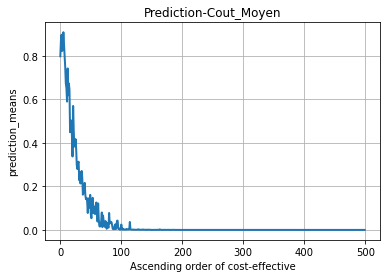

In [16]:
prediction_means = prediction_mean/data_size
fig, ax = plt.subplots()
# acc_one,= ax.plot(range(len(cost_effective_reorder)),cost_effective_reorder, linewidth=2.0,label=r'')
nb_one,= ax.plot(range(len(prediction_means)),prediction_means , linewidth=2.0)
plt.title("Prediction-Cout_Moyen")
plt.xlabel('Ascending order of cost-effective')
plt.ylabel('prediction_means')
plt.savefig("image/Prediction_Cout_Moyen")
plt.grid()
plt.show()

In [100]:
# model_name = data_name+"_MLP"+nb_mlp.__str__()+"Gamma0.5"
nb_mlp = 1
# data_name = "SC1000"

# model_name = data_name+"_MLP"+nb_mlp.__str__()
# model_name = data_name+"_MLP"+nb_mlp.__str__()+"Gamma0.5"
# model_name = "CFL30_NoCov_OnlyOutLayer"
# model_name = "CFL30_BCE_3MLP"
# model_name = "SC1000_NoCov_OnlyOutLayer"
model_name = "SC1000_FL_0.5Gamma_0.25Alpha_1MLP50TailleH"


model_path = "model/"+model_name

model = VariablePredictor(24,50,nb_mlp).to(device)
# model = VariablePredictor_OnlyOutLayer(24,24,nb_mlp).to(device)

model.load_state_dict(torch.load(model_path))
predictions,labels,y_hats,is_corrects = predict(model,data_test_gpu)
# _=valide(model,criterion,data_test_gpu,proportion = 0.9)

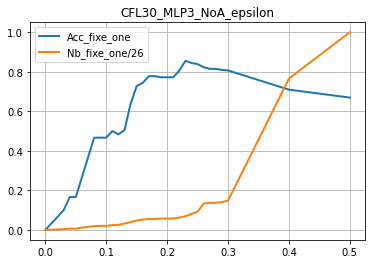

In [139]:
test_epsilon = []
epsilons = [0.01 * i for i in range(0,30,1)]+[0.01 * i for i in range(30,51,10)]
for e in epsilons:
    test_epsilon.append([e]+list(fixe_one_epsilon(predictions,y_hats,labels,e)))
header=["Epsilon", "Accuracy_fixe_one", "Number_fixe_one","Correct_One/Total_One"]
# print(tabulate(test_epsilon, headers=header))

with open("CSV/"+model_name+"_epsilon.csv","w") as csvfile: 
    writer = csv.writer(csvfile)
    writer.writerow(header)
    writer.writerows(test_epsilon)

fig, ax = plt.subplots()
values = np.array(test_epsilon).T
acc_one,= ax.plot(values[0], values[1], linewidth=2.0,label=r'Acc_fixe_one')
maxv = int(max(values[2]))
nb_one,= ax.plot(values[0], values[2]/maxv, linewidth=2.0,label=r'Nb_fixe_one/'+maxv.__str__())
plt.legend(handles=[acc_one,nb_one],loc="best",)
plt.title(model_name+"_epsilon")
plt.savefig("image/"+model_name+"_epsilon.png")
plt.grid()
plt.show()


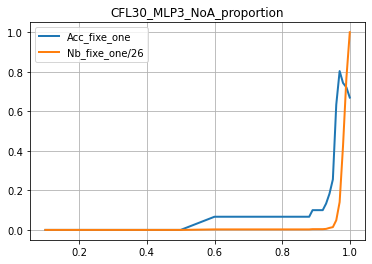

In [140]:
test_values = []
proportions = [0.1 * i for i in range(1,8)]+[0.01 * i for i in range(80,101)]
for p in proportions:
    test_values.append([p]+list(fixe_proportionally(predictions,labels,y_hats,is_corrects,proportion = p)))
header=["Proportion", "Accuracy_fixe_one", "Number_fixe_one","Accuracy_fixe_zero", "Number_fixe_zero"] 
# print(tabulate(test_values, headers=header))

with open("CSV/"+model_name+"_proportion.csv","w") as csvfile: 
    writer = csv.writer(csvfile)
    writer.writerow(header)
    writer.writerows(test_values)

fig, ax = plt.subplots()
values = np.array(test_values).T
acc_one,= ax.plot(values[0], values[1], linewidth=2.0,label=r'Acc_fixe_one')
maxv = int(max(values[2]))
nb_one,= ax.plot(values[0], values[2]/maxv, linewidth=2.0,label=r'Nb_fixe_one/'+maxv.__str__())
plt.legend(handles=[acc_one,nb_one],loc="best",)
plt.title(model_name+"_proportion")
plt.savefig("image/"+model_name+"_prop.png")
plt.grid()
plt.show()